# Neural Networks to Identify Handwritten Digits 
## Gary Lawson - 26 March 2019

## Introduction

The MINST dataset is comprised of thousands of images of handwritten digits ranging from 0 to 9.  Training a data model on labeled data can provide for prediction of future handwritten digits never seen by the model, allowing computer imaging to reduce the need for human interaction in detemining these handwritten characters.  In this experiement, each image is composed of 748 pixel darkeness values aranged in a 28 x 28 matrix of pixels.  Each pixel in the matrix is a feature of its own with a darkness value of 0 to 255, where 0 is white and 255 is black.  The data for this experiment was downloaded from the Kaggle competition named *Digit Recognizer* (link below), and was provided as separate train and test .csv files.

https://www.kaggle.com/c/digit-recognizer/data

The goal of this exercise is to create a neural network experiment design that tests a minimum of two separate experimental factors to identify the best performing model.  The experiments will be evaluated on processing time and the accuracy of both training cross-validation and test predictions.  The results of each design will be submitted to the *Digit Recognizer* Kaggle competition for scoring.    

Python will be used in a Jupyter Notebook to explore the data and produce a series of graphical representations to help visualize the survey data as well as develop several models for evaluation. Tensorflow and Keras will be used to generate the neural networks.  

## Initial EDA

In [27]:
# Seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

In [3]:
# Import base packages into the namespace for this program
import numpy as np # for creating and working with arrays
import pandas as pd # for creating and working with dataframes
from math import sqrt  # for root mean-squared error calculation
import time # for recording times on model runs

# Modeling routines from Scikit Learn packages
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # metrics for evaluating models
from sklearn.preprocessing import StandardScaler, MinMaxScaler # data scaling packages
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, \
                                    KFold, RandomizedSearchCV, GridSearchCV # model selection packages

# Import plotting packages
import matplotlib.pyplot as plt  # static plotting
import matplotlib as mpl
%matplotlib inline

# Import other packages
import pickle  # used for dumping and loading binary files
from collections import OrderedDict  # for creating table output

# Import Tensorflow neural network model packages
import tensorflow as tf
#from tensorflow_graph_in_jupyter import show_graph

# Import Keras neural network model package
from tensorflow.keras import layers

print('All packages have been sucessfully imported.')

All packages have been sucessfully imported.


In [4]:
# Read MNIST data train and test data, creating dataframes for both.
train_import = pd.read_csv('train.csv')
test_import = pd.read_csv('test.csv')
print('Data imports successful.')

Data imports successful.


In [5]:
# Check the pandas DataFrame object train_import
print('\nFeature List (including target variable(s)): \n', train_import.columns)
print('\nNumber of Features (including target variable(s): ', len(train_import.columns))
print('\nDataFrame (first five rows):')
train_import.head()


Feature List (including target variable(s)): 
 Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

Number of Features (including target variable(s):  785

DataFrame (first five rows):


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### <font color='blue'>Table 1: First Five Rows of Train Data</font>

Table 1 shows that there are 785 columns provided in the dataset that represent the 784 features and 1 target variable.  This aligns with what is expected from the *Digit Recognizer* Kaggle Competition description.  Additionally, each feature column is labeled as "pixelX" where X refers to the pixel number.

In [6]:
# Look at general information about the training data
print('\nGeneral description of the DataFrame:')
print(train_import.info())


General description of the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


There are 42,000 observations in the dataset, each having 785 features.  All data types are int64, meaning they are 64-bit integers.  The memory usage is 251.5 MB, which appears larger than other datasets I have worked with in the past.  This suggests that the time for computation may be slower than I have seen in the past.

In [7]:
# Check to see if there are any null values in the dataset.
print('\nMax number of values per training dataset feature that are NaN:', train_import.isnull().sum().max())
print('\nMax number of values per test dataset feature that are NaN:', test_import.isnull().sum().max())


Max number of values per training dataset feature that are NaN: 0

Max number of values per test dataset feature that are NaN: 0


Because the max summed value of NaN values is zero, this indicates that there are zero null values in the training and test datasets and it can be assumed that both datasets are complete.

In [8]:
# Look at the descriptive statistics of the data.
print('\nDescriptive statistics of the DataFrame:')
train_import.describe()


Descriptive statistics of the DataFrame:


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


#### <font color='blue'>Table 2: Descriptive Statistics of Train Data</font>

Due to the number of features, Table 2 is hard to review manually.  What we can say from the snapshot shown above is that for the label feature the mean is about 4.5.  This is expected as the numbers range from 0 to 9 (confirmed by the min and max in Table 2), and this suggests that there is an even distribution of target variables.  To confirm the distribution of label values, below is a count of each value category.  This distribution is pretty similar with 5 having the minimum number of target variables and 1 having the largest number of variables.

In [9]:
# Look at the distribution of digits in the train data.
num_count = train_import['label'].value_counts().sort_index()
print(num_count)
print('\nMax: ', num_count.nlargest(1))
print('\nMin: ', num_count.nsmallest(1))

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

Max:  1    4684
Name: label, dtype: int64

Min:  5    3795
Name: label, dtype: int64


## Create a Test and Train Set

In [11]:
# Train data, both X and y are provided.
X_train = train_import.drop(columns=['label']) # Drop label feature from dataset
y_train = train_import['label']

# Test data, note that no y_test exists because it is unknown.
X_test = test_import

In [12]:
# Review the shape of the data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(42000, 784)
(42000,)
(28000, 784)


## Look at Digit Examples

Let's plot some example images.  Functions were defined so that we can look at these images again in the future.

In [13]:
# Plot a single digit specified by specific .iloc
def plot_digit(data):
    image = data.values.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [14]:
# Plot first example of 0 through 9
def plot_digit_w_label(data, digit):
    print('\nLabeled value', digit)
    idx_loc = data[data['label']==digit].index[0]
    coords = data.iloc[idx_loc]
    some_digit = coords[1:]
    some_digit_image = some_digit.values.reshape(28, 28)
    plt.imshow(some_digit_image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

    plt.show()

In [15]:
# Plot several digits
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

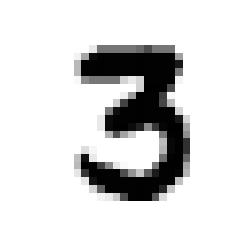

In [16]:
# Plot a single random digit
plot_digit(X_train.loc[3600])

#### <font color='blue'>Figure 1: An example of a single digit from the training dataset</font>


Labeled value 0


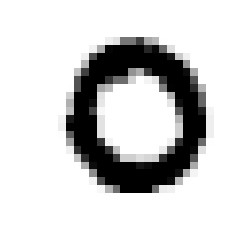


Labeled value 1


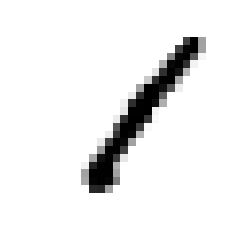


Labeled value 2


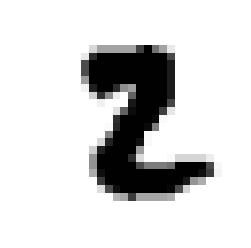


Labeled value 3


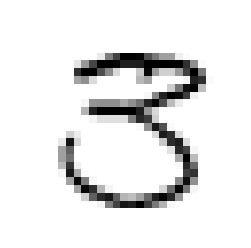


Labeled value 4


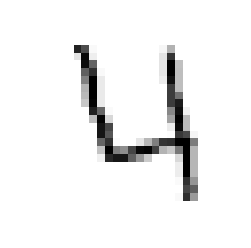


Labeled value 5


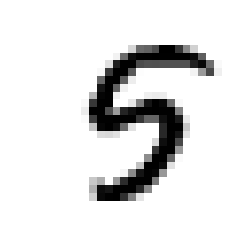


Labeled value 6


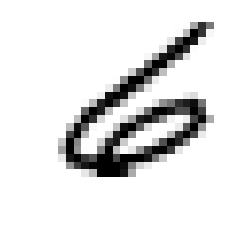


Labeled value 7


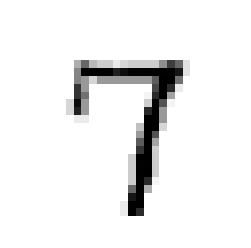


Labeled value 8


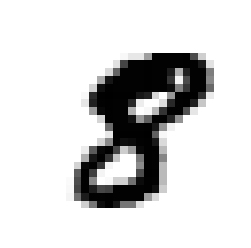


Labeled value 9


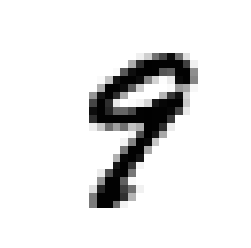

In [17]:
# Plot an example of each digit
for num in range(0,10):
    plot_digit_w_label(train_import,num)

#### <font color='blue'>Figure 2: Examples of each digit</font>

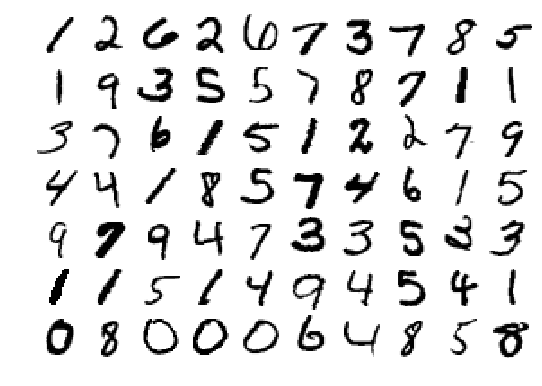

In [18]:
# Randomly plot a selection of digits.
plt.figure(figsize=(9,9))
example_images = np.r_[X_train[:12000:600], X_train[13000:30600:600], X_train[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
#save_fig("more_digits_plot")
plt.show()

#### <font color='blue'>Figure 3: More examples of the digit images contained in the training dataset</font>

## Transformations

No transformations were completed for this exercise.

## Scaling and Normalization

Machine Learning algorithms typically require input data to be normalized to help create efficiencies in the time it takes to train the data.  This is because when using Gradient Descent, the algorithm is able to train the data a lot faster with making incrimental steps between 0 and 1 than it can on a larger scale.  This also puts all input vectors on a common scale for use in the algorithm.

While there are several ways to do this, I have selected using the MinMaxScaler() from Scikit-Learn.  Note that I have fit the scaler to the training dataset and then transformed the training and test dataset separately.  This is to prevent the model from infering information about the test data prior to actually seeing the data.

It is interesting to note that while it perfectly scales the training data as expected, the test data has at least one datapoint that falls very far outside of the 0-1 fitted range with a value of 226.  I am assuming this is due to one (or potentially a few) dark pixel(s) that exists in probably one test dataset image in a position where the training dataset only has very light pixels.  I would guess it is most likely an outlier in the test dataset.

Other methods to use are the StandardScaler() or simply dividing each pixel by the max value of 255.  I chose not to use the StandardScaler() because it resulted in some large values in both the training and test datasets and was not providing very good results on an initial run of a deep neural network.  The approach of dividing the pixels by 255 was a simple and easy approach, but I chose to use the MinMaxScaler instead.

In [19]:
# Create the scaler
scaler = MinMaxScaler()

In [20]:
# Fit the scaler to the training data
scaler.fit(X_train)

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [21]:
# Transform data
X_train_scaled = scaler.transform(X_train)
# Print dataset properties before and after scaling
print("Transformed shape: {}".format(X_train_scaled.shape))
print("Dataframe minimum of per-feature values before scaling:\n {}".format((X_train.min()).min()))
print("Dataframe maximum of per-feature values before scaling:\n {}".format((X_train.max()).max()))
print("Dataframe minimum of per-feature values after scaling:\n {}".format((X_train_scaled.min()).min()))
print("Dataframe maximum of per-feature values after scaling:\n {}".format((X_train_scaled.max()).max()))
#print("per-feature minimum before scaling:\n {}".format(X_train.min(axis=0)))
#print("per-feature maximum before scaling:\n {}".format(X_train.max(axis=0)))
#print("per-feature minimum after scaling:\n {}".format(X_train_scaled.min(axis=0)))
#print("per-feature maximum after scaling:\n {}".format(X_train_scaled.max(axis=0)))

Transformed shape: (42000, 784)
Dataframe minimum of per-feature values before scaling:
 0
Dataframe maximum of per-feature values before scaling:
 255
Dataframe minimum of per-feature values after scaling:
 0.0
Dataframe maximum of per-feature values after scaling:
 1.0


In [22]:
# Check the parameters of the scaler
scaler.get_params

<bound method BaseEstimator.get_params of MinMaxScaler(copy=True, feature_range=(0, 1))>

In [23]:
# Transform test data
X_test_scaled = scaler.transform(X_test)
print("Transformed shape: {}".format(X_test_scaled.shape))
# Print test data properties before and after scaling
print("Dataframe minimum of per-feature values after scaling:\n {}".format((X_test.min()).min()))
print("Dataframe maximum of per-feature values after scaling:\n {}".format((X_test.max()).max()))
print("Dataframe minimum of per-feature values after scaling:\n {}".format((X_test_scaled.min()).min()))
print("Dataframe maximum of per-feature values after scaling:\n {}".format(X_test_scaled.max()))
#print("per-feature minimum after scaling:\n{}".format(X_test_scaled.min(axis=0)))
#print("per-feature maximum after scaling:\n{}".format(X_test_scaled.max(axis=0)))

Transformed shape: (28000, 784)
Dataframe minimum of per-feature values after scaling:
 0
Dataframe maximum of per-feature values after scaling:
 255
Dataframe minimum of per-feature values after scaling:
 0.0
Dataframe maximum of per-feature values after scaling:
 226.0


## Create Train and Validation Data Sets

To create use cross validation to train a model, a validation dataset must be created from the training set.  A validation set is a sub dataset made up of observations from the training set, including the features and the target response variable.  This validation set is not used during the training of the model, but is used to validate the results of the model after training by predicting the target response of the unseen validation data and then comparing those predictions to the actual validation target response.  This allows the researcher to evalute the model's ability to generalize to new observations.

To optimize the split of the existing training data set into a new training and validaiton set, a several split sizes will be looped through a simple neural network.  This split size yielding the best results on this simple network will be assumed to represent the optimal split for future neural networks.

### Evaluate Optimal Train/Test Split

In [24]:
# Define test sizes
test_size = [0.05,0.1,0.15,0.2,0.25,0.3] # validation set sizes to try, where the size is a ratio
                                         # of the training set size.

In [25]:
# Create lists to record the results of each iteration
index_for_method = 0 
training_performance_results = []
validation_performance_results = []
processing_time = []

In [28]:
# Create a loop to go through and evaluate a basic model based on several different validation set sizes.
for size in test_size:
    print('\n------------------------------------')
    print('\nValidation Dataset Size Ratio to Training Set:', size)
    
    start_time = time.clock() # start timer to evaluate how long it takes to train this base model
    
    X = X_train_scaled # define the X variables
    y = y_train # define the response variable

    
    X_train_eval, X_valid_eval, y_train_eval, y_valid_eval = train_test_split(X, y, test_size=size, \
                                                                              random_state=RANDOM_SEED) # split data
                                                                                                        # and return arrays
    X_train_eval = X_train_eval.astype(np.float32).reshape(-1, 28*28) # turn to float and resize 
    X_valid_eval = X_valid_eval.astype(np.float32).reshape(-1, 28*28) # turn to float and resize 
    y_train_eval = y_train_eval.astype(np.int32).values # turn to int
    y_valid_eval = y_valid_eval.astype(np.int32).values # turn to int
    
    tf.set_random_seed(RANDOM_SEED)
    
    # Create the model
    feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
    dnn_clf = tf.estimator.DNNClassifier(hidden_units=[300,100], n_classes=10,
                                         feature_columns=feature_cols) # create DNN classifier
    
    # Train the model
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"X": X_train_eval}, y=y_train_eval, num_epochs=40, batch_size=50, shuffle=True)
    dnn_clf.train(input_fn=input_fn)
    
    end_time = time.clock() # end timer
    runtime = end_time - start_time  # seconds of wall-clock time 
    print("\nProcessing time (seconds): %f" % runtime) # print process time to train model      
    processing_time.append(runtime) # append process time results to list for comparison table
 
    # Use training and validation data to check model results
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"X": X_train_eval}, y=y_train_eval, shuffle=False)
    train_eval_results = dnn_clf.evaluate(input_fn=train_input_fn) # training results
    
    valid_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"X": X_valid_eval}, y=y_valid_eval, shuffle=False)
    valid_eval_results = dnn_clf.evaluate(input_fn=valid_input_fn) # validation results
      
    
    # mean accuracy of prediction in training set
    training_performance = train_eval_results['accuracy']
    print("\nTraining set accuracy: %f" % training_performance)
    training_performance_results.append(training_performance) # append results to list for comparison table

    # mean accuracy of prediction in test set
    validation_performance = valid_eval_results['accuracy']
    print("\nValidation set accuracy: %f" % validation_performance)
    validation_performance_results.append(validation_performance) # append results to list for comparison table
                
    index_for_method += 1


------------------------------------

Validation Dataset Size Ratio to Training Set: 0.05
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\DELL\\AppData\\Local\\Temp\\tmp38kwq5_5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000263009D2828>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions

INFO:tensorflow:global_step/sec: 421.286
INFO:tensorflow:loss = 0.25623214, step = 5901 (0.240 sec)
INFO:tensorflow:global_step/sec: 388.637
INFO:tensorflow:loss = 0.92498434, step = 6001 (0.257 sec)
INFO:tensorflow:global_step/sec: 445.635
INFO:tensorflow:loss = 0.26610512, step = 6101 (0.220 sec)
INFO:tensorflow:global_step/sec: 459.943
INFO:tensorflow:loss = 0.72769856, step = 6201 (0.220 sec)
INFO:tensorflow:global_step/sec: 447.621
INFO:tensorflow:loss = 0.06642861, step = 6301 (0.221 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 2.037195, step = 6401 (0.387 sec)
INFO:tensorflow:global_step/sec: 391.655
INFO:tensorflow:loss = 0.13484032, step = 6501 (0.255 sec)
INFO:tensorflow:global_step/sec: 455.781
INFO:tensorflow:loss = 0.9450849, step = 6601 (0.220 sec)
INFO:tensorflow:global_step/sec: 388.632
INFO:tensorflow:loss = 0.91937745, step = 6701 (0.257 sec)
INFO:tensorflow:global_step/sec: 424.86
INFO:tensorflow:loss = 0.05700584, step = 6801 (0.235 sec)
INFO

INFO:tensorflow:global_step/sec: 394.753
INFO:tensorflow:loss = 0.08873595, step = 14101 (0.254 sec)
INFO:tensorflow:global_step/sec: 391.671
INFO:tensorflow:loss = 0.084547564, step = 14201 (0.253 sec)
INFO:tensorflow:global_step/sec: 412.621
INFO:tensorflow:loss = 0.08995577, step = 14301 (0.245 sec)
INFO:tensorflow:global_step/sec: 451.656
INFO:tensorflow:loss = 0.02042368, step = 14401 (0.218 sec)
INFO:tensorflow:global_step/sec: 459.942
INFO:tensorflow:loss = 0.021500386, step = 14501 (0.217 sec)
INFO:tensorflow:global_step/sec: 449.629
INFO:tensorflow:loss = 0.08886272, step = 14601 (0.222 sec)
INFO:tensorflow:global_step/sec: 443.661
INFO:tensorflow:loss = 0.0447156, step = 14701 (0.226 sec)
INFO:tensorflow:global_step/sec: 451.655
INFO:tensorflow:loss = 0.08457529, step = 14801 (0.221 sec)
INFO:tensorflow:global_step/sec: 441.706
INFO:tensorflow:loss = 0.14547695, step = 14901 (0.226 sec)
INFO:tensorflow:global_step/sec: 435.947
INFO:tensorflow:loss = 0.039307073, step = 15001 

INFO:tensorflow:global_step/sec: 451.657
INFO:tensorflow:loss = 0.026390519, step = 22201 (0.223 sec)
INFO:tensorflow:global_step/sec: 453.697
INFO:tensorflow:loss = 0.029911643, step = 22301 (0.219 sec)
INFO:tensorflow:global_step/sec: 441.706
INFO:tensorflow:loss = 0.10103087, step = 22401 (0.225 sec)
INFO:tensorflow:global_step/sec: 424.862
INFO:tensorflow:loss = 0.008489851, step = 22501 (0.238 sec)
INFO:tensorflow:global_step/sec: 428.493
INFO:tensorflow:loss = 0.02169818, step = 22601 (0.232 sec)
INFO:tensorflow:global_step/sec: 443.662
INFO:tensorflow:loss = 0.03204372, step = 22701 (0.225 sec)
INFO:tensorflow:global_step/sec: 441.704
INFO:tensorflow:loss = 0.04042576, step = 22801 (0.224 sec)
INFO:tensorflow:global_step/sec: 441.708
INFO:tensorflow:loss = 0.09834968, step = 22901 (0.227 sec)
INFO:tensorflow:global_step/sec: 419.528
INFO:tensorflow:loss = 0.14589848, step = 23001 (0.238 sec)
INFO:tensorflow:global_step/sec: 435.944
INFO:tensorflow:loss = 0.020508599, step = 2310

INFO:tensorflow:global_step/sec: 455.761
INFO:tensorflow:loss = 0.012542546, step = 30301 (0.220 sec)
INFO:tensorflow:global_step/sec: 457.841
INFO:tensorflow:loss = 0.01110005, step = 30401 (0.219 sec)
INFO:tensorflow:global_step/sec: 455.761
INFO:tensorflow:loss = 0.0034997796, step = 30501 (0.218 sec)
INFO:tensorflow:global_step/sec: 453.698
INFO:tensorflow:loss = 0.03905338, step = 30601 (0.220 sec)
INFO:tensorflow:global_step/sec: 455.759
INFO:tensorflow:loss = 0.0019726423, step = 30701 (0.218 sec)
INFO:tensorflow:global_step/sec: 462.063
INFO:tensorflow:loss = 0.018874163, step = 30801 (0.217 sec)
INFO:tensorflow:global_step/sec: 457.841
INFO:tensorflow:loss = 0.018653642, step = 30901 (0.218 sec)
INFO:tensorflow:global_step/sec: 457.837
INFO:tensorflow:loss = 0.01553464, step = 31001 (0.217 sec)
INFO:tensorflow:global_step/sec: 453.704
INFO:tensorflow:loss = 0.0051347893, step = 31101 (0.220 sec)
INFO:tensorflow:global_step/sec: 457.84
INFO:tensorflow:loss = 0.015011555, step =

INFO:tensorflow:loss = 1.553717, step = 3501 (0.223 sec)
INFO:tensorflow:global_step/sec: 441.706
INFO:tensorflow:loss = 0.28709063, step = 3601 (0.226 sec)
INFO:tensorflow:global_step/sec: 447.623
INFO:tensorflow:loss = 5.129799, step = 3701 (0.221 sec)
INFO:tensorflow:global_step/sec: 284.043
INFO:tensorflow:loss = 0.9301588, step = 3801 (0.353 sec)
INFO:tensorflow:global_step/sec: 451.656
INFO:tensorflow:loss = 3.174165, step = 3901 (0.220 sec)
INFO:tensorflow:global_step/sec: 447.623
INFO:tensorflow:loss = 0.40194708, step = 4001 (0.224 sec)
INFO:tensorflow:global_step/sec: 453.699
INFO:tensorflow:loss = 0.38329628, step = 4101 (0.220 sec)
INFO:tensorflow:global_step/sec: 445.631
INFO:tensorflow:loss = 0.7411385, step = 4201 (0.223 sec)
INFO:tensorflow:global_step/sec: 459.942
INFO:tensorflow:loss = 0.64197063, step = 4301 (0.217 sec)
INFO:tensorflow:global_step/sec: 453.699
INFO:tensorflow:loss = 1.4267545, step = 4401 (0.221 sec)
INFO:tensorflow:global_step/sec: 457.842
INFO:tens

INFO:tensorflow:global_step/sec: 435.944
INFO:tensorflow:loss = 0.07665203, step = 11801 (0.230 sec)
INFO:tensorflow:global_step/sec: 430.332
INFO:tensorflow:loss = 0.067488864, step = 11901 (0.231 sec)
INFO:tensorflow:global_step/sec: 445.633
INFO:tensorflow:loss = 0.046079375, step = 12001 (0.224 sec)
INFO:tensorflow:global_step/sec: 445.633
INFO:tensorflow:loss = 0.015307587, step = 12101 (0.224 sec)
INFO:tensorflow:global_step/sec: 428.492
INFO:tensorflow:loss = 0.045594864, step = 12201 (0.233 sec)
INFO:tensorflow:global_step/sec: 441.707
INFO:tensorflow:loss = 0.09734434, step = 12301 (0.226 sec)
INFO:tensorflow:global_step/sec: 443.66
INFO:tensorflow:loss = 0.12689018, step = 12401 (0.225 sec)
INFO:tensorflow:global_step/sec: 443.661
INFO:tensorflow:loss = 0.01889348, step = 12501 (0.228 sec)
INFO:tensorflow:global_step/sec: 441.705
INFO:tensorflow:loss = 0.01835371, step = 12601 (0.226 sec)
INFO:tensorflow:global_step/sec: 451.657
INFO:tensorflow:loss = 0.048535556, step = 1270

INFO:tensorflow:global_step/sec: 434.062
INFO:tensorflow:loss = 0.09779611, step = 19901 (0.229 sec)
INFO:tensorflow:global_step/sec: 439.767
INFO:tensorflow:loss = 0.08505337, step = 20001 (0.229 sec)
INFO:tensorflow:global_step/sec: 441.707
INFO:tensorflow:loss = 0.021082336, step = 20101 (0.226 sec)
INFO:tensorflow:global_step/sec: 453.699
INFO:tensorflow:loss = 0.05370053, step = 20201 (0.219 sec)
INFO:tensorflow:global_step/sec: 451.655
INFO:tensorflow:loss = 0.012424137, step = 20301 (0.220 sec)
INFO:tensorflow:global_step/sec: 457.841
INFO:tensorflow:loss = 0.022459075, step = 20401 (0.219 sec)
INFO:tensorflow:global_step/sec: 451.655
INFO:tensorflow:loss = 0.011613885, step = 20501 (0.222 sec)
INFO:tensorflow:global_step/sec: 437.849
INFO:tensorflow:loss = 0.04117364, step = 20601 (0.227 sec)
INFO:tensorflow:global_step/sec: 435.942
INFO:tensorflow:loss = 0.02480733, step = 20701 (0.228 sec)
INFO:tensorflow:global_step/sec: 424.864
INFO:tensorflow:loss = 0.045177348, step = 208

INFO:tensorflow:global_step/sec: 449.631
INFO:tensorflow:loss = 0.0058932737, step = 28001 (0.223 sec)
INFO:tensorflow:global_step/sec: 396.313
INFO:tensorflow:loss = 0.015036274, step = 28101 (0.253 sec)
INFO:tensorflow:global_step/sec: 443.661
INFO:tensorflow:loss = 0.024550065, step = 28201 (0.224 sec)
INFO:tensorflow:global_step/sec: 430.332
INFO:tensorflow:loss = 0.016542554, step = 28301 (0.232 sec)
INFO:tensorflow:global_step/sec: 453.697
INFO:tensorflow:loss = 0.032369323, step = 28401 (0.219 sec)
INFO:tensorflow:global_step/sec: 443.662
INFO:tensorflow:loss = 0.032722637, step = 28501 (0.226 sec)
INFO:tensorflow:global_step/sec: 432.185
INFO:tensorflow:loss = 0.02448223, step = 28601 (0.231 sec)
INFO:tensorflow:global_step/sec: 434.057
INFO:tensorflow:loss = 0.00800255, step = 28701 (0.231 sec)
INFO:tensorflow:global_step/sec: 439.772
INFO:tensorflow:loss = 0.0025349606, step = 28801 (0.226 sec)
INFO:tensorflow:global_step/sec: 447.623
INFO:tensorflow:loss = 0.007017623, step 

INFO:tensorflow:global_step/sec: 439.769
INFO:tensorflow:loss = 0.08273874, step = 2901 (0.226 sec)
INFO:tensorflow:global_step/sec: 443.661
INFO:tensorflow:loss = 2.77108, step = 3001 (0.226 sec)
INFO:tensorflow:global_step/sec: 449.63
INFO:tensorflow:loss = 0.16370696, step = 3101 (0.224 sec)
INFO:tensorflow:global_step/sec: 439.769
INFO:tensorflow:loss = 0.4206935, step = 3201 (0.227 sec)
INFO:tensorflow:global_step/sec: 428.493
INFO:tensorflow:loss = 0.93283796, step = 3301 (0.231 sec)
INFO:tensorflow:global_step/sec: 434.059
INFO:tensorflow:loss = 0.26979136, step = 3401 (0.229 sec)
INFO:tensorflow:global_step/sec: 462.062
INFO:tensorflow:loss = 0.4306499, step = 3501 (0.217 sec)
INFO:tensorflow:global_step/sec: 417.779
INFO:tensorflow:loss = 1.091915, step = 3601 (0.240 sec)
INFO:tensorflow:global_step/sec: 430.333
INFO:tensorflow:loss = 1.1520674, step = 3701 (0.231 sec)
INFO:tensorflow:global_step/sec: 457.841
INFO:tensorflow:loss = 0.55014193, step = 3801 (0.217 sec)
INFO:tens

INFO:tensorflow:loss = 0.16548511, step = 11101 (0.220 sec)
INFO:tensorflow:global_step/sec: 457.842
INFO:tensorflow:loss = 0.024973366, step = 11201 (0.220 sec)
INFO:tensorflow:global_step/sec: 449.629
INFO:tensorflow:loss = 0.054830562, step = 11301 (0.220 sec)
INFO:tensorflow:global_step/sec: 437.848
INFO:tensorflow:loss = 0.019488864, step = 11401 (0.229 sec)
INFO:tensorflow:global_step/sec: 455.762
INFO:tensorflow:loss = 0.006336584, step = 11501 (0.219 sec)
INFO:tensorflow:global_step/sec: 457.84
INFO:tensorflow:loss = 0.124180965, step = 11601 (0.218 sec)
INFO:tensorflow:global_step/sec: 297.53
INFO:tensorflow:loss = 0.008355436, step = 11701 (0.337 sec)
INFO:tensorflow:global_step/sec: 412.622
INFO:tensorflow:loss = 0.037907217, step = 11801 (0.242 sec)
INFO:tensorflow:global_step/sec: 432.187
INFO:tensorflow:loss = 0.3799922, step = 11901 (0.230 sec)
INFO:tensorflow:global_step/sec: 426.67
INFO:tensorflow:loss = 0.060746036, step = 12001 (0.236 sec)
INFO:tensorflow:global_step

INFO:tensorflow:loss = 0.0192499, step = 19201 (0.226 sec)
INFO:tensorflow:global_step/sec: 394.754
INFO:tensorflow:loss = 0.03461308, step = 19301 (0.253 sec)
INFO:tensorflow:global_step/sec: 432.187
INFO:tensorflow:loss = 0.002672296, step = 19401 (0.232 sec)
INFO:tensorflow:global_step/sec: 441.704
INFO:tensorflow:loss = 0.009693082, step = 19501 (0.226 sec)
INFO:tensorflow:global_step/sec: 423.071
INFO:tensorflow:loss = 0.035120077, step = 19601 (0.237 sec)
INFO:tensorflow:global_step/sec: 462.062
INFO:tensorflow:loss = 0.008021808, step = 19701 (0.214 sec)
INFO:tensorflow:global_step/sec: 462.06
INFO:tensorflow:loss = 0.006368459, step = 19801 (0.217 sec)
INFO:tensorflow:global_step/sec: 455.762
INFO:tensorflow:loss = 0.005907655, step = 19901 (0.219 sec)
INFO:tensorflow:global_step/sec: 453.698
INFO:tensorflow:loss = 0.089351386, step = 20001 (0.220 sec)
INFO:tensorflow:global_step/sec: 464.198
INFO:tensorflow:loss = 0.019177305, step = 20101 (0.214 sec)
INFO:tensorflow:global_st

INFO:tensorflow:global_step/sec: 441.706
INFO:tensorflow:loss = 0.006770461, step = 27301 (0.226 sec)
INFO:tensorflow:global_step/sec: 449.63
INFO:tensorflow:loss = 0.021022826, step = 27401 (0.222 sec)
INFO:tensorflow:global_step/sec: 453.699
INFO:tensorflow:loss = 0.015568093, step = 27501 (0.220 sec)
INFO:tensorflow:global_step/sec: 468.537
INFO:tensorflow:loss = 0.007968791, step = 27601 (0.213 sec)
INFO:tensorflow:global_step/sec: 470.739
INFO:tensorflow:loss = 0.0059504355, step = 27701 (0.211 sec)
INFO:tensorflow:global_step/sec: 451.656
INFO:tensorflow:loss = 0.007939151, step = 27801 (0.222 sec)
INFO:tensorflow:global_step/sec: 435.946
INFO:tensorflow:loss = 0.088656686, step = 27901 (0.229 sec)
INFO:tensorflow:global_step/sec: 453.697
INFO:tensorflow:loss = 0.00890552, step = 28001 (0.219 sec)
INFO:tensorflow:global_step/sec: 470.741
INFO:tensorflow:loss = 0.0104146255, step = 28101 (0.212 sec)
INFO:tensorflow:global_step/sec: 472.96
INFO:tensorflow:loss = 0.017083103, step =

INFO:tensorflow:loss = 0.3047625, step = 3901 (0.245 sec)
INFO:tensorflow:global_step/sec: 397.888
INFO:tensorflow:loss = 0.666752, step = 4001 (0.249 sec)
INFO:tensorflow:global_step/sec: 445.632
INFO:tensorflow:loss = 0.927069, step = 4101 (0.224 sec)
INFO:tensorflow:global_step/sec: 402.679
INFO:tensorflow:loss = 0.51592803, step = 4201 (0.249 sec)
INFO:tensorflow:global_step/sec: 445.635
INFO:tensorflow:loss = 0.33475304, step = 4301 (0.223 sec)
INFO:tensorflow:global_step/sec: 441.705
INFO:tensorflow:loss = 0.25831208, step = 4401 (0.227 sec)
INFO:tensorflow:global_step/sec: 437.848
INFO:tensorflow:loss = 6.0942674, step = 4501 (0.234 sec)
INFO:tensorflow:global_step/sec: 419.531
INFO:tensorflow:loss = 0.14529887, step = 4601 (0.231 sec)
INFO:tensorflow:global_step/sec: 401.07
INFO:tensorflow:loss = 0.87637025, step = 4701 (0.252 sec)
INFO:tensorflow:global_step/sec: 329.827
INFO:tensorflow:loss = 3.1449502, step = 4801 (0.301 sec)
INFO:tensorflow:global_step/sec: 451.654
INFO:ten

INFO:tensorflow:loss = 0.06607237, step = 12101 (0.214 sec)
INFO:tensorflow:global_step/sec: 462.062
INFO:tensorflow:loss = 0.096710265, step = 12201 (0.217 sec)
INFO:tensorflow:global_step/sec: 470.737
INFO:tensorflow:loss = 0.1072317, step = 12301 (0.211 sec)
INFO:tensorflow:global_step/sec: 470.74
INFO:tensorflow:loss = 0.17343092, step = 12401 (0.213 sec)
INFO:tensorflow:global_step/sec: 475.2
INFO:tensorflow:loss = 0.0036916968, step = 12501 (0.210 sec)
INFO:tensorflow:global_step/sec: 472.96
INFO:tensorflow:loss = 0.10728967, step = 12601 (0.211 sec)
INFO:tensorflow:global_step/sec: 462.062
INFO:tensorflow:loss = 0.12131133, step = 12701 (0.216 sec)
INFO:tensorflow:global_step/sec: 472.959
INFO:tensorflow:loss = 0.0396545, step = 12801 (0.211 sec)
INFO:tensorflow:global_step/sec: 466.359
INFO:tensorflow:loss = 0.0857633, step = 12901 (0.213 sec)
INFO:tensorflow:global_step/sec: 470.74
INFO:tensorflow:loss = 0.00660461, step = 13001 (0.212 sec)
INFO:tensorflow:global_step/sec: 475

INFO:tensorflow:loss = 0.01878412, step = 20201 (0.212 sec)
INFO:tensorflow:global_step/sec: 470.73
INFO:tensorflow:loss = 0.030728843, step = 20301 (0.212 sec)
INFO:tensorflow:global_step/sec: 464.209
INFO:tensorflow:loss = 0.012945809, step = 20401 (0.215 sec)
INFO:tensorflow:global_step/sec: 470.739
INFO:tensorflow:loss = 0.025021907, step = 20501 (0.212 sec)
INFO:tensorflow:global_step/sec: 468.539
INFO:tensorflow:loss = 0.001586907, step = 20601 (0.214 sec)
INFO:tensorflow:global_step/sec: 477.463
INFO:tensorflow:loss = 0.025543315, step = 20701 (0.207 sec)
INFO:tensorflow:global_step/sec: 477.464
INFO:tensorflow:loss = 0.09500315, step = 20801 (0.210 sec)
INFO:tensorflow:global_step/sec: 466.36
INFO:tensorflow:loss = 0.041365385, step = 20901 (0.214 sec)
INFO:tensorflow:global_step/sec: 457.839
INFO:tensorflow:loss = 0.01079323, step = 21001 (0.217 sec)
INFO:tensorflow:global_step/sec: 475.203
INFO:tensorflow:loss = 0.013545644, step = 21101 (0.211 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 26880: C:\Users\DELL\AppData\Local\Temp\tmp8pk38wa3\model.ckpt-26880

Training set accuracy: 1.000000

Validation set accuracy: 0.977143

------------------------------------

Validation Dataset Size Ratio to Training Set: 0.25
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\DELL\\AppData\\Local\\Temp\\tmpxjoqru9p', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002

INFO:tensorflow:global_step/sec: 424.862
INFO:tensorflow:loss = 0.683291, step = 6701 (0.236 sec)
INFO:tensorflow:global_step/sec: 338.741
INFO:tensorflow:loss = 0.5825939, step = 6801 (0.295 sec)
INFO:tensorflow:global_step/sec: 375.533
INFO:tensorflow:loss = 0.1222582, step = 6901 (0.266 sec)
INFO:tensorflow:global_step/sec: 297.529
INFO:tensorflow:loss = 0.07628743, step = 7001 (0.338 sec)
INFO:tensorflow:global_step/sec: 326.604
INFO:tensorflow:loss = 0.051696215, step = 7101 (0.306 sec)
INFO:tensorflow:global_step/sec: 375.533
INFO:tensorflow:loss = 0.33753166, step = 7201 (0.267 sec)
INFO:tensorflow:global_step/sec: 412.623
INFO:tensorflow:loss = 1.0814495, step = 7301 (0.240 sec)
INFO:tensorflow:global_step/sec: 378.366
INFO:tensorflow:loss = 0.0734723, step = 7401 (0.267 sec)
INFO:tensorflow:global_step/sec: 222.323
INFO:tensorflow:loss = 0.07366173, step = 7501 (0.450 sec)
INFO:tensorflow:global_step/sec: 363.286
INFO:tensorflow:loss = 0.20644048, step = 7601 (0.275 sec)
INFO:

INFO:tensorflow:loss = 0.064032525, step = 14801 (0.346 sec)
INFO:tensorflow:global_step/sec: 434.052
INFO:tensorflow:loss = 0.003026906, step = 14901 (0.232 sec)
INFO:tensorflow:global_step/sec: 455.767
INFO:tensorflow:loss = 0.03724696, step = 15001 (0.218 sec)
INFO:tensorflow:global_step/sec: 443.661
INFO:tensorflow:loss = 0.01119914, step = 15101 (0.225 sec)
INFO:tensorflow:global_step/sec: 430.332
INFO:tensorflow:loss = 0.014681511, step = 15201 (0.231 sec)
INFO:tensorflow:global_step/sec: 322.403
INFO:tensorflow:loss = 0.030026814, step = 15301 (0.311 sec)
INFO:tensorflow:global_step/sec: 358.097
INFO:tensorflow:loss = 0.008351855, step = 15401 (0.279 sec)
INFO:tensorflow:global_step/sec: 468.539
INFO:tensorflow:loss = 0.023225171, step = 15501 (0.212 sec)
INFO:tensorflow:global_step/sec: 449.629
INFO:tensorflow:loss = 0.0093390085, step = 15601 (0.223 sec)
INFO:tensorflow:global_step/sec: 423.069
INFO:tensorflow:loss = 0.070139416, step = 15701 (0.236 sec)
INFO:tensorflow:global

INFO:tensorflow:global_step/sec: 313.335
INFO:tensorflow:loss = 0.009420505, step = 22901 (0.318 sec)
INFO:tensorflow:global_step/sec: 459.942
INFO:tensorflow:loss = 0.0011132826, step = 23001 (0.217 sec)
INFO:tensorflow:global_step/sec: 449.63
INFO:tensorflow:loss = 0.01732196, step = 23101 (0.222 sec)
INFO:tensorflow:global_step/sec: 441.706
INFO:tensorflow:loss = 0.010982245, step = 23201 (0.226 sec)
INFO:tensorflow:global_step/sec: 430.332
INFO:tensorflow:loss = 0.018547542, step = 23301 (0.232 sec)
INFO:tensorflow:global_step/sec: 278.521
INFO:tensorflow:loss = 0.017870639, step = 23401 (0.360 sec)
INFO:tensorflow:global_step/sec: 441.706
INFO:tensorflow:loss = 0.011824912, step = 23501 (0.226 sec)
INFO:tensorflow:global_step/sec: 462.06
INFO:tensorflow:loss = 0.003238764, step = 23601 (0.216 sec)
INFO:tensorflow:global_step/sec: 459.94
INFO:tensorflow:loss = 0.011748845, step = 23701 (0.216 sec)
INFO:tensorflow:global_step/sec: 462.065
INFO:tensorflow:loss = 0.013428579, step = 2

INFO:tensorflow:global_step/sec: 466.36
INFO:tensorflow:loss = 0.91763395, step = 2901 (0.213 sec)
INFO:tensorflow:global_step/sec: 472.959
INFO:tensorflow:loss = 1.0785446, step = 3001 (0.211 sec)
INFO:tensorflow:global_step/sec: 464.201
INFO:tensorflow:loss = 1.105248, step = 3101 (0.215 sec)
INFO:tensorflow:global_step/sec: 472.959
INFO:tensorflow:loss = 0.27634305, step = 3201 (0.211 sec)
INFO:tensorflow:global_step/sec: 453.698
INFO:tensorflow:loss = 0.17137751, step = 3301 (0.221 sec)
INFO:tensorflow:global_step/sec: 470.74
INFO:tensorflow:loss = 1.7129458, step = 3401 (0.211 sec)
INFO:tensorflow:global_step/sec: 470.738
INFO:tensorflow:loss = 1.2125884, step = 3501 (0.213 sec)
INFO:tensorflow:global_step/sec: 457.843
INFO:tensorflow:loss = 0.89907354, step = 3601 (0.218 sec)
INFO:tensorflow:global_step/sec: 470.739
INFO:tensorflow:loss = 1.1392657, step = 3701 (0.211 sec)
INFO:tensorflow:global_step/sec: 466.361
INFO:tensorflow:loss = 0.36984187, step = 3801 (0.214 sec)
INFO:ten

INFO:tensorflow:global_step/sec: 432.188
INFO:tensorflow:loss = 0.009551722, step = 11101 (0.231 sec)
INFO:tensorflow:global_step/sec: 470.739
INFO:tensorflow:loss = 0.048096552, step = 11201 (0.213 sec)
INFO:tensorflow:global_step/sec: 455.76
INFO:tensorflow:loss = 0.012033304, step = 11301 (0.218 sec)
INFO:tensorflow:global_step/sec: 459.943
INFO:tensorflow:loss = 0.05017293, step = 11401 (0.217 sec)
INFO:tensorflow:global_step/sec: 464.201
INFO:tensorflow:loss = 0.050896324, step = 11501 (0.215 sec)
INFO:tensorflow:global_step/sec: 447.621
INFO:tensorflow:loss = 0.0261728, step = 11601 (0.222 sec)
INFO:tensorflow:global_step/sec: 435.944
INFO:tensorflow:loss = 0.006369493, step = 11701 (0.229 sec)
INFO:tensorflow:global_step/sec: 435.943
INFO:tensorflow:loss = 0.09250713, step = 11801 (0.230 sec)
INFO:tensorflow:global_step/sec: 439.772
INFO:tensorflow:loss = 0.033260062, step = 11901 (0.227 sec)
INFO:tensorflow:global_step/sec: 470.74
INFO:tensorflow:loss = 0.038252495, step = 1200

INFO:tensorflow:global_step/sec: 434.057
INFO:tensorflow:loss = 0.0047298614, step = 19201 (0.229 sec)
INFO:tensorflow:global_step/sec: 447.622
INFO:tensorflow:loss = 0.012548296, step = 19301 (0.223 sec)
INFO:tensorflow:global_step/sec: 472.96
INFO:tensorflow:loss = 0.009551236, step = 19401 (0.211 sec)
INFO:tensorflow:global_step/sec: 466.36
INFO:tensorflow:loss = 0.0070760017, step = 19501 (0.215 sec)
INFO:tensorflow:global_step/sec: 462.061
INFO:tensorflow:loss = 0.017886115, step = 19601 (0.216 sec)
INFO:tensorflow:global_step/sec: 453.699
INFO:tensorflow:loss = 0.018388394, step = 19701 (0.220 sec)
INFO:tensorflow:global_step/sec: 459.942
INFO:tensorflow:loss = 0.018371172, step = 19801 (0.217 sec)
INFO:tensorflow:global_step/sec: 462.062
INFO:tensorflow:loss = 0.0057064234, step = 19901 (0.215 sec)
INFO:tensorflow:global_step/sec: 419.505
INFO:tensorflow:loss = 0.010406619, step = 20001 (0.241 sec)
INFO:tensorflow:global_step/sec: 412.643
INFO:tensorflow:loss = 0.033260614, step

In [30]:
# Create a table to display results of experiement
results = pd.DataFrame(OrderedDict([('Validation Dataset Ratio', test_size),
                        ('Processing Time', processing_time),
                        ('Training Set Accuracy', training_performance_results),
                        ('Validation Set Accuracy', validation_performance_results)]))

print('\nValidation Dataset Size Ratio to Training Dataset: Tensorflow Deep Neural Networks\n')
results 


Validation Dataset Size Ratio to Training Dataset: Tensorflow Deep Neural Networks



,Validation Dataset Ratio,Processing Time,Training Set Accuracy,Validation Set Accuracy
0,0.05,76.759999,1.0,0.972857
1,0.10,72.584186,1.0,0.971429
2,0.15,67.568527,1.0,0.974603
3,0.20,62.251319,1.0,0.977143
4,0.25,65.474632,1.0,0.975714
5,0.30,55.883490,1.0,0.976746


#### <font color='blue'>Table 3: Validation Dataset Size Ratio to Training Dataset: Tensorflow Deep Neural Networks</font>

According to the results in Table 3 of this experiment, we can see that the validation dataset size of 20% of the entire training dataset may be optimal.  This may be trivial, as there does not seem to be a significant difference in the validation dataset size.

### Create Training and Validation Test Set for Modeling Based on Optimial Size

Using the results from the previous experiement, an optimal training/validation dataset split can now be created.  Below, a training set and validation set are created to use in the development of models. Note that reshaping the data into an array with float data types is necessary for feeding it into Tensorflow.  Below I take the normalized data and break it into a test and validation set for use in training a neural network.

In [31]:
X = X_train_scaled # define the training X variables
y = y_train # define the training response variable

opt_test_size = 0.2 # optimal test size from previous experiment
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=opt_test_size, random_state=RANDOM_SEED) # split data
                                                                                                     # and return arrays
X_train = X_train.astype(np.float32).reshape(-1, 28*28) # turn to float and resize 
X_valid = X_valid.astype(np.float32).reshape(-1, 28*28) # turn to float and resize 
y_train = y_train.astype(np.int32).values # turn to int 
y_valid = y_valid.astype(np.int32).values # turn to int 

X_test = X_test_scaled # define the test X variable (response variable unknown)

In [32]:
# Check the shape of all arrays
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)

(33600, 784)
(33600,)
(8400, 784)
(8400,)
(28000, 784)


Now that good normalized training and validation datasets have been created to use in Tensorflow deep neural networks, it was decided the data should be pickled so that it can be saved for use again at a later point if needed.  This is valuable because all of the previous code can be avoided in future testing.

In [33]:
# Define collection of objects to export as binary file using pickle.
data = {
    'X_train': X_train,
    'y_train': y_train,
    'X_valid': X_valid,
    'y_valid': y_valid,
    'X_test': X_test}

# Write to binary file
with open('mnist_data_GitHub_Version.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

print('\n Run complete. data objects sent to binary file  mnist_data.pickle')


 Run complete. data objects sent to binary file  mnist_data.pickle


In [34]:
# Extract objects from the dictionary object data
X_train = data['X_train']
y_train = data['y_train'] 
X_valid = data['X_valid'] 
y_valid = data['y_valid'] 
X_test = data['X_test'] 

## Create Models

Tensorflow will be used to develop a deep neural network (DNN) for the MNIST data set.  A neural network is simply a composite function that accepts inputs and calculates one or more outputs.  Where a DNN differs from other machine learning models is that the structure of the composite function is modeled after the human brain.  The basic concept is that the model accepts inputs to the model, and then passes these inputs through a series of interconnected nodes.  Using response variables to test which nodes were activiated with any particular combination of inputs, and then adjusting each node's activiation criteria to better fit the anticipated response is what makes these DNNs so powerful when it comes to learning.

Let's break down the structure of DNN a bit more.  A DNN model starts out with a defined data input layer that has an individual input node for each input. This input layer is then fully connected to at least one hidden layer, which is a separate layer of nodes, each of which is connected to every single node in the input layer.  Additionally, each node in this hidden layer is connected to each node in the following layer.  Each additional hidden layer follows this same format so that all nodes in a layer are connected to all nodes in the previous layer and all nodes in the following layer.  Last, an output layer is created to produce a result from the DNN.  As you may guess, this layer had individual nodes for each possible output that are connected to each node in the previous layer.  Figure 4 from Suryansh (2018) shows a graphical represenation of a neural network.  This figure clearly shows the input layer that has 8 separate inputs, 3 hidden layers each having 9 nodes, and the output layer that has 4 possible responses.

References: Suryansh S. (2018, April 7). Neural Networks: All YOU Need to Know. Retrieved from https://towardsdatascience.com/nns-aynk-c34efe37f15a

![](DNN_Figure.png)

#### <font color='blue'>Figure 4: Example of a Deep Neural Network</font>

Without getting to deep into the mathematics behind DNNs, the general idea is that each hidden layer node has a connection weight that tells a node when to activate.  In training, the network uses these weights to activate specific neuron pathways that result in a specific predicted output.  This predicted output is then compared to a known output, and the model generates a bias on how it "thinks" it should update the weights to better represent the actual known outputs.  It then back propogates these bias values, slightly changing the connection weights.  A series of iterations of backpropogation can be complete to let the DNN learn over several groupings of data what connection weights best represent the desired output.

While Tensorflow can be used on its own, I have chosen to use the Scikit-Learn API that uses Tensorflow in the background to help streamline the development and training of the models.  While it appears this method is a bit more limited than building the graphs and models manually using Tensorflow, this may not be a bad thing as I am only looking to tweak a few of the many hyperparameters.

### Model 1 - Tensorflow Neural Network Using Scikit-Learn
### Inspect How Layers and Nodes Impact Model

The intent of this model is to create a factoral design to compare how different numbers of layers and nodes will impact the model.  The layer, also called a hidden layer, can be visualized as a mathematical way to begin breaking down the input data to look for patterns.  When more layers are added, it can be thought of as progressively combining prevously identified patterns and looking for new, more complex patterns or combinations of patterns.  For example, if the first hidden layer identified edges like straight lines of dark pixels in the images that are fed into the model, the second hidden layer may begin to look at patterns of how these edges come together to make shapes such as circles or curved lines.  Nodes or neurons are the point where a specific pattern is consistantly found, and when found in the future, this neuron will activate.  Activiation of a specific neuron causes a chain reaction of activiations in connected neurons in following layers.  Each time a specific pattern is found during training, the weights associated with the neuron connections is learned and reinforced so that future recognition of the same pattern will activate the same chain of neurons, theoretically resulting in an accurate output prediction.

The number of layers in this experiment will include 2, 3, and 5.  These values were selected so allow for the model to increase in it's complexity as more layers are added in.  The number of nodes in each layer ranges from 100 nodes to 600 nodes, which were selected arbitrarily to span across a wide range that stayed between the number of input nodes and the number of output nodes.  The type of node structure in each layer was also tested to determine if a constant number of nodes in every layer (documented as a "Constant" layer) would perform better than a design where each layer has a decreasing number of nodes (documented as a "Funnel" layer.  

In [37]:
# Create names for each iteration of the model
names = ['2-Layers-300-Node-Max-per-Layer-Funnel',
         '2-Layers-600-Node-Max-per-Layer-Funnel',
         '2-Layers-100-Node-Max-per-Layer-Constant',
         '2-Layers-300-Node-Max-per-Layer-Constant',
         '3-Layers-300-Node-Max-per-Layer-Funnel',
         '3-Layers-600-Node-Max-per-Layer-Funnel',
         '3-Layers-100-Node-Max-per-Layer-Constant',
         '3-Layers-300-Node-Max-per-Layer-Constant',
         '5-Layers-300-Node-Max-per-Layer-Funnel',
         '5-Layers-600-Node-Max-per-Layer-Funnel',
         '5-Layers-100-Node-Max-per-Layer-Constant',
         '5-Layers-300-Node-Max-per-Layer-Constant']

In [38]:
# Define the layers for each iteration of the model
Layers = [2, 2, 2, 2, 3, 3, 3, 3, 5, 5, 5, 5]

In [39]:
# Define the max number of nodes for each iteration of the model.  
# This is just informational for the comparison table.
max_nodes_per_layer = [300, 600, 100, 300, 300, 600, 100, 300, 300, 600, 100, 300]

In [40]:
# Define the number of layers and number of nodes per layer for each iteration of the model.
layer1 = [300,100]
layer2 = [600,300]
layer3 = [100,100]
layer4 = [300,300]
layer5 = [300,200,100]
layer6 = [600,300,100]
layer7 = [100,100,100]
layer8 = [300,300,300]
layer9 = [300,250,200,150,100]
layer10 = [600,500,400,300,200]
layer11 = [100,100,100,100,100]
layer12 = [300,300,300,300,300]

In [41]:
# Create a list of the layers to use in each iteration
hidden_unit_items = [layer1, layer2, layer3, layer4, layer5, layer6, layer7, layer8, layer9, layer10, layer11, layer12]
type(hidden_unit_items)
hidden_unit_items

[[300, 100],
 [600, 300],
 [100, 100],
 [300, 300],
 [300, 200, 100],
 [600, 300, 100],
 [100, 100, 100],
 [300, 300, 300],
 [300, 250, 200, 150, 100],
 [600, 500, 400, 300, 200],
 [100, 100, 100, 100, 100],
 [300, 300, 300, 300, 300]]

In [42]:
# Create lists to hold the results of each iteration.
index_for_method = 0 
training_performance_results = []
validation_performance_results = []
processing_time = []

In [43]:
for name, unit in zip(names, hidden_unit_items):
    print('\n------------------------------------')
    print('\nMethod:', name)
    print('\n  Specification of method:', unit)
    
    start_time = time.clock() # start timer to evaluate how long it takes to train this base model
    
    tf.set_random_seed(RANDOM_SEED)
    
    # Create the model
    feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
    dnn_clf = tf.estimator.DNNClassifier(hidden_units=unit, n_classes=10,
                                         feature_columns=feature_cols) # create DNN classifier

    input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"X": X_train}, y=y_train, num_epochs=40, batch_size=50, shuffle=True)
    dnn_clf.train(input_fn=input_fn)
    
    end_time = time.clock() # end timer
    runtime = end_time - start_time  # seconds of wall-clock time 
    print("\nProcessing time (seconds): %f" % runtime)  # print process time to train model        
    processing_time.append(runtime) # append process time results to list for comparison table
       
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"X": X_train}, y=y_train, shuffle=False)
    train_eval_results = dnn_clf.evaluate(input_fn=train_input_fn) # training results
    
    valid_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"X": X_valid}, y=y_valid, shuffle=False)
    valid_eval_results = dnn_clf.evaluate(input_fn=valid_input_fn) # validation results
        
    
    # mean accuracy of prediction in training set
    training_performance = train_eval_results['accuracy']
    print("\nTraining set accuracy: %f" % training_performance)
    training_performance_results.append(training_performance) # append results to list for comparison table

    # mean accuracy of prediction in validation set
    validation_performance = valid_eval_results['accuracy']
    print("\nValidation set accuracy: %f" % validation_performance)
    validation_performance_results.append(validation_performance) # append results to list for comparison table
                
    index_for_method += 1


------------------------------------

Method: 2-Layers-300-Node-Max-per-Layer-Funnel

  Specification of method: [300, 100]
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\DELL\\AppData\\Local\\Temp\\tmpz8hlr0k6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000263006FE7F0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num

INFO:tensorflow:global_step/sec: 447.619
INFO:tensorflow:loss = 0.19300644, step = 6901 (0.219 sec)
INFO:tensorflow:global_step/sec: 468.543
INFO:tensorflow:loss = 0.05166632, step = 7001 (0.214 sec)
INFO:tensorflow:global_step/sec: 306.628
INFO:tensorflow:loss = 0.17793413, step = 7101 (0.327 sec)
INFO:tensorflow:global_step/sec: 401.069
INFO:tensorflow:loss = 0.060718447, step = 7201 (0.248 sec)
INFO:tensorflow:global_step/sec: 475.2
INFO:tensorflow:loss = 0.07565523, step = 7301 (0.210 sec)
INFO:tensorflow:global_step/sec: 455.76
INFO:tensorflow:loss = 0.40123513, step = 7401 (0.218 sec)
INFO:tensorflow:global_step/sec: 475.201
INFO:tensorflow:loss = 0.23837277, step = 7501 (0.210 sec)
INFO:tensorflow:global_step/sec: 475.199
INFO:tensorflow:loss = 0.041982625, step = 7601 (0.210 sec)
INFO:tensorflow:global_step/sec: 475.203
INFO:tensorflow:loss = 0.18669216, step = 7701 (0.211 sec)
INFO:tensorflow:global_step/sec: 475.2
INFO:tensorflow:loss = 0.42714387, step = 7801 (0.210 sec)
INF

INFO:tensorflow:loss = 0.031565785, step = 15001 (0.222 sec)
INFO:tensorflow:global_step/sec: 468.539
INFO:tensorflow:loss = 0.022628568, step = 15101 (0.214 sec)
INFO:tensorflow:global_step/sec: 441.707
INFO:tensorflow:loss = 0.015485535, step = 15201 (0.226 sec)
INFO:tensorflow:global_step/sec: 477.465
INFO:tensorflow:loss = 0.006352595, step = 15301 (0.209 sec)
INFO:tensorflow:global_step/sec: 464.199
INFO:tensorflow:loss = 0.031665605, step = 15401 (0.215 sec)
INFO:tensorflow:global_step/sec: 462.063
INFO:tensorflow:loss = 0.026840815, step = 15501 (0.216 sec)
INFO:tensorflow:global_step/sec: 447.623
INFO:tensorflow:loss = 0.030004416, step = 15601 (0.222 sec)
INFO:tensorflow:global_step/sec: 475.2
INFO:tensorflow:loss = 0.032675177, step = 15701 (0.211 sec)
INFO:tensorflow:global_step/sec: 472.959
INFO:tensorflow:loss = 0.031927098, step = 15801 (0.210 sec)
INFO:tensorflow:global_step/sec: 472.959
INFO:tensorflow:loss = 0.013876755, step = 15901 (0.212 sec)
INFO:tensorflow:global_

INFO:tensorflow:global_step/sec: 489.108
INFO:tensorflow:loss = 0.003815299, step = 23101 (0.204 sec)
INFO:tensorflow:global_step/sec: 489.111
INFO:tensorflow:loss = 0.012038455, step = 23201 (0.204 sec)
INFO:tensorflow:global_step/sec: 489.108
INFO:tensorflow:loss = 0.013268299, step = 23301 (0.204 sec)
INFO:tensorflow:global_step/sec: 466.36
INFO:tensorflow:loss = 0.026585462, step = 23401 (0.214 sec)
INFO:tensorflow:global_step/sec: 486.735
INFO:tensorflow:loss = 0.0068236906, step = 23501 (0.205 sec)
INFO:tensorflow:global_step/sec: 484.382
INFO:tensorflow:loss = 0.0047027525, step = 23601 (0.205 sec)
INFO:tensorflow:global_step/sec: 489.111
INFO:tensorflow:loss = 0.005527359, step = 23701 (0.204 sec)
INFO:tensorflow:global_step/sec: 489.109
INFO:tensorflow:loss = 0.02441336, step = 23801 (0.204 sec)
INFO:tensorflow:global_step/sec: 484.383
INFO:tensorflow:loss = 0.023154259, step = 23901 (0.207 sec)
INFO:tensorflow:global_step/sec: 484.383
INFO:tensorflow:loss = 0.022926375, step 

INFO:tensorflow:global_step/sec: 224.312
INFO:tensorflow:loss = 1.1158987, step = 1301 (0.447 sec)
INFO:tensorflow:global_step/sec: 226.337
INFO:tensorflow:loss = 2.701983, step = 1401 (0.441 sec)
INFO:tensorflow:global_step/sec: 221.831
INFO:tensorflow:loss = 2.816023, step = 1501 (0.451 sec)
INFO:tensorflow:global_step/sec: 222.322
INFO:tensorflow:loss = 0.92907906, step = 1601 (0.450 sec)
INFO:tensorflow:global_step/sec: 225.32
INFO:tensorflow:loss = 2.465246, step = 1701 (0.444 sec)
INFO:tensorflow:global_step/sec: 226.847
INFO:tensorflow:loss = 0.7724447, step = 1801 (0.442 sec)
INFO:tensorflow:global_step/sec: 225.322
INFO:tensorflow:loss = 1.0230408, step = 1901 (0.443 sec)
INFO:tensorflow:global_step/sec: 221.83
INFO:tensorflow:loss = 1.7500635, step = 2001 (0.451 sec)
INFO:tensorflow:global_step/sec: 222.817
INFO:tensorflow:loss = 1.1960173, step = 2101 (0.449 sec)
INFO:tensorflow:global_step/sec: 226.337
INFO:tensorflow:loss = 2.412946, step = 2201 (0.443 sec)
INFO:tensorflow

INFO:tensorflow:loss = 0.006976447, step = 9501 (0.440 sec)
INFO:tensorflow:global_step/sec: 217.5
INFO:tensorflow:loss = 0.0060471366, step = 9601 (0.460 sec)
INFO:tensorflow:global_step/sec: 221.34
INFO:tensorflow:loss = 0.0058725285, step = 9701 (0.452 sec)
INFO:tensorflow:global_step/sec: 222.817
INFO:tensorflow:loss = 0.0377096, step = 9801 (0.448 sec)
INFO:tensorflow:global_step/sec: 226.849
INFO:tensorflow:loss = 0.15894967, step = 9901 (0.442 sec)
INFO:tensorflow:global_step/sec: 163.836
INFO:tensorflow:loss = 0.019393455, step = 10001 (0.610 sec)
INFO:tensorflow:global_step/sec: 223.312
INFO:tensorflow:loss = 0.09256968, step = 10101 (0.447 sec)
INFO:tensorflow:global_step/sec: 223.313
INFO:tensorflow:loss = 0.043390766, step = 10201 (0.449 sec)
INFO:tensorflow:global_step/sec: 224.312
INFO:tensorflow:loss = 0.05874277, step = 10301 (0.445 sec)
INFO:tensorflow:global_step/sec: 225.32
INFO:tensorflow:loss = 0.0055323415, step = 10401 (0.445 sec)
INFO:tensorflow:global_step/sec:

INFO:tensorflow:global_step/sec: 208.023
INFO:tensorflow:loss = 0.010690676, step = 17601 (0.480 sec)
INFO:tensorflow:global_step/sec: 225.321
INFO:tensorflow:loss = 0.022284469, step = 17701 (0.445 sec)
INFO:tensorflow:global_step/sec: 226.337
INFO:tensorflow:loss = 0.005746058, step = 17801 (0.442 sec)
INFO:tensorflow:global_step/sec: 227.88
INFO:tensorflow:loss = 0.013096698, step = 17901 (0.438 sec)
INFO:tensorflow:global_step/sec: 224.311
INFO:tensorflow:loss = 0.011138187, step = 18001 (0.447 sec)
INFO:tensorflow:global_step/sec: 222.324
INFO:tensorflow:loss = 0.032180127, step = 18101 (0.449 sec)
INFO:tensorflow:global_step/sec: 220.853
INFO:tensorflow:loss = 0.0062459493, step = 18201 (0.454 sec)
INFO:tensorflow:global_step/sec: 224.814
INFO:tensorflow:loss = 0.025184073, step = 18301 (0.445 sec)
INFO:tensorflow:global_step/sec: 228.399
INFO:tensorflow:loss = 0.0023431678, step = 18401 (0.438 sec)
INFO:tensorflow:global_step/sec: 221.341
INFO:tensorflow:loss = 0.014186819, step

INFO:tensorflow:loss = 0.010691514, step = 25601 (0.442 sec)
INFO:tensorflow:global_step/sec: 219.405
INFO:tensorflow:loss = 0.007521998, step = 25701 (0.455 sec)
INFO:tensorflow:global_step/sec: 221.34
INFO:tensorflow:loss = 0.00834474, step = 25801 (0.453 sec)
INFO:tensorflow:global_step/sec: 227.364
INFO:tensorflow:loss = 0.009337277, step = 25901 (0.439 sec)
INFO:tensorflow:global_step/sec: 164.372
INFO:tensorflow:loss = 0.0087717185, step = 26001 (0.609 sec)
INFO:tensorflow:global_step/sec: 221.341
INFO:tensorflow:loss = 0.0015132115, step = 26101 (0.461 sec)
INFO:tensorflow:global_step/sec: 221.341
INFO:tensorflow:loss = 0.010517765, step = 26201 (0.442 sec)
INFO:tensorflow:global_step/sec: 220.368
INFO:tensorflow:loss = 0.01351001, step = 26301 (0.455 sec)
INFO:tensorflow:global_step/sec: 225.827
INFO:tensorflow:loss = 0.008695527, step = 26401 (0.443 sec)
INFO:tensorflow:global_step/sec: 227.881
INFO:tensorflow:loss = 0.00077695877, step = 26501 (0.438 sec)
INFO:tensorflow:glob

INFO:tensorflow:loss = 0.49339354, step = 3901 (0.147 sec)
INFO:tensorflow:global_step/sec: 659.659
INFO:tensorflow:loss = 0.79333335, step = 4001 (0.153 sec)
INFO:tensorflow:global_step/sec: 711.114
INFO:tensorflow:loss = 0.83880144, step = 4101 (0.142 sec)
INFO:tensorflow:global_step/sec: 706.109
INFO:tensorflow:loss = 1.7117969, step = 4201 (0.140 sec)
INFO:tensorflow:global_step/sec: 717.322
INFO:tensorflow:loss = 0.8425524, step = 4301 (0.141 sec)
INFO:tensorflow:global_step/sec: 711.115
INFO:tensorflow:loss = 0.9454717, step = 4401 (0.141 sec)
INFO:tensorflow:global_step/sec: 701.167
INFO:tensorflow:loss = 5.590526, step = 4501 (0.142 sec)
INFO:tensorflow:global_step/sec: 711.118
INFO:tensorflow:loss = 2.9050465, step = 4601 (0.141 sec)
INFO:tensorflow:global_step/sec: 686.759
INFO:tensorflow:loss = 6.804551, step = 4701 (0.146 sec)
INFO:tensorflow:global_step/sec: 716.2
INFO:tensorflow:loss = 1.5719683, step = 4801 (0.141 sec)
INFO:tensorflow:global_step/sec: 706.109
INFO:tensor

INFO:tensorflow:global_step/sec: 711.114
INFO:tensorflow:loss = 0.44561988, step = 12201 (0.141 sec)
INFO:tensorflow:global_step/sec: 716.196
INFO:tensorflow:loss = 0.07378168, step = 12301 (0.140 sec)
INFO:tensorflow:global_step/sec: 696.301
INFO:tensorflow:loss = 0.14467938, step = 12401 (0.143 sec)
INFO:tensorflow:global_step/sec: 701.171
INFO:tensorflow:loss = 0.87104017, step = 12501 (0.143 sec)
INFO:tensorflow:global_step/sec: 721.349
INFO:tensorflow:loss = 2.306745, step = 12601 (0.140 sec)
INFO:tensorflow:global_step/sec: 721.35
INFO:tensorflow:loss = 0.15810122, step = 12701 (0.139 sec)
INFO:tensorflow:global_step/sec: 706.108
INFO:tensorflow:loss = 0.36462903, step = 12801 (0.142 sec)
INFO:tensorflow:global_step/sec: 716.196
INFO:tensorflow:loss = 0.6601897, step = 12901 (0.139 sec)
INFO:tensorflow:global_step/sec: 711.115
INFO:tensorflow:loss = 0.0812708, step = 13001 (0.142 sec)
INFO:tensorflow:global_step/sec: 721.348
INFO:tensorflow:loss = 0.16250016, step = 13101 (0.139 

INFO:tensorflow:loss = 0.20914114, step = 20301 (0.142 sec)
INFO:tensorflow:global_step/sec: 706.109
INFO:tensorflow:loss = 0.03714009, step = 20401 (0.142 sec)
INFO:tensorflow:global_step/sec: 721.346
INFO:tensorflow:loss = 0.058774408, step = 20501 (0.139 sec)
INFO:tensorflow:global_step/sec: 716.196
INFO:tensorflow:loss = 0.23634233, step = 20601 (0.139 sec)
INFO:tensorflow:global_step/sec: 655.342
INFO:tensorflow:loss = 0.03708205, step = 20701 (0.154 sec)
INFO:tensorflow:global_step/sec: 668.45
INFO:tensorflow:loss = 0.05733783, step = 20801 (0.150 sec)
INFO:tensorflow:global_step/sec: 634.604
INFO:tensorflow:loss = 0.045705542, step = 20901 (0.158 sec)
INFO:tensorflow:global_step/sec: 634.604
INFO:tensorflow:loss = 0.054827604, step = 21001 (0.158 sec)
INFO:tensorflow:global_step/sec: 716.196
INFO:tensorflow:loss = 0.06485363, step = 21101 (0.140 sec)
INFO:tensorflow:global_step/sec: 716.194
INFO:tensorflow:loss = 0.070825644, step = 21201 (0.140 sec)
INFO:tensorflow:global_step/


Training set accuracy: 0.999970

Validation set accuracy: 0.969643

------------------------------------

Method: 2-Layers-300-Node-Max-per-Layer-Constant

  Specification of method: [300, 300]
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\DELL\\AppData\\Local\\Temp\\tmpvogjnkke', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002633D7F0208>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_e

INFO:tensorflow:global_step/sec: 399.472
INFO:tensorflow:loss = 0.061070126, step = 6801 (0.249 sec)
INFO:tensorflow:global_step/sec: 405.941
INFO:tensorflow:loss = 0.10253323, step = 6901 (0.247 sec)
INFO:tensorflow:global_step/sec: 405.932
INFO:tensorflow:loss = 0.4106948, step = 7001 (0.247 sec)
INFO:tensorflow:global_step/sec: 401.078
INFO:tensorflow:loss = 0.10934065, step = 7101 (0.248 sec)
INFO:tensorflow:global_step/sec: 407.591
INFO:tensorflow:loss = 0.08512361, step = 7201 (0.245 sec)
INFO:tensorflow:global_step/sec: 397.884
INFO:tensorflow:loss = 0.17587152, step = 7301 (0.250 sec)
INFO:tensorflow:global_step/sec: 381.246
INFO:tensorflow:loss = 0.1396822, step = 7401 (0.263 sec)
INFO:tensorflow:global_step/sec: 384.167
INFO:tensorflow:loss = 0.15994242, step = 7501 (0.261 sec)
INFO:tensorflow:global_step/sec: 241.608
INFO:tensorflow:loss = 0.08114356, step = 7601 (0.413 sec)
INFO:tensorflow:global_step/sec: 396.315
INFO:tensorflow:loss = 0.031070966, step = 7701 (0.251 sec)


INFO:tensorflow:loss = 0.016275806, step = 14901 (0.250 sec)
INFO:tensorflow:global_step/sec: 401.069
INFO:tensorflow:loss = 0.0826335, step = 15001 (0.250 sec)
INFO:tensorflow:global_step/sec: 409.255
INFO:tensorflow:loss = 0.07325847, step = 15101 (0.243 sec)
INFO:tensorflow:global_step/sec: 405.941
INFO:tensorflow:loss = 0.0074848146, step = 15201 (0.248 sec)
INFO:tensorflow:global_step/sec: 399.472
INFO:tensorflow:loss = 0.037654813, step = 15301 (0.250 sec)
INFO:tensorflow:global_step/sec: 405.941
INFO:tensorflow:loss = 0.0115624275, step = 15401 (0.244 sec)
INFO:tensorflow:global_step/sec: 404.304
INFO:tensorflow:loss = 0.04552548, step = 15501 (0.248 sec)
INFO:tensorflow:global_step/sec: 311.389
INFO:tensorflow:loss = 0.06464943, step = 15601 (0.322 sec)
INFO:tensorflow:global_step/sec: 305.693
INFO:tensorflow:loss = 0.02814449, step = 15701 (0.325 sec)
INFO:tensorflow:global_step/sec: 402.679
INFO:tensorflow:loss = 0.01852257, step = 15801 (0.248 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:global_step/sec: 396.313
INFO:tensorflow:loss = 0.0046848264, step = 23001 (0.253 sec)
INFO:tensorflow:global_step/sec: 401.072
INFO:tensorflow:loss = 0.011587527, step = 23101 (0.249 sec)
INFO:tensorflow:global_step/sec: 384.166
INFO:tensorflow:loss = 0.016881952, step = 23201 (0.260 sec)
INFO:tensorflow:global_step/sec: 397.887
INFO:tensorflow:loss = 0.0144105395, step = 23301 (0.250 sec)
INFO:tensorflow:global_step/sec: 378.368
INFO:tensorflow:loss = 0.0045149294, step = 23401 (0.265 sec)
INFO:tensorflow:global_step/sec: 391.667
INFO:tensorflow:loss = 0.05495864, step = 23501 (0.255 sec)
INFO:tensorflow:global_step/sec: 382.702
INFO:tensorflow:loss = 0.011894543, step = 23601 (0.261 sec)
INFO:tensorflow:global_step/sec: 303.841
INFO:tensorflow:loss = 0.01053152, step = 23701 (0.329 sec)
INFO:tensorflow:global_step/sec: 285.662
INFO:tensorflow:loss = 0.0053018276, step = 23801 (0.349 sec)
INFO:tensorflow:global_step/sec: 393.205
INFO:tensorflow:loss = 0.010841143, ste

INFO:tensorflow:global_step/sec: 391.669
INFO:tensorflow:loss = 5.560789, step = 1201 (0.255 sec)
INFO:tensorflow:global_step/sec: 390.145
INFO:tensorflow:loss = 3.297032, step = 1301 (0.256 sec)
INFO:tensorflow:global_step/sec: 397.887
INFO:tensorflow:loss = 6.634937, step = 1401 (0.250 sec)
INFO:tensorflow:global_step/sec: 387.133
INFO:tensorflow:loss = 1.5177608, step = 1501 (0.259 sec)
INFO:tensorflow:global_step/sec: 387.133
INFO:tensorflow:loss = 7.4593873, step = 1601 (0.258 sec)
INFO:tensorflow:global_step/sec: 394.752
INFO:tensorflow:loss = 5.910093, step = 1701 (0.255 sec)
INFO:tensorflow:global_step/sec: 390.146
INFO:tensorflow:loss = 12.004211, step = 1801 (0.253 sec)
INFO:tensorflow:global_step/sec: 374.133
INFO:tensorflow:loss = 4.0939827, step = 1901 (0.269 sec)
INFO:tensorflow:global_step/sec: 396.312
INFO:tensorflow:loss = 1.0637119, step = 2001 (0.251 sec)
INFO:tensorflow:global_step/sec: 384.167
INFO:tensorflow:loss = 0.24782088, step = 2101 (0.260 sec)
INFO:tensorfl

INFO:tensorflow:loss = 0.029277168, step = 9401 (0.249 sec)
INFO:tensorflow:global_step/sec: 387.133
INFO:tensorflow:loss = 0.02350541, step = 9501 (0.258 sec)
INFO:tensorflow:global_step/sec: 397.886
INFO:tensorflow:loss = 0.055530872, step = 9601 (0.251 sec)
INFO:tensorflow:global_step/sec: 390.146
INFO:tensorflow:loss = 0.07735904, step = 9701 (0.256 sec)
INFO:tensorflow:global_step/sec: 397.886
INFO:tensorflow:loss = 0.032592274, step = 9801 (0.251 sec)
INFO:tensorflow:global_step/sec: 393.206
INFO:tensorflow:loss = 0.54131246, step = 9901 (0.254 sec)
INFO:tensorflow:global_step/sec: 393.204
INFO:tensorflow:loss = 0.03296992, step = 10001 (0.254 sec)
INFO:tensorflow:global_step/sec: 393.206
INFO:tensorflow:loss = 0.02919868, step = 10101 (0.253 sec)
INFO:tensorflow:global_step/sec: 397.886
INFO:tensorflow:loss = 0.032056972, step = 10201 (0.252 sec)
INFO:tensorflow:global_step/sec: 391.67
INFO:tensorflow:loss = 0.05088059, step = 10301 (0.255 sec)
INFO:tensorflow:global_step/sec: 3

INFO:tensorflow:global_step/sec: 384.165
INFO:tensorflow:loss = 0.0060618306, step = 17501 (0.260 sec)
INFO:tensorflow:global_step/sec: 376.944
INFO:tensorflow:loss = 0.011003025, step = 17601 (0.265 sec)
INFO:tensorflow:global_step/sec: 396.314
INFO:tensorflow:loss = 0.004443986, step = 17701 (0.252 sec)
INFO:tensorflow:global_step/sec: 387.134
INFO:tensorflow:loss = 0.002760334, step = 17801 (0.258 sec)
INFO:tensorflow:global_step/sec: 378.366
INFO:tensorflow:loss = 0.0048146457, step = 17901 (0.264 sec)
INFO:tensorflow:global_step/sec: 382.7
INFO:tensorflow:loss = 0.0056964867, step = 18001 (0.261 sec)
INFO:tensorflow:global_step/sec: 401.071
INFO:tensorflow:loss = 0.009016569, step = 18101 (0.249 sec)
INFO:tensorflow:global_step/sec: 375.533
INFO:tensorflow:loss = 0.00065971527, step = 18201 (0.270 sec)
INFO:tensorflow:global_step/sec: 361.975
INFO:tensorflow:loss = 0.0076749553, step = 18301 (0.272 sec)
INFO:tensorflow:global_step/sec: 378.368
INFO:tensorflow:loss = 0.024119584, s

INFO:tensorflow:loss = 0.0036344982, step = 25501 (0.274 sec)
INFO:tensorflow:global_step/sec: 368.629
INFO:tensorflow:loss = 0.0005034214, step = 25601 (0.272 sec)
INFO:tensorflow:global_step/sec: 381.246
INFO:tensorflow:loss = 0.00999742, step = 25701 (0.260 sec)
INFO:tensorflow:global_step/sec: 369.989
INFO:tensorflow:loss = 0.016495947, step = 25801 (0.270 sec)
INFO:tensorflow:global_step/sec: 372.742
INFO:tensorflow:loss = 0.001608799, step = 25901 (0.268 sec)
INFO:tensorflow:global_step/sec: 375.533
INFO:tensorflow:loss = 0.003993283, step = 26001 (0.266 sec)
INFO:tensorflow:global_step/sec: 360.673
INFO:tensorflow:loss = 0.002958735, step = 26101 (0.278 sec)
INFO:tensorflow:global_step/sec: 374.133
INFO:tensorflow:loss = 0.006769755, step = 26201 (0.267 sec)
INFO:tensorflow:global_step/sec: 381.244
INFO:tensorflow:loss = 0.009256223, step = 26301 (0.261 sec)
INFO:tensorflow:global_step/sec: 269.536
INFO:tensorflow:loss = 0.0033157624, step = 26401 (0.371 sec)
INFO:tensorflow:glo

INFO:tensorflow:loss = 0.29087716, step = 3801 (0.475 sec)
INFO:tensorflow:global_step/sec: 209.766
INFO:tensorflow:loss = 0.5975575, step = 3901 (0.477 sec)
INFO:tensorflow:global_step/sec: 211.088
INFO:tensorflow:loss = 0.91653323, step = 4001 (0.474 sec)
INFO:tensorflow:global_step/sec: 211.982
INFO:tensorflow:loss = 0.45778894, step = 4101 (0.472 sec)
INFO:tensorflow:global_step/sec: 211.09
INFO:tensorflow:loss = 0.23854923, step = 4201 (0.473 sec)
INFO:tensorflow:global_step/sec: 213.335
INFO:tensorflow:loss = 0.534687, step = 4301 (0.470 sec)
INFO:tensorflow:global_step/sec: 211.982
INFO:tensorflow:loss = 3.2979226, step = 4401 (0.472 sec)
INFO:tensorflow:global_step/sec: 212.43
INFO:tensorflow:loss = 0.24844377, step = 4501 (0.471 sec)
INFO:tensorflow:global_step/sec: 211.982
INFO:tensorflow:loss = 1.3981515, step = 4601 (0.472 sec)
INFO:tensorflow:global_step/sec: 210.646
INFO:tensorflow:loss = 1.2639341, step = 4701 (0.475 sec)
INFO:tensorflow:global_step/sec: 212.43
INFO:tens

INFO:tensorflow:global_step/sec: 205.467
INFO:tensorflow:loss = 0.005383441, step = 12001 (0.484 sec)
INFO:tensorflow:global_step/sec: 207.163
INFO:tensorflow:loss = 0.022512957, step = 12101 (0.483 sec)
INFO:tensorflow:global_step/sec: 207.164
INFO:tensorflow:loss = 0.0028633613, step = 12201 (0.483 sec)
INFO:tensorflow:global_step/sec: 209.327
INFO:tensorflow:loss = 0.003081677, step = 12301 (0.477 sec)
INFO:tensorflow:global_step/sec: 207.164
INFO:tensorflow:loss = 0.057946946, step = 12401 (0.484 sec)
INFO:tensorflow:global_step/sec: 211.982
INFO:tensorflow:loss = 0.0068111317, step = 12501 (0.471 sec)
INFO:tensorflow:global_step/sec: 211.981
INFO:tensorflow:loss = 0.003783865, step = 12601 (0.473 sec)
INFO:tensorflow:global_step/sec: 206.738
INFO:tensorflow:loss = 0.013608124, step = 12701 (0.484 sec)
INFO:tensorflow:global_step/sec: 213.79
INFO:tensorflow:loss = 0.0042180466, step = 12801 (0.468 sec)
INFO:tensorflow:global_step/sec: 212.882
INFO:tensorflow:loss = 0.0031806098, st

INFO:tensorflow:loss = 0.015150151, step = 20001 (0.497 sec)
INFO:tensorflow:global_step/sec: 200.534
INFO:tensorflow:loss = 0.0012112911, step = 20101 (0.499 sec)
INFO:tensorflow:global_step/sec: 202.152
INFO:tensorflow:loss = 0.0023615179, step = 20201 (0.495 sec)
INFO:tensorflow:global_step/sec: 198.944
INFO:tensorflow:loss = 0.0022374836, step = 20301 (0.503 sec)
INFO:tensorflow:global_step/sec: 202.153
INFO:tensorflow:loss = 0.0076029156, step = 20401 (0.495 sec)
INFO:tensorflow:global_step/sec: 200.134
INFO:tensorflow:loss = 0.0018637548, step = 20501 (0.501 sec)
INFO:tensorflow:global_step/sec: 203.382
INFO:tensorflow:loss = 0.0048283213, step = 20601 (0.490 sec)
INFO:tensorflow:global_step/sec: 206.311
INFO:tensorflow:loss = 0.0058315583, step = 20701 (0.485 sec)
INFO:tensorflow:global_step/sec: 212.881
INFO:tensorflow:loss = 0.0012063152, step = 20801 (0.471 sec)
INFO:tensorflow:global_step/sec: 211.534
INFO:tensorflow:loss = 0.0009166654, step = 20901 (0.473 sec)
INFO:tensorf

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-25-12:46:38
INFO:tensorflow:Saving dict for global step 26880: accuracy = 0.9771429, average_loss = 0.15099527, global_step = 26880, loss = 19.217579
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 26880: C:\Users\DELL\AppData\Local\Temp\tmp7crs3qvu\model.ckpt-26880

Training set accuracy: 1.000000

Validation set accuracy: 0.977143

------------------------------------

Method: 3-Layers-100-Node-Max-per-Layer-Constant

  Specification of method: [100, 100, 100]
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\DELL\\AppData\\Local\\Temp\\tmpwdlusq2f', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_

INFO:tensorflow:global_step/sec: 593.296
INFO:tensorflow:loss = 0.20190595, step = 6401 (0.169 sec)
INFO:tensorflow:global_step/sec: 618.936
INFO:tensorflow:loss = 0.27693966, step = 6501 (0.161 sec)
INFO:tensorflow:global_step/sec: 596.83
INFO:tensorflow:loss = 0.51018244, step = 6601 (0.169 sec)
INFO:tensorflow:global_step/sec: 596.831
INFO:tensorflow:loss = 1.4468672, step = 6701 (0.168 sec)
INFO:tensorflow:global_step/sec: 593.298
INFO:tensorflow:loss = 0.6660464, step = 6801 (0.169 sec)
INFO:tensorflow:global_step/sec: 576.248
INFO:tensorflow:loss = 0.8951638, step = 6901 (0.175 sec)
INFO:tensorflow:global_step/sec: 576.25
INFO:tensorflow:loss = 0.44127327, step = 7001 (0.173 sec)
INFO:tensorflow:global_step/sec: 596.831
INFO:tensorflow:loss = 1.6584921, step = 7101 (0.167 sec)
INFO:tensorflow:global_step/sec: 593.296
INFO:tensorflow:loss = 0.2592911, step = 7201 (0.170 sec)
INFO:tensorflow:global_step/sec: 589.809
INFO:tensorflow:loss = 0.15219814, step = 7301 (0.170 sec)
INFO:te

INFO:tensorflow:global_step/sec: 604.021
INFO:tensorflow:loss = 0.01718243, step = 14601 (0.166 sec)
INFO:tensorflow:global_step/sec: 593.297
INFO:tensorflow:loss = 0.020977091, step = 14701 (0.170 sec)
INFO:tensorflow:global_step/sec: 576.248
INFO:tensorflow:loss = 0.16794014, step = 14801 (0.175 sec)
INFO:tensorflow:global_step/sec: 607.682
INFO:tensorflow:loss = 0.63364595, step = 14901 (0.164 sec)
INFO:tensorflow:global_step/sec: 622.779
INFO:tensorflow:loss = 0.9987041, step = 15001 (0.161 sec)
INFO:tensorflow:global_step/sec: 618.936
INFO:tensorflow:loss = 0.038353454, step = 15101 (0.162 sec)
INFO:tensorflow:global_step/sec: 607.682
INFO:tensorflow:loss = 0.19594915, step = 15201 (0.165 sec)
INFO:tensorflow:global_step/sec: 586.358
INFO:tensorflow:loss = 0.06321351, step = 15301 (0.171 sec)
INFO:tensorflow:global_step/sec: 586.358
INFO:tensorflow:loss = 0.046599224, step = 15401 (0.173 sec)
INFO:tensorflow:global_step/sec: 582.949
INFO:tensorflow:loss = 0.03991517, step = 15501 

INFO:tensorflow:global_step/sec: 593.297
INFO:tensorflow:loss = 0.035900313, step = 22701 (0.170 sec)
INFO:tensorflow:global_step/sec: 589.81
INFO:tensorflow:loss = 0.027698651, step = 22801 (0.170 sec)
INFO:tensorflow:global_step/sec: 600.403
INFO:tensorflow:loss = 0.106038675, step = 22901 (0.167 sec)
INFO:tensorflow:global_step/sec: 596.83
INFO:tensorflow:loss = 0.031401027, step = 23001 (0.168 sec)
INFO:tensorflow:global_step/sec: 611.38
INFO:tensorflow:loss = 0.012434782, step = 23101 (0.165 sec)
INFO:tensorflow:global_step/sec: 611.39
INFO:tensorflow:loss = 0.07042711, step = 23201 (0.163 sec)
INFO:tensorflow:global_step/sec: 600.404
INFO:tensorflow:loss = 0.03520952, step = 23301 (0.167 sec)
INFO:tensorflow:global_step/sec: 596.833
INFO:tensorflow:loss = 0.018937966, step = 23401 (0.168 sec)
INFO:tensorflow:global_step/sec: 618.932
INFO:tensorflow:loss = 0.021093147, step = 23501 (0.162 sec)
INFO:tensorflow:global_step/sec: 618.935
INFO:tensorflow:loss = 0.039496794, step = 2360

INFO:tensorflow:global_step/sec: 300.203
INFO:tensorflow:loss = 3.431548, step = 901 (0.334 sec)
INFO:tensorflow:global_step/sec: 311.389
INFO:tensorflow:loss = 3.611813, step = 1001 (0.320 sec)
INFO:tensorflow:global_step/sec: 308.515
INFO:tensorflow:loss = 11.850377, step = 1101 (0.324 sec)
INFO:tensorflow:global_step/sec: 316.301
INFO:tensorflow:loss = 12.164359, step = 1201 (0.316 sec)
INFO:tensorflow:global_step/sec: 320.343
INFO:tensorflow:loss = 3.912368, step = 1301 (0.312 sec)
INFO:tensorflow:global_step/sec: 324.489
INFO:tensorflow:loss = 4.0474644, step = 1401 (0.310 sec)
INFO:tensorflow:global_step/sec: 320.344
INFO:tensorflow:loss = 1.2759417, step = 1501 (0.311 sec)
INFO:tensorflow:global_step/sec: 311.388
INFO:tensorflow:loss = 2.161797, step = 1601 (0.321 sec)
INFO:tensorflow:global_step/sec: 301.104
INFO:tensorflow:loss = 1.8319993, step = 1701 (0.331 sec)
INFO:tensorflow:global_step/sec: 307.569
INFO:tensorflow:loss = 4.035632, step = 1801 (0.328 sec)
INFO:tensorflow:

INFO:tensorflow:loss = 0.009437039, step = 9101 (0.311 sec)
INFO:tensorflow:global_step/sec: 320.343
INFO:tensorflow:loss = 0.009401118, step = 9201 (0.311 sec)
INFO:tensorflow:global_step/sec: 317.302
INFO:tensorflow:loss = 0.12829539, step = 9301 (0.316 sec)
INFO:tensorflow:global_step/sec: 309.467
INFO:tensorflow:loss = 0.060540866, step = 9401 (0.323 sec)
INFO:tensorflow:global_step/sec: 315.306
INFO:tensorflow:loss = 0.032878038, step = 9501 (0.317 sec)
INFO:tensorflow:global_step/sec: 327.672
INFO:tensorflow:loss = 0.0010350174, step = 9601 (0.306 sec)
INFO:tensorflow:global_step/sec: 309.468
INFO:tensorflow:loss = 0.013964369, step = 9701 (0.322 sec)
INFO:tensorflow:global_step/sec: 325.543
INFO:tensorflow:loss = 0.000402909, step = 9801 (0.307 sec)
INFO:tensorflow:global_step/sec: 323.443
INFO:tensorflow:loss = 0.024877297, step = 9901 (0.309 sec)
INFO:tensorflow:global_step/sec: 322.403
INFO:tensorflow:loss = 0.0013604964, step = 10001 (0.310 sec)
INFO:tensorflow:global_step/s

INFO:tensorflow:global_step/sec: 318.309
INFO:tensorflow:loss = 0.004673466, step = 17201 (0.314 sec)
INFO:tensorflow:global_step/sec: 323.443
INFO:tensorflow:loss = 0.017647365, step = 17301 (0.309 sec)
INFO:tensorflow:global_step/sec: 303.84
INFO:tensorflow:loss = 0.009114445, step = 17401 (0.329 sec)
INFO:tensorflow:global_step/sec: 310.425
INFO:tensorflow:loss = 0.009306481, step = 17501 (0.322 sec)
INFO:tensorflow:global_step/sec: 320.344
INFO:tensorflow:loss = 0.018885024, step = 17601 (0.312 sec)
INFO:tensorflow:global_step/sec: 320.342
INFO:tensorflow:loss = 0.005522825, step = 17701 (0.312 sec)
INFO:tensorflow:global_step/sec: 317.303
INFO:tensorflow:loss = 0.0059758294, step = 17801 (0.315 sec)
INFO:tensorflow:global_step/sec: 315.306
INFO:tensorflow:loss = 0.006392646, step = 17901 (0.317 sec)
INFO:tensorflow:global_step/sec: 305.692
INFO:tensorflow:loss = 0.008652768, step = 18001 (0.329 sec)
INFO:tensorflow:global_step/sec: 304.764
INFO:tensorflow:loss = 0.00027619975, ste

INFO:tensorflow:loss = 0.00056844705, step = 25201 (0.325 sec)
INFO:tensorflow:global_step/sec: 284.043
INFO:tensorflow:loss = 0.0006103592, step = 25301 (0.351 sec)
INFO:tensorflow:global_step/sec: 317.302
INFO:tensorflow:loss = 0.0018466555, step = 25401 (0.316 sec)
INFO:tensorflow:global_step/sec: 292.323
INFO:tensorflow:loss = 0.0026077838, step = 25501 (0.342 sec)
INFO:tensorflow:global_step/sec: 296.649
INFO:tensorflow:loss = 0.00097017654, step = 25601 (0.336 sec)
INFO:tensorflow:global_step/sec: 288.956
INFO:tensorflow:loss = 0.0029586055, step = 25701 (0.346 sec)
INFO:tensorflow:global_step/sec: 293.18
INFO:tensorflow:loss = 0.0013572606, step = 25801 (0.341 sec)
INFO:tensorflow:global_step/sec: 295.774
INFO:tensorflow:loss = 0.009176385, step = 25901 (0.338 sec)
INFO:tensorflow:global_step/sec: 297.529
INFO:tensorflow:loss = 0.0009635109, step = 26001 (0.337 sec)
INFO:tensorflow:global_step/sec: 289.79
INFO:tensorflow:loss = 0.0016106431, step = 26101 (0.344 sec)
INFO:tensorf

INFO:tensorflow:global_step/sec: 293.179
INFO:tensorflow:loss = 2.7389634, step = 3501 (0.342 sec)
INFO:tensorflow:global_step/sec: 209.764
INFO:tensorflow:loss = 6.352863, step = 3601 (0.477 sec)
INFO:tensorflow:global_step/sec: 288.125
INFO:tensorflow:loss = 0.20644833, step = 3701 (0.347 sec)
INFO:tensorflow:global_step/sec: 291.474
INFO:tensorflow:loss = 8.148483, step = 3801 (0.343 sec)
INFO:tensorflow:global_step/sec: 294.905
INFO:tensorflow:loss = 15.267948, step = 3901 (0.338 sec)
INFO:tensorflow:global_step/sec: 295.773
INFO:tensorflow:loss = 5.9532456, step = 4001 (0.339 sec)
INFO:tensorflow:global_step/sec: 286.478
INFO:tensorflow:loss = 0.06969566, step = 4101 (0.348 sec)
INFO:tensorflow:global_step/sec: 294.039
INFO:tensorflow:loss = 2.1679516, step = 4201 (0.341 sec)
INFO:tensorflow:global_step/sec: 296.649
INFO:tensorflow:loss = 0.47839218, step = 4301 (0.337 sec)
INFO:tensorflow:global_step/sec: 291.475
INFO:tensorflow:loss = 2.3195322, step = 4401 (0.343 sec)
INFO:tens

INFO:tensorflow:loss = 0.033253096, step = 11701 (0.349 sec)
INFO:tensorflow:global_step/sec: 292.325
INFO:tensorflow:loss = 0.050556324, step = 11801 (0.341 sec)
INFO:tensorflow:global_step/sec: 297.53
INFO:tensorflow:loss = 0.002531084, step = 11901 (0.337 sec)
INFO:tensorflow:global_step/sec: 287.299
INFO:tensorflow:loss = 0.008117848, step = 12001 (0.348 sec)
INFO:tensorflow:global_step/sec: 264.558
INFO:tensorflow:loss = 0.04260496, step = 12101 (0.378 sec)
INFO:tensorflow:global_step/sec: 261.113
INFO:tensorflow:loss = 1.243463, step = 12201 (0.383 sec)
INFO:tensorflow:global_step/sec: 226.849
INFO:tensorflow:loss = 0.07381415, step = 12301 (0.450 sec)
INFO:tensorflow:global_step/sec: 238.732
INFO:tensorflow:loss = 0.001636134, step = 12401 (0.410 sec)
INFO:tensorflow:global_step/sec: 290.63
INFO:tensorflow:loss = 0.009839117, step = 12501 (0.344 sec)
INFO:tensorflow:global_step/sec: 288.955
INFO:tensorflow:loss = 0.18055472, step = 12601 (0.346 sec)
INFO:tensorflow:global_step/s

INFO:tensorflow:global_step/sec: 290.631
INFO:tensorflow:loss = 0.030942991, step = 19801 (0.343 sec)
INFO:tensorflow:global_step/sec: 297.529
INFO:tensorflow:loss = 0.0015629494, step = 19901 (0.337 sec)
INFO:tensorflow:global_step/sec: 288.955
INFO:tensorflow:loss = 0.012312991, step = 20001 (0.346 sec)
INFO:tensorflow:global_step/sec: 288.955
INFO:tensorflow:loss = 0.008409077, step = 20101 (0.345 sec)
INFO:tensorflow:global_step/sec: 290.631
INFO:tensorflow:loss = 0.002270501, step = 20201 (0.345 sec)
INFO:tensorflow:global_step/sec: 291.474
INFO:tensorflow:loss = 0.009405532, step = 20301 (0.343 sec)
INFO:tensorflow:global_step/sec: 294.904
INFO:tensorflow:loss = 0.005157481, step = 20401 (0.344 sec)
INFO:tensorflow:global_step/sec: 293.18
INFO:tensorflow:loss = 0.0013657114, step = 20501 (0.336 sec)
INFO:tensorflow:global_step/sec: 292.324
INFO:tensorflow:loss = 0.0023158495, step = 20601 (0.341 sec)
INFO:tensorflow:global_step/sec: 295.774
INFO:tensorflow:loss = 0.003470043, ste

INFO:tensorflow:Starting evaluation at 2019-03-25-12:50:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmphiu5ojao\model.ckpt-26880
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-25-12:50:42
INFO:tensorflow:Saving dict for global step 26880: accuracy = 0.9741667, average_loss = 0.24705014, global_step = 26880, loss = 31.442745
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 26880: C:\Users\DELL\AppData\Local\Temp\tmphiu5ojao\model.ckpt-26880

Training set accuracy: 1.000000

Validation set accuracy: 0.974167

------------------------------------

Method: 5-Layers-600-Node-Max-per-Layer-Funnel

  Specification of method: [600, 500, 400, 300, 200]
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\DELL\\AppData\\Local\\Temp\\tmprux7uplf', '_tf_random_seed': None, '_save_summary_s

INFO:tensorflow:global_step/sec: 120.081
INFO:tensorflow:loss = 2.439454, step = 6201 (0.834 sec)
INFO:tensorflow:global_step/sec: 118.8
INFO:tensorflow:loss = 0.11254727, step = 6301 (0.842 sec)
INFO:tensorflow:global_step/sec: 120.95
INFO:tensorflow:loss = 1.4709986, step = 6401 (0.827 sec)
INFO:tensorflow:global_step/sec: 118.941
INFO:tensorflow:loss = 3.6048374, step = 6501 (0.841 sec)
INFO:tensorflow:global_step/sec: 103.368
INFO:tensorflow:loss = 0.6424625, step = 6601 (0.968 sec)
INFO:tensorflow:global_step/sec: 116.862
INFO:tensorflow:loss = 0.03191443, step = 6701 (0.855 sec)
INFO:tensorflow:global_step/sec: 122.877
INFO:tensorflow:loss = 2.750734, step = 6801 (0.814 sec)
INFO:tensorflow:global_step/sec: 119.651
INFO:tensorflow:loss = 0.65835017, step = 6901 (0.836 sec)
INFO:tensorflow:global_step/sec: 121.832
INFO:tensorflow:loss = 0.09893227, step = 7001 (0.821 sec)
INFO:tensorflow:global_step/sec: 120.369
INFO:tensorflow:loss = 0.47083932, step = 7101 (0.830 sec)
INFO:tenso

INFO:tensorflow:global_step/sec: 120.369
INFO:tensorflow:loss = 0.008761048, step = 14401 (0.830 sec)
INFO:tensorflow:global_step/sec: 118.1
INFO:tensorflow:loss = 0.02124025, step = 14501 (0.847 sec)
INFO:tensorflow:global_step/sec: 121.831
INFO:tensorflow:loss = 0.0052990783, step = 14601 (0.821 sec)
INFO:tensorflow:global_step/sec: 121.39
INFO:tensorflow:loss = 0.046375338, step = 14701 (0.824 sec)
INFO:tensorflow:global_step/sec: 119.508
INFO:tensorflow:loss = 0.0008697166, step = 14801 (0.837 sec)
INFO:tensorflow:global_step/sec: 121.096
INFO:tensorflow:loss = 0.16109964, step = 14901 (0.826 sec)
INFO:tensorflow:global_step/sec: 113.425
INFO:tensorflow:loss = 0.011770275, step = 15001 (0.882 sec)
INFO:tensorflow:global_step/sec: 119.508
INFO:tensorflow:loss = 0.04222841, step = 15101 (0.837 sec)
INFO:tensorflow:global_step/sec: 100.569
INFO:tensorflow:loss = 0.67819905, step = 15201 (0.994 sec)
INFO:tensorflow:global_step/sec: 117.409
INFO:tensorflow:loss = 0.009853617, step = 153

INFO:tensorflow:loss = 6.52064e-05, step = 22401 (0.853 sec)
INFO:tensorflow:global_step/sec: 99.0781
INFO:tensorflow:loss = 4.2676475e-05, step = 22501 (1.009 sec)
INFO:tensorflow:global_step/sec: 119.508
INFO:tensorflow:loss = 0.00338019, step = 22601 (0.837 sec)
INFO:tensorflow:global_step/sec: 119.937
INFO:tensorflow:loss = 0.0018060515, step = 22701 (0.836 sec)
INFO:tensorflow:global_step/sec: 119.508
INFO:tensorflow:loss = 5.960452e-06, step = 22801 (0.835 sec)
INFO:tensorflow:global_step/sec: 116.05
INFO:tensorflow:loss = 0.0023847707, step = 22901 (0.862 sec)
INFO:tensorflow:global_step/sec: 117.685
INFO:tensorflow:loss = 0.0019254897, step = 23001 (0.851 sec)
INFO:tensorflow:global_step/sec: 115.515
INFO:tensorflow:loss = 0.010048422, step = 23101 (0.865 sec)
INFO:tensorflow:global_step/sec: 122.427
INFO:tensorflow:loss = 7.307407e-05, step = 23201 (0.817 sec)
INFO:tensorflow:global_step/sec: 118.8
INFO:tensorflow:loss = 0.00043935745, step = 23301 (0.842 sec)
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 484.384
INFO:tensorflow:loss = 27.220778, step = 601 (0.209 sec)
INFO:tensorflow:global_step/sec: 482.054
INFO:tensorflow:loss = 21.570705, step = 701 (0.204 sec)
INFO:tensorflow:global_step/sec: 501.336
INFO:tensorflow:loss = 18.419538, step = 801 (0.200 sec)
INFO:tensorflow:global_step/sec: 459.944
INFO:tensorflow:loss = 4.96661, step = 901 (0.216 sec)
INFO:tensorflow:global_step/sec: 468.538
INFO:tensorflow:loss = 5.829572, step = 1001 (0.214 sec)
INFO:tensorflow:global_step/sec: 464.2
INFO:tensorflow:loss = 11.979926, step = 1101 (0.214 sec)
INFO:tensorflow:global_step/sec: 466.362
INFO:tensorflow:loss = 19.22542, step = 1201 (0.218 sec)
INFO:tensorflow:global_step/sec: 468.539
INFO:tensorflow:loss = 6.3217587, step = 1301 (0.210 sec)
INFO:tensorflow:global_step/sec: 455.76
INFO:tensorflow:loss = 2.7711477, step = 1401 (0.218 sec)
INFO:tensorflow:global_step/sec: 484.383
INFO:tensorflow:loss = 1.7405077, step = 1501 (0.207 sec)
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 498.843
INFO:tensorflow:loss = 0.9499271, step = 8901 (0.200 sec)
INFO:tensorflow:global_step/sec: 496.373
INFO:tensorflow:loss = 0.12847735, step = 9001 (0.201 sec)
INFO:tensorflow:global_step/sec: 508.972
INFO:tensorflow:loss = 0.12500986, step = 9101 (0.196 sec)
INFO:tensorflow:global_step/sec: 516.842
INFO:tensorflow:loss = 2.4756927, step = 9201 (0.192 sec)
INFO:tensorflow:global_step/sec: 498.843
INFO:tensorflow:loss = 0.14584732, step = 9301 (0.201 sec)
INFO:tensorflow:global_step/sec: 484.383
INFO:tensorflow:loss = 0.2508726, step = 9401 (0.205 sec)
INFO:tensorflow:global_step/sec: 482.053
INFO:tensorflow:loss = 0.1103325, step = 9501 (0.208 sec)
INFO:tensorflow:global_step/sec: 402.681
INFO:tensorflow:loss = 0.9323011, step = 9601 (0.248 sec)
INFO:tensorflow:global_step/sec: 462.062
INFO:tensorflow:loss = 0.21657816, step = 9701 (0.215 sec)
INFO:tensorflow:global_step/sec: 475.2
INFO:tensorflow:loss = 1.2222792, step = 9801 (0.210 sec)
INFO:ten

INFO:tensorflow:loss = 1.0351998, step = 17001 (0.213 sec)
INFO:tensorflow:global_step/sec: 484.382
INFO:tensorflow:loss = 0.071140625, step = 17101 (0.205 sec)
INFO:tensorflow:global_step/sec: 501.339
INFO:tensorflow:loss = 0.08275555, step = 17201 (0.199 sec)
INFO:tensorflow:global_step/sec: 493.929
INFO:tensorflow:loss = 0.023667239, step = 17301 (0.203 sec)
INFO:tensorflow:global_step/sec: 491.506
INFO:tensorflow:loss = 0.008222122, step = 17401 (0.203 sec)
INFO:tensorflow:global_step/sec: 486.732
INFO:tensorflow:loss = 0.3174334, step = 17501 (0.208 sec)
INFO:tensorflow:global_step/sec: 486.737
INFO:tensorflow:loss = 0.13508521, step = 17601 (0.202 sec)
INFO:tensorflow:global_step/sec: 493.928
INFO:tensorflow:loss = 0.01581668, step = 17701 (0.201 sec)
INFO:tensorflow:global_step/sec: 479.748
INFO:tensorflow:loss = 0.009355279, step = 17801 (0.209 sec)
INFO:tensorflow:global_step/sec: 338.741
INFO:tensorflow:loss = 0.027213786, step = 17901 (0.313 sec)
INFO:tensorflow:global_step/

INFO:tensorflow:global_step/sec: 501.336
INFO:tensorflow:loss = 0.00078724284, step = 25101 (0.198 sec)
INFO:tensorflow:global_step/sec: 501.338
INFO:tensorflow:loss = 0.0013271918, step = 25201 (0.199 sec)
INFO:tensorflow:global_step/sec: 503.856
INFO:tensorflow:loss = 0.024795694, step = 25301 (0.198 sec)
INFO:tensorflow:global_step/sec: 498.84
INFO:tensorflow:loss = 0.0113158915, step = 25401 (0.201 sec)
INFO:tensorflow:global_step/sec: 519.523
INFO:tensorflow:loss = 0.03273816, step = 25501 (0.191 sec)
INFO:tensorflow:global_step/sec: 519.518
INFO:tensorflow:loss = 0.03639788, step = 25601 (0.192 sec)
INFO:tensorflow:global_step/sec: 516.842
INFO:tensorflow:loss = 0.021581355, step = 25701 (0.194 sec)
INFO:tensorflow:global_step/sec: 506.402
INFO:tensorflow:loss = 0.0015496154, step = 25801 (0.196 sec)
INFO:tensorflow:global_step/sec: 466.359
INFO:tensorflow:loss = 0.0010028977, step = 25901 (0.216 sec)
INFO:tensorflow:global_step/sec: 498.844
INFO:tensorflow:loss = 0.0052468143, s

INFO:tensorflow:global_step/sec: 227.88
INFO:tensorflow:loss = 2.347875, step = 3401 (0.446 sec)
INFO:tensorflow:global_step/sec: 228.921
INFO:tensorflow:loss = 3.0465255, step = 3501 (0.430 sec)
INFO:tensorflow:global_step/sec: 234.27
INFO:tensorflow:loss = 10.536464, step = 3601 (0.426 sec)
INFO:tensorflow:global_step/sec: 232.101
INFO:tensorflow:loss = 3.4498804, step = 3701 (0.431 sec)
INFO:tensorflow:global_step/sec: 232.639
INFO:tensorflow:loss = 1.5422008, step = 3801 (0.430 sec)
INFO:tensorflow:global_step/sec: 232.639
INFO:tensorflow:loss = 3.2075384, step = 3901 (0.431 sec)
INFO:tensorflow:global_step/sec: 173.173
INFO:tensorflow:loss = 1.2415878, step = 4001 (0.579 sec)
INFO:tensorflow:global_step/sec: 234.269
INFO:tensorflow:loss = 1.7285305, step = 4101 (0.425 sec)
INFO:tensorflow:global_step/sec: 231.565
INFO:tensorflow:loss = 0.9352479, step = 4201 (0.432 sec)
INFO:tensorflow:global_step/sec: 229.971
INFO:tensorflow:loss = 7.951481, step = 4301 (0.434 sec)
INFO:tensorflo

INFO:tensorflow:global_step/sec: 228.924
INFO:tensorflow:loss = 0.75249785, step = 11701 (0.434 sec)
INFO:tensorflow:global_step/sec: 229.971
INFO:tensorflow:loss = 0.009618817, step = 11801 (0.436 sec)
INFO:tensorflow:global_step/sec: 229.971
INFO:tensorflow:loss = 0.73912513, step = 11901 (0.433 sec)
INFO:tensorflow:global_step/sec: 233.724
INFO:tensorflow:loss = 0.35512528, step = 12001 (0.429 sec)
INFO:tensorflow:global_step/sec: 233.18
INFO:tensorflow:loss = 0.0595568, step = 12101 (0.428 sec)
INFO:tensorflow:global_step/sec: 233.18
INFO:tensorflow:loss = 0.12435948, step = 12201 (0.430 sec)
INFO:tensorflow:global_step/sec: 232.638
INFO:tensorflow:loss = 0.056371078, step = 12301 (0.430 sec)
INFO:tensorflow:global_step/sec: 233.724
INFO:tensorflow:loss = 0.37578422, step = 12401 (0.428 sec)
INFO:tensorflow:global_step/sec: 231.564
INFO:tensorflow:loss = 0.275459, step = 12501 (0.432 sec)
INFO:tensorflow:global_step/sec: 230.5
INFO:tensorflow:loss = 0.026860906, step = 12601 (0.433

INFO:tensorflow:loss = 0.005727016, step = 19701 (0.457 sec)
INFO:tensorflow:global_step/sec: 228.922
INFO:tensorflow:loss = 0.009088098, step = 19801 (0.437 sec)
INFO:tensorflow:global_step/sec: 218.448
INFO:tensorflow:loss = 0.0008223971, step = 19901 (0.459 sec)
INFO:tensorflow:global_step/sec: 231.564
INFO:tensorflow:loss = 0.000206818, step = 20001 (0.432 sec)
INFO:tensorflow:global_step/sec: 232.1
INFO:tensorflow:loss = 0.0031511204, step = 20101 (0.431 sec)
INFO:tensorflow:global_step/sec: 233.724
INFO:tensorflow:loss = 0.00010227762, step = 20201 (0.428 sec)
INFO:tensorflow:global_step/sec: 234.27
INFO:tensorflow:loss = 0.0023470726, step = 20301 (0.427 sec)
INFO:tensorflow:global_step/sec: 169.656
INFO:tensorflow:loss = 0.0016431349, step = 20401 (0.589 sec)
INFO:tensorflow:global_step/sec: 232.64
INFO:tensorflow:loss = 0.00051184057, step = 20501 (0.429 sec)
INFO:tensorflow:global_step/sec: 231.031
INFO:tensorflow:loss = 0.006199643, step = 20601 (0.434 sec)
INFO:tensorflow:g

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-25-12:57:45
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmp2sfs587g\model.ckpt-26880
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-25-12:57:46
INFO:tensorflow:Saving dict for global step 26880: accuracy = 0.96940476, average_loss = 0.29180714, global_step = 26880, loss = 37.13909
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 26880: C:\Users\DELL\AppData\Local\Temp\tmp2sfs587g\model.ckpt-26880

Training set accuracy: 1.000000

Validation set accuracy: 0.969405


In [44]:
# Create a table to display results of this experiment
results = pd.DataFrame(OrderedDict([('Method Name', names),
                        ('Layers', Layers),
                        ('Max Nodes per Layer', max_nodes_per_layer),
                        ('Processing Time', processing_time),
                        ('Training Set Accuracy', training_performance_results),
                        ('Validation Set Accuracy', validation_performance_results)]))

print('\nBenchmark Experiment: Tensorflow Deep Neural Networks\n')
results 


Benchmark Experiment: Tensorflow Deep Neural Networks



,Method Name,Layers,Max Nodes per Layer,Processing Time,Training Set Accuracy,Validation Set Accuracy
0,2-Layers-300-Node-Max-per-Layer-Funnel,2,300,62.270421,1.00000,0.977143
1,2-Layers-600-Node-Max-per-Layer-Funnel,2,600,124.508623,1.00000,0.978571
2,2-Layers-100-Node-Max-per-Layer-Constant,2,100,41.794782,0.99997,0.969643
3,2-Layers-300-Node-Max-per-Layer-Constant,2,300,71.669861,1.00000,0.975357
4,3-Layers-300-Node-Max-per-Layer-Funnel,3,300,73.486411,1.00000,0.975595
5,3-Layers-600-Node-Max-per-Layer-Funnel,3,600,135.774394,1.00000,0.977143
6,3-Layers-100-Node-Max-per-Layer-Constant,3,100,48.461748,1.00000,0.970595
7,3-Layers-300-Node-Max-per-Layer-Constant,3,300,89.660139,1.00000,0.974881
8,5-Layers-300-Node-Max-per-Layer-Funnel,5,300,98.234374,1.00000,0.974167
9,5-Layers-600-Node-Max-per-Layer-Funnel,5,600,232.422269,1.00000,0.971548


#### <font color='blue'>Table 5: Benchmark Experiment: Tensorflow Deep Neural Networks</font>

In this experiment a loop was used to try several different combinations of number of layers and nodes to find the opitmal structure.  Table 4 suggests that two layers in the deep neural network (DNN) provides the best accuracy when using the validation data as the decision factor, as all four tests with two layers resulted in strong validation scores typically 0.970 or greater. There is no strong reason to increase the number of layers any further as the three layer and five layer models perform slighly worse and can begin to take more time to train.  Additionally, the larger number of nodes appears to be beneficial, as the model with 2 layers and 600 node maximum per layer edges out the model with 2 layers and 300 node maximum per layer.  Last, the funnel approach to layers appears to provide the best model predictions.  While slightly on the longer side of training time (but certainly not the maximum model training time), the 2-Layers-600-Node-Max-per_Layer-Funnel model appears to be the best predictor when using accuracy of the validation set predictions as an indicator.

### Model 2 - Tensorflow Neural Network Using Scikit-Learn
### Fine Tune Number of Layers and Nodes

Using the results from the previous experiements, this model will continue to fine tune the DNN model.  Specifically, a 2-layer DNN will be developed to optimize the validation predictions.  The step in the node funnel size will be evaluated further to find an optimal model design.

In [71]:
# Create names for each iteration of the model
names = ['2-Layers-600-Node-Max-per-Layer-50-Step-Funnel',
         '2-Layers-600-Node-Max-per-Layer-100-Step-Funnel',
         '2-Layers-600-Node-Max-per-Layer-200-Step-Funnel',
         '2-Layers-600-Node-Max-per-Layer-300-Step-Funnel',
         '2-Layers-600-Node-Max-per-Layer-400-Step-Funnel',
         '2-Layers-600-Node-Max-per-Layer-500-Step-Funnel',
         '2-Layers-700-Node-Max-per-Layer-50-Step-Funnel',
         '2-Layers-700-Node-Max-per-Layer-100-Step-Funnel',
         '2-Layers-700-Node-Max-per-Layer-200-Step-Funnel',
         '2-Layers-700-Node-Max-per-Layer-300-Step-Funnel',
         '2-Layers-700-Node-Max-per-Layer-400-Step-Funnel',
         '2-Layers-700-Node-Max-per-Layer-500-Step-Funnel']

In [72]:
# Define the layers for each iteration of the model
Layers = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [73]:
# Define the max number of nodes for each iteration of the model.  
# This is just informational for the comparison table.
max_nodes_per_layer = [600, 600, 600, 600, 600, 600, 700, 700, 700, 700, 700, 700]

In [74]:
# Define the number of layers and number of nodes per layer for each iteration of the model.
layer1 = [600,550]
layer2 = [600,500]
layer3 = [600,400]
layer4 = [600,300]
layer5 = [600,200]
layer6 = [600,100]
layer7 = [700,650]
layer8 = [700,600]
layer9 = [700,500]
layer10 = [700,400]
layer11 = [700,300]
layer12 = [700,200]

In [75]:
# Create a list of the layers to use in each iteration
hidden_unit_items = [layer1, layer2, layer3, layer4, layer5, layer6, layer7, layer8,
                     layer9, layer10, layer11, layer12]
type(hidden_unit_items)
hidden_unit_items

[[600, 550],
 [600, 500],
 [600, 400],
 [600, 300],
 [600, 200],
 [600, 100],
 [700, 650],
 [700, 600],
 [700, 500],
 [700, 400],
 [700, 300],
 [700, 200]]

In [76]:
# Create lists to hold the results of each iteration.
index_for_method = 0 
training_performance_results = []
validation_performance_results = []
processing_time = []

In [78]:
for name, unit in zip(names, hidden_unit_items):
    print('\n------------------------------------')
    print('\nMethod:', name)
    print('\n  Specification of method:', unit)
    start_time = time.clock()
    
    tf.set_random_seed(RANDOM_SEED)
    feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
    dnn_clf = tf.estimator.DNNClassifier(hidden_units=unit, n_classes=10,
                                         feature_columns=feature_cols)

    input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"X": X_train}, y=y_train, num_epochs=40, batch_size=50, shuffle=True)
    dnn_clf.train(input_fn=input_fn)
    
    end_time = time.clock()
    runtime = end_time - start_time  # seconds of wall-clock time 
    print("\nProcessing time (seconds): %f" % runtime)        
    processing_time.append(runtime)
    
    
    
    
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"X": X_train}, y=y_train, shuffle=False)
    train_eval_results = dnn_clf.evaluate(input_fn=train_input_fn)
    
    valid_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"X": X_valid}, y=y_valid, shuffle=False)
    valid_eval_results = dnn_clf.evaluate(input_fn=valid_input_fn)
        
    
    # mean accuracy of prediction in training set
    training_performance = train_eval_results['accuracy']
    print("\nTraining set accuracy: %f" % training_performance)
    training_performance_results.append(training_performance)

    # mean accuracy of prediction in test set
    validation_performance = valid_eval_results['accuracy']
    print("\nValidation set accuracy: %f" % validation_performance)
    validation_performance_results.append(validation_performance)
                
    index_for_method += 1


------------------------------------

Method: 2-Layers-600-Node-Max-per-Layer-50-Step-Funnel

  Specification of method: [600, 550]
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\DELL\\AppData\\Local\\Temp\\tmpggqfqdto', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000263006EE0F0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 

KeyboardInterrupt: 

In [62]:
# Create a table to display results of this experiment
results = pd.DataFrame(OrderedDict([('Method Name', names),
                        ('Layers', Layers),
                        ('Max Nodes per Layer', max_nodes_per_layer),
                        ('Processing Time', processing_time),
                        ('Training Set Accuracy', training_performance_results),
                        ('Validation Set Accuracy', validation_performance_results)]))

print('\nFine Tuning of Model: Tensorflow Deep Neural Networks\n')
results 


Fine Tuning of Model: Tensorflow Deep Neural Networks



,Method Name,Layers,Max Nodes per Layer,Processing Time,Training Set Accuracy,Validation Set Accuracy
0,2-Layers-600-Node-Max-per-Layer-50-Step-Funnel,2,600,122.145572,1.0,0.976548
1,2-Layers-600-Node-Max-per-Layer-100-Step-Funnel,2,600,117.787172,1.0,0.975357
2,2-Layers-600-Node-Max-per-Layer-200-Step-Funnel,2,600,108.724724,1.0,0.976905
3,2-Layers-600-Node-Max-per-Layer-300-Step-Funnel,2,600,95.335884,1.0,0.975714
4,2-Layers-600-Node-Max-per-Layer-400-Step-Funnel,2,600,89.820022,1.0,0.976190
5,2-Layers-600-Node-Max-per-Layer-500-Step-Funnel,2,600,83.261406,1.0,0.977976
6,2-Layers-700-Node-Max-per-Layer-50-Step-Funnel,2,700,147.750718,1.0,0.977500
7,2-Layers-700-Node-Max-per-Layer-100-Step-Funnel,2,700,140.428645,1.0,0.974643
8,2-Layers-700-Node-Max-per-Layer-200-Step-Funnel,2,700,133.436591,1.0,0.975952
9,2-Layers-700-Node-Max-per-Layer-300-Step-Funnel,2,700,122.285261,1.0,0.975595


#### <font color='blue'>Table 5: Fine Tuning of Model: Tensorflow Deep Neural Networks</font>

This experiment used a loop was used to test several different step sizes between two layers to see how this impacts the model. It is clear from Table 5 that the model with the best score is one with 2-layers designed as a funnel with 600 nodes in the first layer and 100 nodes in the second layer.  This is the design that will be used going forward as the optimal model identified so far.

### Model 3 - Tensorflow Neural Network Using Scikit-Learn
### Test How Epoch Number Impacts Model

Now that an good model has been developed in the previous two experiements, the intent of this model is to create a factoral design to evaluate how the number of epochs impacts the model.  An epoch is a unit of measure that is used to describe the entire dataset that is passed through a neural network model during training.  This means that one epoch is when the entire dataset has been passed forward and backward through the model exactly one time, and node connection weights are adjusted accordingly. This unit of measure is important because when training neural networks, the training dataset is often extremely large and prohibitive to pass through the model all at the same time.  Instead, the training dataset is broken up into batches and fed to the model in smaller groups.  Epochs are the measurement used to keep track of these batches and verify that the model is trained on every training observation.  

When using only one epoch, the model is typically underfit as it has only been given the opporutnity to see the training data once in one particular batch.  Increasing the number of epochs during training essentially means that the model is seeing the entire dataset an increasing number of times, but with each epoch the batches are randomly selected, allowing the model to continually train the weights of each node connection to better fit the data.  When more epochs than necessary are used during training, the model can begin to overfit the data, which will be demonstrated by increasing training accuracies but a sudden decrase in validation accuracies.  Figure 5 from Sharma (2017) shows how a dataset may be impacted by a varying number of epochs.  The left graphic shows overfitting (too many epochs), the middle graphic shows an optimal fit (optimal number of epochs), and the right graphics shows underfitting (too few epochs).

References: Sharma S. (2017, September 23). Epoch vs Batch Size vs Iterations. Retrieved from https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9

![](Epoch_Example.png)

#### <font color='blue'>Figure 5: Impacts of Varying the Number of Epochs</font>

Finding the correct number of epochs is best done through experiementation, as the optimal number will vary with the data and diversity of each dataset.  The 8 epoch values evaluated in this experiment range from 5 to 500.  The first epoch value is relatively low, the next 5 epochs are midrange and have 10-epoch steps, and the last two epoch values will test much larger changes in this hyperparameter.

In [104]:
# Create names for each iteration of the model
names = ['2-Layers-600-Node-Max-per-Layer-Funnel-5-Epochs',
         '2-Layers-600-Node-Max-per-Layer-Funnel-10-Epochs',
         '2-Layers-600-Node-Max-per-Layer-Funnel-20-Epochs',
         '2-Layers-600-Node-Max-per-Layer-Funnel-30-Epochs',
         '2-Layers-600-Node-Max-per-Layer-Funnel-40-Epochs',
         '2-Layers-600-Node-Max-per-Layer-Funnel-50-Epochs',
         '2-Layers-600-Node-Max-per-Layer-Funnel-100-Epochs',
         '2-Layers-600-Node-Max-per-Layer-Funnel-500-Epochs']

In [105]:
# Define the number of epochs for each iteration of the model
epochs = [5,10,20,30,40,50,100,500]

In [106]:
# Define the layers for each iteration of the model
Layers = [2, 2, 2, 2, 2, 2, 2, 2] 

In [107]:
# Define the max number of nodes for each iteration of the model.  
# This is just informational for the comparison table.
max_nodes_per_layer = [600, 600, 600, 600, 600, 600, 600, 600]

In [108]:
# Define the number of layers and number of nodes per layer for each iteration of the model.
layer1 = [600,100]

In [109]:
# Create a list of the layers to use in each iteration
hidden_unit_items = [layer1]
type(hidden_unit_items)
hidden_unit_items

[[600, 100]]

In [110]:
# Create lists to hold the results of each iteration.
index_for_method = 0 
training_performance_results = []
validation_performance_results = []
processing_time = []

In [111]:
for name, epoch in zip(names, epochs):
    print('\n------------------------------------')
    print('\nMethod:', name)
    print('\n  Specification of method:', layer1)
    print('\n  Number of Epochs:', epoch)
    start_time = time.clock()
    
    tf.set_random_seed(RANDOM_SEED)
    feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
    dnn_clf = tf.estimator.DNNClassifier(hidden_units=layer1, n_classes=10,
                                         feature_columns=feature_cols)

    input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"X": X_train}, y=y_train, num_epochs=epoch, batch_size=50, shuffle=True)
    dnn_clf.train(input_fn=input_fn)
    
    end_time = time.clock()
    runtime = end_time - start_time  # seconds of wall-clock time 
    print("\nProcessing time (seconds): %f" % runtime)        
    processing_time.append(runtime)
    
     
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"X": X_train}, y=y_train, shuffle=False)
    train_eval_results = dnn_clf.evaluate(input_fn=train_input_fn)
    
    valid_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"X": X_valid}, y=y_valid, shuffle=False)
    valid_eval_results = dnn_clf.evaluate(input_fn=valid_input_fn)
        
    
    # mean accuracy of prediction in training set
    training_performance = train_eval_results['accuracy']
    print("\nTraining set accuracy: %f" % training_performance)
    training_performance_results.append(training_performance)

    # mean accuracy of prediction in test set
    validation_performance = valid_eval_results['accuracy']
    print("\nValidation set accuracy: %f" % validation_performance)
    validation_performance_results.append(validation_performance)
                
    index_for_method += 1


------------------------------------

Method: 2-Layers-600-Node-Max-per-Layer-Funnel-5-Epochs

  Specification of method: [600, 100]

  Number of Epochs: 5
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\DELL\\AppData\\Local\\Temp\\tmpnf477mdo', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000026300BD4BA8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': Tr

INFO:tensorflow:loss = 8.343388, step = 301 (0.411 sec)
INFO:tensorflow:global_step/sec: 248.187
INFO:tensorflow:loss = 4.8847547, step = 401 (0.402 sec)
INFO:tensorflow:global_step/sec: 248.802
INFO:tensorflow:loss = 12.118383, step = 501 (0.403 sec)
INFO:tensorflow:global_step/sec: 252.563
INFO:tensorflow:loss = 13.236637, step = 601 (0.395 sec)
INFO:tensorflow:global_step/sec: 248.186
INFO:tensorflow:loss = 1.0617967, step = 701 (0.404 sec)
INFO:tensorflow:global_step/sec: 179.048
INFO:tensorflow:loss = 4.6562295, step = 801 (0.559 sec)
INFO:tensorflow:global_step/sec: 250.044
INFO:tensorflow:loss = 3.099635, step = 901 (0.399 sec)
INFO:tensorflow:global_step/sec: 254.485
INFO:tensorflow:loss = 1.1921508, step = 1001 (0.394 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.99058926, step = 1101 (0.387 sec)
INFO:tensorflow:global_step/sec: 248.188
INFO:tensorflow:loss = 5.8383365, step = 1201 (0.402 sec)
INFO:tensorflow:global_step/sec: 245.149
INFO:tensorflow:lo

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\DELL\\AppData\\Local\\Temp\\tmp7jh3pahr', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002633E4B2588>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph wa

INFO:tensorflow:loss = 0.21180752, step = 7001 (0.394 sec)
INFO:tensorflow:global_step/sec: 251.298
INFO:tensorflow:loss = 0.21727605, step = 7101 (0.397 sec)
INFO:tensorflow:global_step/sec: 258.422
INFO:tensorflow:loss = 0.06631319, step = 7201 (0.388 sec)
INFO:tensorflow:global_step/sec: 251.928
INFO:tensorflow:loss = 0.079349324, step = 7301 (0.396 sec)
INFO:tensorflow:global_step/sec: 238.164
INFO:tensorflow:loss = 0.11493929, step = 7401 (0.420 sec)
INFO:tensorflow:global_step/sec: 236.48
INFO:tensorflow:loss = 0.029617757, step = 7501 (0.424 sec)
INFO:tensorflow:global_step/sec: 255.133
INFO:tensorflow:loss = 0.066524, step = 7601 (0.392 sec)
INFO:tensorflow:global_step/sec: 251.928
INFO:tensorflow:loss = 0.06793207, step = 7701 (0.396 sec)
INFO:tensorflow:global_step/sec: 256.438
INFO:tensorflow:loss = 0.06477853, step = 7801 (0.390 sec)
INFO:tensorflow:global_step/sec: 175.292
INFO:tensorflow:loss = 0.034857836, step = 7901 (0.570 sec)
INFO:tensorflow:global_step/sec: 255.784


INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\DELL\\AppData\\Local\\Temp\\tmp8q0062vb', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000026313E5BCC0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph wa

INFO:tensorflow:loss = 0.024271384, step = 7001 (0.406 sec)
INFO:tensorflow:global_step/sec: 257.096
INFO:tensorflow:loss = 0.14286385, step = 7101 (0.389 sec)
INFO:tensorflow:global_step/sec: 253.841
INFO:tensorflow:loss = 0.07167734, step = 7201 (0.394 sec)
INFO:tensorflow:global_step/sec: 258.422
INFO:tensorflow:loss = 0.074009135, step = 7301 (0.388 sec)
INFO:tensorflow:global_step/sec: 257.096
INFO:tensorflow:loss = 0.06007274, step = 7401 (0.388 sec)
INFO:tensorflow:global_step/sec: 257.756
INFO:tensorflow:loss = 0.05874627, step = 7501 (0.388 sec)
INFO:tensorflow:global_step/sec: 255.134
INFO:tensorflow:loss = 0.056187492, step = 7601 (0.392 sec)
INFO:tensorflow:global_step/sec: 256.438
INFO:tensorflow:loss = 0.20746177, step = 7701 (0.391 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.0754221, step = 7801 (0.387 sec)
INFO:tensorflow:global_step/sec: 259.761
INFO:tensorflow:loss = 0.066904955, step = 7901 (0.386 sec)
INFO:tensorflow:global_step/sec: 255.1

INFO:tensorflow:loss = 0.012585394, step = 15101 (0.393 sec)
INFO:tensorflow:global_step/sec: 251.296
INFO:tensorflow:loss = 0.026339326, step = 15201 (0.398 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.029862136, step = 15301 (0.389 sec)
INFO:tensorflow:global_step/sec: 253.841
INFO:tensorflow:loss = 0.035755344, step = 15401 (0.394 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 0.0120895915, step = 15501 (0.385 sec)
INFO:tensorflow:global_step/sec: 259.088
INFO:tensorflow:loss = 0.0140822325, step = 15601 (0.387 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 0.03273542, step = 15701 (0.385 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 0.015601228, step = 15801 (0.387 sec)
INFO:tensorflow:global_step/sec: 257.097
INFO:tensorflow:loss = 0.014153944, step = 15901 (0.388 sec)
INFO:tensorflow:global_step/sec: 252.562
INFO:tensorflow:loss = 0.017281286, step = 16001 (0.396 sec)
INFO:tensorflow:glob

INFO:tensorflow:Saving checkpoints for 0 into C:\Users\DELL\AppData\Local\Temp\tmppa8icxs0\model.ckpt.
INFO:tensorflow:loss = 118.16554, step = 1
INFO:tensorflow:global_step/sec: 228.568
INFO:tensorflow:loss = 10.309169, step = 101 (0.438 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 21.253426, step = 201 (0.387 sec)
INFO:tensorflow:global_step/sec: 180.337
INFO:tensorflow:loss = 8.821365, step = 301 (0.555 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 17.82195, step = 401 (0.387 sec)
INFO:tensorflow:global_step/sec: 255.133
INFO:tensorflow:loss = 8.319546, step = 501 (0.391 sec)
INFO:tensorflow:global_step/sec: 254.486
INFO:tensorflow:loss = 15.869269, step = 601 (0.394 sec)
INFO:tensorflow:global_step/sec: 251.929
INFO:tensorflow:loss = 10.048859, step = 701 (0.398 sec)
INFO:tensorflow:global_step/sec: 257.095
INFO:tensorflow:loss = 9.16723, step = 801 (0.387 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 5.976326, s

INFO:tensorflow:loss = 0.021683251, step = 8201 (0.394 sec)
INFO:tensorflow:global_step/sec: 253.841
INFO:tensorflow:loss = 0.020003816, step = 8301 (0.394 sec)
INFO:tensorflow:global_step/sec: 251.296
INFO:tensorflow:loss = 0.039341494, step = 8401 (0.399 sec)
INFO:tensorflow:global_step/sec: 254.487
INFO:tensorflow:loss = 0.064793095, step = 8501 (0.393 sec)
INFO:tensorflow:global_step/sec: 256.439
INFO:tensorflow:loss = 0.07886486, step = 8601 (0.389 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.08813787, step = 8701 (0.387 sec)
INFO:tensorflow:global_step/sec: 257.756
INFO:tensorflow:loss = 0.18078071, step = 8801 (0.389 sec)
INFO:tensorflow:global_step/sec: 257.758
INFO:tensorflow:loss = 0.21235386, step = 8901 (0.387 sec)
INFO:tensorflow:global_step/sec: 253.199
INFO:tensorflow:loss = 0.08902965, step = 9001 (0.396 sec)
INFO:tensorflow:global_step/sec: 257.097
INFO:tensorflow:loss = 0.043754447, step = 9101 (0.388 sec)
INFO:tensorflow:global_step/sec: 253

INFO:tensorflow:loss = 0.04129344, step = 16301 (0.391 sec)
INFO:tensorflow:global_step/sec: 255.132
INFO:tensorflow:loss = 0.013464279, step = 16401 (0.391 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.0062563014, step = 16501 (0.388 sec)
INFO:tensorflow:global_step/sec: 251.297
INFO:tensorflow:loss = 0.0031419012, step = 16601 (0.397 sec)
INFO:tensorflow:global_step/sec: 252.563
INFO:tensorflow:loss = 0.018548325, step = 16701 (0.396 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.007679416, step = 16801 (0.388 sec)
INFO:tensorflow:global_step/sec: 250.669
INFO:tensorflow:loss = 0.0004079067, step = 16901 (0.398 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.03395285, step = 17001 (0.387 sec)
INFO:tensorflow:global_step/sec: 253.841
INFO:tensorflow:loss = 0.021764386, step = 17101 (0.395 sec)
INFO:tensorflow:global_step/sec: 257.758
INFO:tensorflow:loss = 0.005830183, step = 17201 (0.387 sec)
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 250.042
INFO:tensorflow:loss = 0.019948673, step = 24401 (0.399 sec)
INFO:tensorflow:global_step/sec: 258.423
INFO:tensorflow:loss = 0.0116493385, step = 24501 (0.386 sec)
INFO:tensorflow:global_step/sec: 257.756
INFO:tensorflow:loss = 0.01184249, step = 24601 (0.388 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.00710957, step = 24701 (0.389 sec)
INFO:tensorflow:global_step/sec: 258.42
INFO:tensorflow:loss = 0.0071217315, step = 24801 (0.386 sec)
INFO:tensorflow:global_step/sec: 253.201
INFO:tensorflow:loss = 0.01077431, step = 24901 (0.395 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.0129922815, step = 25001 (0.387 sec)
INFO:tensorflow:global_step/sec: 257.094
INFO:tensorflow:loss = 0.008700878, step = 25101 (0.391 sec)
INFO:tensorflow:global_step/sec: 257.097
INFO:tensorflow:loss = 0.017525211, step = 25201 (0.388 sec)
INFO:tensorflow:global_step/sec: 251.927
INFO:tensorflow:loss = 0.0125683015, step 

INFO:tensorflow:loss = 0.9177124, step = 2601 (0.402 sec)
INFO:tensorflow:global_step/sec: 256.439
INFO:tensorflow:loss = 3.1182644, step = 2701 (0.389 sec)
INFO:tensorflow:global_step/sec: 255.784
INFO:tensorflow:loss = 2.3229105, step = 2801 (0.390 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 9.546215, step = 2901 (0.390 sec)
INFO:tensorflow:global_step/sec: 246.964
INFO:tensorflow:loss = 1.2575201, step = 3001 (0.405 sec)
INFO:tensorflow:global_step/sec: 214.705
INFO:tensorflow:loss = 0.5700515, step = 3101 (0.465 sec)
INFO:tensorflow:global_step/sec: 209.764
INFO:tensorflow:loss = 3.4058027, step = 3201 (0.477 sec)
INFO:tensorflow:global_step/sec: 253.2
INFO:tensorflow:loss = 0.3735571, step = 3301 (0.395 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.834574, step = 3401 (0.388 sec)
INFO:tensorflow:global_step/sec: 255.785
INFO:tensorflow:loss = 0.51879513, step = 3501 (0.391 sec)
INFO:tensorflow:global_step/sec: 248.187
INFO:tensorfl

INFO:tensorflow:loss = 0.037557438, step = 10801 (0.399 sec)
INFO:tensorflow:global_step/sec: 255.783
INFO:tensorflow:loss = 0.050928593, step = 10901 (0.392 sec)
INFO:tensorflow:global_step/sec: 254.487
INFO:tensorflow:loss = 0.023442319, step = 11001 (0.392 sec)
INFO:tensorflow:global_step/sec: 236.479
INFO:tensorflow:loss = 0.05166495, step = 11101 (0.424 sec)
INFO:tensorflow:global_step/sec: 221.341
INFO:tensorflow:loss = 0.019219818, step = 11201 (0.453 sec)
INFO:tensorflow:global_step/sec: 234.818
INFO:tensorflow:loss = 0.027717328, step = 11301 (0.424 sec)
INFO:tensorflow:global_step/sec: 252.563
INFO:tensorflow:loss = 0.02518254, step = 11401 (0.396 sec)
INFO:tensorflow:global_step/sec: 257.756
INFO:tensorflow:loss = 0.017123759, step = 11501 (0.388 sec)
INFO:tensorflow:global_step/sec: 243.367
INFO:tensorflow:loss = 0.06793604, step = 11601 (0.412 sec)
INFO:tensorflow:global_step/sec: 251.928
INFO:tensorflow:loss = 0.012728635, step = 11701 (0.396 sec)
INFO:tensorflow:global_s

INFO:tensorflow:global_step/sec: 223.313
INFO:tensorflow:loss = 0.0019664173, step = 18901 (0.448 sec)
INFO:tensorflow:global_step/sec: 234.268
INFO:tensorflow:loss = 0.027519427, step = 19001 (0.430 sec)
INFO:tensorflow:global_step/sec: 252.565
INFO:tensorflow:loss = 0.0028558676, step = 19101 (0.393 sec)
INFO:tensorflow:global_step/sec: 235.369
INFO:tensorflow:loss = 0.0078467885, step = 19201 (0.427 sec)
INFO:tensorflow:global_step/sec: 230.5
INFO:tensorflow:loss = 0.030927464, step = 19301 (0.432 sec)
INFO:tensorflow:global_step/sec: 242.778
INFO:tensorflow:loss = 0.018200988, step = 19401 (0.413 sec)
INFO:tensorflow:global_step/sec: 238.732
INFO:tensorflow:loss = 0.0011649742, step = 19501 (0.418 sec)
INFO:tensorflow:global_step/sec: 243.367
INFO:tensorflow:loss = 0.010310708, step = 19601 (0.412 sec)
INFO:tensorflow:global_step/sec: 242.192
INFO:tensorflow:loss = 0.018075243, step = 19701 (0.413 sec)
INFO:tensorflow:global_step/sec: 242.192
INFO:tensorflow:loss = 0.016914215, ste

INFO:tensorflow:loss = 0.015003432, step = 26901 (0.390 sec)
INFO:tensorflow:global_step/sec: 255.782
INFO:tensorflow:loss = 0.005826408, step = 27001 (0.392 sec)
INFO:tensorflow:global_step/sec: 258.423
INFO:tensorflow:loss = 0.018988999, step = 27101 (0.388 sec)
INFO:tensorflow:global_step/sec: 253.198
INFO:tensorflow:loss = 0.014772391, step = 27201 (0.394 sec)
INFO:tensorflow:global_step/sec: 256.439
INFO:tensorflow:loss = 0.027355306, step = 27301 (0.390 sec)
INFO:tensorflow:global_step/sec: 251.928
INFO:tensorflow:loss = 0.003324261, step = 27401 (0.397 sec)
INFO:tensorflow:global_step/sec: 251.298
INFO:tensorflow:loss = 0.009887024, step = 27501 (0.403 sec)
INFO:tensorflow:global_step/sec: 253.841
INFO:tensorflow:loss = 0.008208455, step = 27601 (0.389 sec)
INFO:tensorflow:global_step/sec: 253.2
INFO:tensorflow:loss = 0.009047709, step = 27701 (0.394 sec)
INFO:tensorflow:global_step/sec: 256.438
INFO:tensorflow:loss = 0.031407785, step = 27801 (0.390 sec)
INFO:tensorflow:global_

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 33600: C:\Users\DELL\AppData\Local\Temp\tmpxq96zd8d\model.ckpt-33600

Training set accuracy: 1.000000

Validation set accuracy: 0.978452

------------------------------------

Method: 2-Layers-600-Node-Max-per-Layer-Funnel-100-Epochs

  Specification of method: [600, 100]

  Number of Epochs: 100
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\DELL\\AppData\\Local\\Temp\\tmpqj54tpba', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec':

INFO:tensorflow:global_step/sec: 255.784
INFO:tensorflow:loss = 0.108901456, step = 6601 (0.391 sec)
INFO:tensorflow:global_step/sec: 180.014
INFO:tensorflow:loss = 0.070944265, step = 6701 (0.555 sec)
INFO:tensorflow:global_step/sec: 253.841
INFO:tensorflow:loss = 0.46210444, step = 6801 (0.393 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.2655499, step = 6901 (0.389 sec)
INFO:tensorflow:global_step/sec: 256.439
INFO:tensorflow:loss = 0.50784516, step = 7001 (0.389 sec)
INFO:tensorflow:global_step/sec: 250.667
INFO:tensorflow:loss = 0.19781545, step = 7101 (0.400 sec)
INFO:tensorflow:global_step/sec: 250.044
INFO:tensorflow:loss = 0.16270374, step = 7201 (0.399 sec)
INFO:tensorflow:global_step/sec: 254.487
INFO:tensorflow:loss = 0.019067962, step = 7301 (0.393 sec)
INFO:tensorflow:global_step/sec: 253.841
INFO:tensorflow:loss = 0.11236102, step = 7401 (0.394 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.050630897, step = 7501 (0.388 se

INFO:tensorflow:global_step/sec: 256.439
INFO:tensorflow:loss = 0.08886351, step = 14701 (0.390 sec)
INFO:tensorflow:global_step/sec: 256.438
INFO:tensorflow:loss = 0.009342995, step = 14801 (0.389 sec)
INFO:tensorflow:global_step/sec: 254.486
INFO:tensorflow:loss = 0.024601841, step = 14901 (0.393 sec)
INFO:tensorflow:global_step/sec: 256.439
INFO:tensorflow:loss = 0.007660239, step = 15001 (0.391 sec)
INFO:tensorflow:global_step/sec: 258.419
INFO:tensorflow:loss = 0.017071448, step = 15101 (0.387 sec)
INFO:tensorflow:global_step/sec: 251.93
INFO:tensorflow:loss = 0.02300418, step = 15201 (0.396 sec)
INFO:tensorflow:global_step/sec: 256.438
INFO:tensorflow:loss = 0.04113047, step = 15301 (0.390 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.0066910186, step = 15401 (0.387 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.016423108, step = 15501 (0.389 sec)
INFO:tensorflow:global_step/sec: 251.296
INFO:tensorflow:loss = 0.26966375, step = 15

INFO:tensorflow:global_step/sec: 253.2
INFO:tensorflow:loss = 0.01865012, step = 22801 (0.395 sec)
INFO:tensorflow:global_step/sec: 255.785
INFO:tensorflow:loss = 0.0022730422, step = 22901 (0.391 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 0.019572195, step = 23001 (0.387 sec)
INFO:tensorflow:global_step/sec: 255.134
INFO:tensorflow:loss = 0.018873554, step = 23101 (0.390 sec)
INFO:tensorflow:global_step/sec: 251.296
INFO:tensorflow:loss = 0.012848586, step = 23201 (0.398 sec)
INFO:tensorflow:global_step/sec: 243.959
INFO:tensorflow:loss = 0.01313309, step = 23301 (0.410 sec)
INFO:tensorflow:global_step/sec: 259.76
INFO:tensorflow:loss = 0.019132987, step = 23401 (0.386 sec)
INFO:tensorflow:global_step/sec: 257.756
INFO:tensorflow:loss = 0.015613178, step = 23501 (0.387 sec)
INFO:tensorflow:global_step/sec: 257.095
INFO:tensorflow:loss = 0.0111238565, step = 23601 (0.390 sec)
INFO:tensorflow:global_step/sec: 232.101
INFO:tensorflow:loss = 0.018607756, step = 2

INFO:tensorflow:loss = 0.010571681, step = 30801 (0.394 sec)
INFO:tensorflow:global_step/sec: 256.437
INFO:tensorflow:loss = 0.007774216, step = 30901 (0.390 sec)
INFO:tensorflow:global_step/sec: 259.09
INFO:tensorflow:loss = 0.022788895, step = 31001 (0.386 sec)
INFO:tensorflow:global_step/sec: 256.437
INFO:tensorflow:loss = 0.006891102, step = 31101 (0.390 sec)
INFO:tensorflow:global_step/sec: 252.563
INFO:tensorflow:loss = 0.014307825, step = 31201 (0.396 sec)
INFO:tensorflow:global_step/sec: 255.132
INFO:tensorflow:loss = 0.003829463, step = 31301 (0.392 sec)
INFO:tensorflow:global_step/sec: 257.098
INFO:tensorflow:loss = 0.006310357, step = 31401 (0.389 sec)
INFO:tensorflow:global_step/sec: 258.419
INFO:tensorflow:loss = 0.0071061263, step = 31501 (0.387 sec)
INFO:tensorflow:global_step/sec: 253.843
INFO:tensorflow:loss = 0.0027182354, step = 31601 (0.394 sec)
INFO:tensorflow:global_step/sec: 257.095
INFO:tensorflow:loss = 0.0103424005, step = 31701 (0.389 sec)
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 255.133
INFO:tensorflow:loss = 0.007270908, step = 38901 (0.392 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.005056024, step = 39001 (0.389 sec)
INFO:tensorflow:global_step/sec: 257.096
INFO:tensorflow:loss = 0.00094616984, step = 39101 (0.388 sec)
INFO:tensorflow:global_step/sec: 255.134
INFO:tensorflow:loss = 0.0027424726, step = 39201 (0.392 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.0058067394, step = 39301 (0.387 sec)
INFO:tensorflow:global_step/sec: 260.434
INFO:tensorflow:loss = 0.0057019796, step = 39401 (0.385 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 0.0038419492, step = 39501 (0.386 sec)
INFO:tensorflow:global_step/sec: 256.439
INFO:tensorflow:loss = 0.005766558, step = 39601 (0.389 sec)
INFO:tensorflow:global_step/sec: 258.419
INFO:tensorflow:loss = 0.0037955467, step = 39701 (0.387 sec)
INFO:tensorflow:global_step/sec: 257.097
INFO:tensorflow:loss = 0.000315889

INFO:tensorflow:global_step/sec: 245.754
INFO:tensorflow:loss = 0.00013410725, step = 46901 (0.405 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.004860418, step = 47001 (0.387 sec)
INFO:tensorflow:global_step/sec: 253.841
INFO:tensorflow:loss = 0.0012998091, step = 47101 (0.395 sec)
INFO:tensorflow:global_step/sec: 254.486
INFO:tensorflow:loss = 0.00093444186, step = 47201 (0.392 sec)
INFO:tensorflow:global_step/sec: 252.563
INFO:tensorflow:loss = 0.013917326, step = 47301 (0.396 sec)
INFO:tensorflow:global_step/sec: 257.096
INFO:tensorflow:loss = 0.0025748091, step = 47401 (0.390 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.0044438047, step = 47501 (0.388 sec)
INFO:tensorflow:global_step/sec: 257.096
INFO:tensorflow:loss = 0.009770397, step = 47601 (0.389 sec)
INFO:tensorflow:global_step/sec: 255.784
INFO:tensorflow:loss = 0.003061931, step = 47701 (0.390 sec)
INFO:tensorflow:global_step/sec: 257.095
INFO:tensorflow:loss = 0.011915199

INFO:tensorflow:global_step/sec: 250.044
INFO:tensorflow:loss = 0.003906766, step = 54901 (0.400 sec)
INFO:tensorflow:global_step/sec: 258.42
INFO:tensorflow:loss = 0.0010865664, step = 55001 (0.387 sec)
INFO:tensorflow:global_step/sec: 255.785
INFO:tensorflow:loss = 0.0036289063, step = 55101 (0.392 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.0043580383, step = 55201 (0.387 sec)
INFO:tensorflow:global_step/sec: 257.756
INFO:tensorflow:loss = 0.00085865956, step = 55301 (0.388 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.004064824, step = 55401 (0.388 sec)
INFO:tensorflow:global_step/sec: 253.841
INFO:tensorflow:loss = 0.0012958487, step = 55501 (0.393 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.0040074894, step = 55601 (0.388 sec)
INFO:tensorflow:global_step/sec: 256.438
INFO:tensorflow:loss = 0.006191029, step = 55701 (0.390 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 0.0022009702

INFO:tensorflow:global_step/sec: 247.573
INFO:tensorflow:loss = 0.0024853365, step = 62901 (0.403 sec)
INFO:tensorflow:global_step/sec: 252.563
INFO:tensorflow:loss = 0.004050784, step = 63001 (0.396 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.0016843108, step = 63101 (0.388 sec)
INFO:tensorflow:global_step/sec: 253.841
INFO:tensorflow:loss = 0.0008981639, step = 63201 (0.395 sec)
INFO:tensorflow:global_step/sec: 252.564
INFO:tensorflow:loss = 0.0029354054, step = 63301 (0.396 sec)
INFO:tensorflow:global_step/sec: 253.2
INFO:tensorflow:loss = 0.00488244, step = 63401 (0.394 sec)
INFO:tensorflow:global_step/sec: 257.094
INFO:tensorflow:loss = 0.0034449387, step = 63501 (0.390 sec)
INFO:tensorflow:global_step/sec: 251.93
INFO:tensorflow:loss = 0.002316699, step = 63601 (0.396 sec)
INFO:tensorflow:global_step/sec: 256.439
INFO:tensorflow:loss = 0.00013780338, step = 63701 (0.390 sec)
INFO:tensorflow:global_step/sec: 177.779
INFO:tensorflow:loss = 0.0010649455, s

INFO:tensorflow:loss = 0.9016654, step = 701 (0.391 sec)
INFO:tensorflow:global_step/sec: 253.843
INFO:tensorflow:loss = 4.456379, step = 801 (0.394 sec)
INFO:tensorflow:global_step/sec: 254.485
INFO:tensorflow:loss = 4.447104, step = 901 (0.393 sec)
INFO:tensorflow:global_step/sec: 254.486
INFO:tensorflow:loss = 5.0506887, step = 1001 (0.393 sec)
INFO:tensorflow:global_step/sec: 257.097
INFO:tensorflow:loss = 8.742799, step = 1101 (0.388 sec)
INFO:tensorflow:global_step/sec: 258.42
INFO:tensorflow:loss = 1.028506, step = 1201 (0.387 sec)
INFO:tensorflow:global_step/sec: 258.42
INFO:tensorflow:loss = 0.8592375, step = 1301 (0.388 sec)
INFO:tensorflow:global_step/sec: 256.435
INFO:tensorflow:loss = 3.1413143, step = 1401 (0.390 sec)
INFO:tensorflow:global_step/sec: 257.101
INFO:tensorflow:loss = 1.6126735, step = 1501 (0.388 sec)
INFO:tensorflow:global_step/sec: 258.42
INFO:tensorflow:loss = 0.69431645, step = 1601 (0.387 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:los

INFO:tensorflow:global_step/sec: 254.485
INFO:tensorflow:loss = 0.6203989, step = 9001 (0.394 sec)
INFO:tensorflow:global_step/sec: 253.843
INFO:tensorflow:loss = 0.1660694, step = 9101 (0.393 sec)
INFO:tensorflow:global_step/sec: 259.088
INFO:tensorflow:loss = 0.011614292, step = 9201 (0.386 sec)
INFO:tensorflow:global_step/sec: 252.563
INFO:tensorflow:loss = 0.054003384, step = 9301 (0.396 sec)
INFO:tensorflow:global_step/sec: 256.438
INFO:tensorflow:loss = 0.04094654, step = 9401 (0.391 sec)
INFO:tensorflow:global_step/sec: 241.608
INFO:tensorflow:loss = 0.26838678, step = 9501 (0.414 sec)
INFO:tensorflow:global_step/sec: 250.043
INFO:tensorflow:loss = 0.017390912, step = 9601 (0.399 sec)
INFO:tensorflow:global_step/sec: 254.486
INFO:tensorflow:loss = 0.013298915, step = 9701 (0.393 sec)
INFO:tensorflow:global_step/sec: 256.437
INFO:tensorflow:loss = 0.056230873, step = 9801 (0.391 sec)
INFO:tensorflow:global_step/sec: 253.843
INFO:tensorflow:loss = 0.012070376, step = 9901 (0.394 s

INFO:tensorflow:global_step/sec: 254.485
INFO:tensorflow:loss = 0.004546239, step = 17101 (0.394 sec)
INFO:tensorflow:global_step/sec: 255.785
INFO:tensorflow:loss = 0.030366424, step = 17201 (0.390 sec)
INFO:tensorflow:global_step/sec: 252.562
INFO:tensorflow:loss = 0.024095558, step = 17301 (0.397 sec)
INFO:tensorflow:global_step/sec: 257.095
INFO:tensorflow:loss = 0.0064356797, step = 17401 (0.389 sec)
INFO:tensorflow:global_step/sec: 252.565
INFO:tensorflow:loss = 0.009010385, step = 17501 (0.396 sec)
INFO:tensorflow:global_step/sec: 246.963
INFO:tensorflow:loss = 0.00514937, step = 17601 (0.404 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.03598979, step = 17701 (0.388 sec)
INFO:tensorflow:global_step/sec: 257.096
INFO:tensorflow:loss = 0.0062460364, step = 17801 (0.389 sec)
INFO:tensorflow:global_step/sec: 258.418
INFO:tensorflow:loss = 0.005326207, step = 17901 (0.387 sec)
INFO:tensorflow:global_step/sec: 257.758
INFO:tensorflow:loss = 0.006397094, step 

INFO:tensorflow:loss = 0.0077833734, step = 25101 (0.390 sec)
INFO:tensorflow:global_step/sec: 257.095
INFO:tensorflow:loss = 0.0061738295, step = 25201 (0.390 sec)
INFO:tensorflow:global_step/sec: 249.422
INFO:tensorflow:loss = 0.008758724, step = 25301 (0.401 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.001984131, step = 25401 (0.387 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.0069352277, step = 25501 (0.388 sec)
INFO:tensorflow:global_step/sec: 257.096
INFO:tensorflow:loss = 0.012050524, step = 25601 (0.389 sec)
INFO:tensorflow:global_step/sec: 257.756
INFO:tensorflow:loss = 0.009170653, step = 25701 (0.388 sec)
INFO:tensorflow:global_step/sec: 255.134
INFO:tensorflow:loss = 0.053363238, step = 25801 (0.391 sec)
INFO:tensorflow:global_step/sec: 256.438
INFO:tensorflow:loss = 0.011134364, step = 25901 (0.391 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.009960839, step = 26001 (0.386 sec)
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 253.2
INFO:tensorflow:loss = 0.0042563262, step = 33201 (0.395 sec)
INFO:tensorflow:global_step/sec: 250.669
INFO:tensorflow:loss = 0.005631227, step = 33301 (0.399 sec)
INFO:tensorflow:global_step/sec: 251.927
INFO:tensorflow:loss = 0.009504743, step = 33401 (0.398 sec)
INFO:tensorflow:global_step/sec: 244.555
INFO:tensorflow:loss = 0.01570692, step = 33501 (0.407 sec)
INFO:tensorflow:global_step/sec: 258.42
INFO:tensorflow:loss = 0.006942095, step = 33601 (0.388 sec)
INFO:tensorflow:global_step/sec: 256.44
INFO:tensorflow:loss = 0.0025399681, step = 33701 (0.389 sec)
INFO:tensorflow:global_step/sec: 251.927
INFO:tensorflow:loss = 0.0067746723, step = 33801 (0.398 sec)
INFO:tensorflow:global_step/sec: 254.487
INFO:tensorflow:loss = 0.0035933456, step = 33901 (0.393 sec)
INFO:tensorflow:global_step/sec: 246.963
INFO:tensorflow:loss = 0.019312948, step = 34001 (0.404 sec)
INFO:tensorflow:global_step/sec: 252.563
INFO:tensorflow:loss = 0.003741874, step =

INFO:tensorflow:global_step/sec: 253.84
INFO:tensorflow:loss = 0.009516678, step = 41201 (0.394 sec)
INFO:tensorflow:global_step/sec: 251.93
INFO:tensorflow:loss = 0.011551819, step = 41301 (0.398 sec)
INFO:tensorflow:global_step/sec: 256.439
INFO:tensorflow:loss = 0.0077364817, step = 41401 (0.389 sec)
INFO:tensorflow:global_step/sec: 255.784
INFO:tensorflow:loss = 0.0026092173, step = 41501 (0.391 sec)
INFO:tensorflow:global_step/sec: 258.42
INFO:tensorflow:loss = 0.007601134, step = 41601 (0.388 sec)
INFO:tensorflow:global_step/sec: 255.134
INFO:tensorflow:loss = 0.00037142652, step = 41701 (0.391 sec)
INFO:tensorflow:global_step/sec: 255.132
INFO:tensorflow:loss = 0.0004376992, step = 41801 (0.393 sec)
INFO:tensorflow:global_step/sec: 257.758
INFO:tensorflow:loss = 0.0013455319, step = 41901 (0.388 sec)
INFO:tensorflow:global_step/sec: 179.048
INFO:tensorflow:loss = 0.0057652877, step = 42001 (0.558 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.0040736888, 

INFO:tensorflow:global_step/sec: 249.419
INFO:tensorflow:loss = 0.0004575633, step = 49201 (0.403 sec)
INFO:tensorflow:global_step/sec: 255.787
INFO:tensorflow:loss = 0.0025979553, step = 49301 (0.389 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.0031379797, step = 49401 (0.388 sec)
INFO:tensorflow:global_step/sec: 256.437
INFO:tensorflow:loss = 0.006130592, step = 49501 (0.389 sec)
INFO:tensorflow:global_step/sec: 251.928
INFO:tensorflow:loss = 0.004420058, step = 49601 (0.398 sec)
INFO:tensorflow:global_step/sec: 175.6
INFO:tensorflow:loss = 0.0018949402, step = 49701 (0.569 sec)
INFO:tensorflow:global_step/sec: 251.927
INFO:tensorflow:loss = 0.0030029272, step = 49801 (0.396 sec)
INFO:tensorflow:global_step/sec: 246.357
INFO:tensorflow:loss = 0.0026262095, step = 49901 (0.406 sec)
INFO:tensorflow:global_step/sec: 257.756
INFO:tensorflow:loss = 0.0033465861, step = 50001 (0.389 sec)
INFO:tensorflow:global_step/sec: 257.096
INFO:tensorflow:loss = 0.0032493882,

INFO:tensorflow:global_step/sec: 256.437
INFO:tensorflow:loss = 0.00045070914, step = 57201 (0.391 sec)
INFO:tensorflow:global_step/sec: 256.439
INFO:tensorflow:loss = 0.0017029635, step = 57301 (0.391 sec)
INFO:tensorflow:global_step/sec: 256.439
INFO:tensorflow:loss = 0.005087436, step = 57401 (0.388 sec)
INFO:tensorflow:global_step/sec: 180.661
INFO:tensorflow:loss = 0.0034657917, step = 57501 (0.555 sec)
INFO:tensorflow:global_step/sec: 259.09
INFO:tensorflow:loss = 0.0048877345, step = 57601 (0.385 sec)
INFO:tensorflow:global_step/sec: 255.784
INFO:tensorflow:loss = 0.008228401, step = 57701 (0.392 sec)
INFO:tensorflow:global_step/sec: 257.096
INFO:tensorflow:loss = 0.0014257936, step = 57801 (0.388 sec)
INFO:tensorflow:global_step/sec: 248.186
INFO:tensorflow:loss = 0.0014419131, step = 57901 (0.403 sec)
INFO:tensorflow:global_step/sec: 251.928
INFO:tensorflow:loss = 0.007408164, step = 58001 (0.397 sec)
INFO:tensorflow:global_step/sec: 258.422
INFO:tensorflow:loss = 0.0034833197

INFO:tensorflow:global_step/sec: 256.438
INFO:tensorflow:loss = 0.0027178186, step = 65201 (0.390 sec)
INFO:tensorflow:global_step/sec: 183.64
INFO:tensorflow:loss = 0.00088215945, step = 65301 (0.544 sec)
INFO:tensorflow:global_step/sec: 255.134
INFO:tensorflow:loss = 0.0041139275, step = 65401 (0.393 sec)
INFO:tensorflow:global_step/sec: 236.479
INFO:tensorflow:loss = 0.0006461827, step = 65501 (0.422 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.002916783, step = 65601 (0.388 sec)
INFO:tensorflow:global_step/sec: 257.755
INFO:tensorflow:loss = 0.0026619988, step = 65701 (0.389 sec)
INFO:tensorflow:global_step/sec: 258.423
INFO:tensorflow:loss = 0.0053536315, step = 65801 (0.387 sec)
INFO:tensorflow:global_step/sec: 253.201
INFO:tensorflow:loss = 0.0010458295, step = 65901 (0.394 sec)
INFO:tensorflow:global_step/sec: 257.095
INFO:tensorflow:loss = 0.0030207864, step = 66001 (0.389 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.00076129

INFO:tensorflow:global_step/sec: 255.783
INFO:tensorflow:loss = 0.003467116, step = 73201 (0.391 sec)
INFO:tensorflow:global_step/sec: 256.439
INFO:tensorflow:loss = 0.0006673358, step = 73301 (0.389 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.0020274362, step = 73401 (0.388 sec)
INFO:tensorflow:global_step/sec: 256.438
INFO:tensorflow:loss = 0.001634079, step = 73501 (0.391 sec)
INFO:tensorflow:global_step/sec: 254.486
INFO:tensorflow:loss = 7.8677134e-05, step = 73601 (0.393 sec)
INFO:tensorflow:global_step/sec: 258.422
INFO:tensorflow:loss = 0.0018642801, step = 73701 (0.386 sec)
INFO:tensorflow:global_step/sec: 255.133
INFO:tensorflow:loss = 0.0006683232, step = 73801 (0.392 sec)
INFO:tensorflow:global_step/sec: 253.2
INFO:tensorflow:loss = 0.0026225543, step = 73901 (0.395 sec)
INFO:tensorflow:global_step/sec: 247.574
INFO:tensorflow:loss = 0.0027770677, step = 74001 (0.405 sec)
INFO:tensorflow:global_step/sec: 254.487
INFO:tensorflow:loss = 0.0028891803

INFO:tensorflow:global_step/sec: 251.296
INFO:tensorflow:loss = 0.0008092775, step = 81201 (0.398 sec)
INFO:tensorflow:global_step/sec: 257.755
INFO:tensorflow:loss = 0.0009799859, step = 81301 (0.389 sec)
INFO:tensorflow:global_step/sec: 257.759
INFO:tensorflow:loss = 0.0015587483, step = 81401 (0.388 sec)
INFO:tensorflow:global_step/sec: 248.186
INFO:tensorflow:loss = 0.0021854397, step = 81501 (0.402 sec)
INFO:tensorflow:global_step/sec: 259.088
INFO:tensorflow:loss = 0.0021910449, step = 81601 (0.387 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.00027333506, step = 81701 (0.387 sec)
INFO:tensorflow:global_step/sec: 252.563
INFO:tensorflow:loss = 0.0018252709, step = 81801 (0.396 sec)
INFO:tensorflow:global_step/sec: 253.2
INFO:tensorflow:loss = 0.0015769858, step = 81901 (0.395 sec)
INFO:tensorflow:global_step/sec: 247.575
INFO:tensorflow:loss = 0.0015998873, step = 82001 (0.404 sec)
INFO:tensorflow:global_step/sec: 258.42
INFO:tensorflow:loss = 0.002314155

INFO:tensorflow:global_step/sec: 257.095
INFO:tensorflow:loss = 5.471654e-05, step = 89201 (0.389 sec)
INFO:tensorflow:global_step/sec: 253.201
INFO:tensorflow:loss = 0.0003139812, step = 89301 (0.395 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 0.0027441238, step = 89401 (0.387 sec)
INFO:tensorflow:global_step/sec: 253.842
INFO:tensorflow:loss = 0.0015860451, step = 89501 (0.393 sec)
INFO:tensorflow:global_step/sec: 257.756
INFO:tensorflow:loss = 0.0012520172, step = 89601 (0.388 sec)
INFO:tensorflow:global_step/sec: 255.134
INFO:tensorflow:loss = 0.002560575, step = 89701 (0.394 sec)
INFO:tensorflow:global_step/sec: 255.264
INFO:tensorflow:loss = 0.003321839, step = 89801 (0.390 sec)
INFO:tensorflow:global_step/sec: 255.784
INFO:tensorflow:loss = 0.0011349799, step = 89901 (0.391 sec)
INFO:tensorflow:global_step/sec: 254.486
INFO:tensorflow:loss = 0.000727304, step = 90001 (0.394 sec)
INFO:tensorflow:global_step/sec: 255.784
INFO:tensorflow:loss = 0.0013733676

INFO:tensorflow:global_step/sec: 251.929
INFO:tensorflow:loss = 0.0015684492, step = 97201 (0.398 sec)
INFO:tensorflow:global_step/sec: 250.043
INFO:tensorflow:loss = 0.0013750601, step = 97301 (0.400 sec)
INFO:tensorflow:global_step/sec: 258.42
INFO:tensorflow:loss = 0.0016458776, step = 97401 (0.387 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.0010549147, step = 97501 (0.389 sec)
INFO:tensorflow:global_step/sec: 251.929
INFO:tensorflow:loss = 0.00037633214, step = 97601 (0.396 sec)
INFO:tensorflow:global_step/sec: 251.928
INFO:tensorflow:loss = 0.0009910433, step = 97701 (0.396 sec)
INFO:tensorflow:global_step/sec: 257.756
INFO:tensorflow:loss = 0.0016340009, step = 97801 (0.389 sec)
INFO:tensorflow:global_step/sec: 255.784
INFO:tensorflow:loss = 0.00069305627, step = 97901 (0.390 sec)
INFO:tensorflow:global_step/sec: 250.043
INFO:tensorflow:loss = 0.0014433229, step = 98001 (0.401 sec)
INFO:tensorflow:global_step/sec: 255.134
INFO:tensorflow:loss = 0.002008

INFO:tensorflow:loss = 0.0026482497, step = 105101 (0.390 sec)
INFO:tensorflow:global_step/sec: 256.438
INFO:tensorflow:loss = 0.0006370207, step = 105201 (0.390 sec)
INFO:tensorflow:global_step/sec: 256.439
INFO:tensorflow:loss = 0.0005112493, step = 105301 (0.389 sec)
INFO:tensorflow:global_step/sec: 231.031
INFO:tensorflow:loss = 0.0027516573, step = 105401 (0.433 sec)
INFO:tensorflow:global_step/sec: 242.191
INFO:tensorflow:loss = 0.001258486, step = 105501 (0.414 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.0008598938, step = 105601 (0.387 sec)
INFO:tensorflow:global_step/sec: 238.165
INFO:tensorflow:loss = 0.0012258756, step = 105701 (0.420 sec)
INFO:tensorflow:global_step/sec: 243.959
INFO:tensorflow:loss = 0.0007175203, step = 105801 (0.410 sec)
INFO:tensorflow:global_step/sec: 250.044
INFO:tensorflow:loss = 0.0025042417, step = 105901 (0.400 sec)
INFO:tensorflow:global_step/sec: 246.964
INFO:tensorflow:loss = 0.00013017326, step = 106001 (0.406 sec)
I

INFO:tensorflow:loss = 0.0005094283, step = 113001 (0.394 sec)
INFO:tensorflow:global_step/sec: 250.043
INFO:tensorflow:loss = 0.001869169, step = 113101 (0.399 sec)
INFO:tensorflow:global_step/sec: 249.42
INFO:tensorflow:loss = 0.00072875194, step = 113201 (0.402 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.0010300878, step = 113301 (0.388 sec)
INFO:tensorflow:global_step/sec: 250.669
INFO:tensorflow:loss = 0.00031075705, step = 113401 (0.398 sec)
INFO:tensorflow:global_step/sec: 256.438
INFO:tensorflow:loss = 0.0006896547, step = 113501 (0.390 sec)
INFO:tensorflow:global_step/sec: 254.484
INFO:tensorflow:loss = 0.00055067224, step = 113601 (0.394 sec)
INFO:tensorflow:global_step/sec: 255.134
INFO:tensorflow:loss = 0.0028136347, step = 113701 (0.391 sec)
INFO:tensorflow:global_step/sec: 259.087
INFO:tensorflow:loss = 0.0016742907, step = 113801 (0.387 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.000907253, step = 113901 (0.388 sec)
I

INFO:tensorflow:loss = 0.0006824216, step = 120901 (0.391 sec)
INFO:tensorflow:global_step/sec: 257.096
INFO:tensorflow:loss = 0.0016921666, step = 121001 (0.388 sec)
INFO:tensorflow:global_step/sec: 256.438
INFO:tensorflow:loss = 0.0012717515, step = 121101 (0.390 sec)
INFO:tensorflow:global_step/sec: 259.76
INFO:tensorflow:loss = 0.0016491964, step = 121201 (0.385 sec)
INFO:tensorflow:global_step/sec: 248.187
INFO:tensorflow:loss = 0.0011015751, step = 121301 (0.404 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.0007108625, step = 121401 (0.387 sec)
INFO:tensorflow:global_step/sec: 248.802
INFO:tensorflow:loss = 0.00045081833, step = 121501 (0.408 sec)
INFO:tensorflow:global_step/sec: 246.357
INFO:tensorflow:loss = 0.00085560104, step = 121601 (0.400 sec)
INFO:tensorflow:global_step/sec: 255.133
INFO:tensorflow:loss = 0.00043139834, step = 121701 (0.392 sec)
INFO:tensorflow:global_step/sec: 253.201
INFO:tensorflow:loss = 0.001709753, step = 121801 (0.395 sec)


INFO:tensorflow:loss = 0.0022525429, step = 128801 (0.398 sec)
INFO:tensorflow:global_step/sec: 257.758
INFO:tensorflow:loss = 0.0016525537, step = 128901 (0.387 sec)
INFO:tensorflow:global_step/sec: 247.573
INFO:tensorflow:loss = 0.0020839418, step = 129001 (0.405 sec)
INFO:tensorflow:global_step/sec: 256.44
INFO:tensorflow:loss = 0.00051637745, step = 129101 (0.390 sec)
INFO:tensorflow:global_step/sec: 256.438
INFO:tensorflow:loss = 0.00019048982, step = 129201 (0.389 sec)
INFO:tensorflow:global_step/sec: 255.784
INFO:tensorflow:loss = 0.00032614663, step = 129301 (0.392 sec)
INFO:tensorflow:global_step/sec: 256.438
INFO:tensorflow:loss = 0.001276294, step = 129401 (0.389 sec)
INFO:tensorflow:global_step/sec: 258.422
INFO:tensorflow:loss = 0.00014268994, step = 129501 (0.387 sec)
INFO:tensorflow:global_step/sec: 251.296
INFO:tensorflow:loss = 7.843874e-05, step = 129601 (0.399 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.0006188132, step = 129701 (0.388 sec)

INFO:tensorflow:loss = 0.0004360429, step = 136701 (0.390 sec)
INFO:tensorflow:global_step/sec: 254.487
INFO:tensorflow:loss = 0.00039929105, step = 136801 (0.393 sec)
INFO:tensorflow:global_step/sec: 257.095
INFO:tensorflow:loss = 0.0019799767, step = 136901 (0.389 sec)
INFO:tensorflow:global_step/sec: 255.134
INFO:tensorflow:loss = 0.0014028412, step = 137001 (0.391 sec)
INFO:tensorflow:global_step/sec: 257.756
INFO:tensorflow:loss = 0.00055046275, step = 137101 (0.389 sec)
INFO:tensorflow:global_step/sec: 251.298
INFO:tensorflow:loss = 0.0007780283, step = 137201 (0.398 sec)
INFO:tensorflow:global_step/sec: 256.439
INFO:tensorflow:loss = 0.0012154183, step = 137301 (0.390 sec)
INFO:tensorflow:global_step/sec: 256.438
INFO:tensorflow:loss = 0.0014465251, step = 137401 (0.389 sec)
INFO:tensorflow:global_step/sec: 257.756
INFO:tensorflow:loss = 0.00066014536, step = 137501 (0.388 sec)
INFO:tensorflow:global_step/sec: 257.095
INFO:tensorflow:loss = 0.0016356418, step = 137601 (0.390 sec

INFO:tensorflow:loss = 0.00014841298, step = 144601 (0.394 sec)
INFO:tensorflow:global_step/sec: 247.575
INFO:tensorflow:loss = 0.0008149253, step = 144701 (0.404 sec)
INFO:tensorflow:global_step/sec: 257.093
INFO:tensorflow:loss = 0.0017822376, step = 144801 (0.389 sec)
INFO:tensorflow:global_step/sec: 257.759
INFO:tensorflow:loss = 0.000676192, step = 144901 (0.388 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.0007999483, step = 145001 (0.387 sec)
INFO:tensorflow:global_step/sec: 254.485
INFO:tensorflow:loss = 0.00175834, step = 145101 (0.393 sec)
INFO:tensorflow:global_step/sec: 252.563
INFO:tensorflow:loss = 0.000631133, step = 145201 (0.397 sec)
INFO:tensorflow:global_step/sec: 251.928
INFO:tensorflow:loss = 0.00096957304, step = 145301 (0.397 sec)
INFO:tensorflow:global_step/sec: 257.096
INFO:tensorflow:loss = 0.00059397204, step = 145401 (0.388 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.0005589324, step = 145501 (0.388 sec)
IN

INFO:tensorflow:loss = 0.0018945287, step = 152401 (0.393 sec)
INFO:tensorflow:global_step/sec: 245.152
INFO:tensorflow:loss = 0.0006094744, step = 152501 (0.409 sec)
INFO:tensorflow:global_step/sec: 255.785
INFO:tensorflow:loss = 0.00035890963, step = 152601 (0.391 sec)
INFO:tensorflow:global_step/sec: 246.357
INFO:tensorflow:loss = 7.152416e-05, step = 152701 (0.406 sec)
INFO:tensorflow:global_step/sec: 254.486
INFO:tensorflow:loss = 0.001003759, step = 152801 (0.392 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.0012655676, step = 152901 (0.388 sec)
INFO:tensorflow:global_step/sec: 244.554
INFO:tensorflow:loss = 0.001943203, step = 153001 (0.409 sec)
INFO:tensorflow:global_step/sec: 248.803
INFO:tensorflow:loss = 0.00073871465, step = 153101 (0.403 sec)
INFO:tensorflow:global_step/sec: 238.732
INFO:tensorflow:loss = 0.0009944345, step = 153201 (0.419 sec)
INFO:tensorflow:global_step/sec: 190.261
INFO:tensorflow:loss = 0.0022004016, step = 153301 (0.525 sec)
I

INFO:tensorflow:loss = 0.0015580716, step = 160301 (0.399 sec)
INFO:tensorflow:global_step/sec: 256.44
INFO:tensorflow:loss = 0.00029491572, step = 160401 (0.386 sec)
INFO:tensorflow:global_step/sec: 254.486
INFO:tensorflow:loss = 0.00078102207, step = 160501 (0.393 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.0002559317, step = 160601 (0.388 sec)
INFO:tensorflow:global_step/sec: 254.484
INFO:tensorflow:loss = 0.0011760249, step = 160701 (0.394 sec)
INFO:tensorflow:global_step/sec: 255.786
INFO:tensorflow:loss = 0.0010499649, step = 160801 (0.390 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.00078235083, step = 160901 (0.387 sec)
INFO:tensorflow:global_step/sec: 227.597
INFO:tensorflow:loss = 0.000584042, step = 161001 (0.440 sec)
INFO:tensorflow:global_step/sec: 190.097
INFO:tensorflow:loss = 0.00049536745, step = 161101 (0.525 sec)
INFO:tensorflow:global_step/sec: 245.754
INFO:tensorflow:loss = 0.0002680838, step = 161201 (0.407 sec)

INFO:tensorflow:global_step/sec: 249.421
INFO:tensorflow:loss = 0.0010470527, step = 168201 (0.400 sec)
INFO:tensorflow:global_step/sec: 253.2
INFO:tensorflow:loss = 0.0001237353, step = 168301 (0.396 sec)
INFO:tensorflow:global_step/sec: 255.783
INFO:tensorflow:loss = 0.000980931, step = 168401 (0.391 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.00011300502, step = 168501 (0.388 sec)
INFO:tensorflow:global_step/sec: 248.803
INFO:tensorflow:loss = 0.00023149759, step = 168601 (0.401 sec)
INFO:tensorflow:global_step/sec: 172.281
INFO:tensorflow:loss = 0.00079064607, step = 168701 (0.580 sec)
INFO:tensorflow:global_step/sec: 253.171
INFO:tensorflow:loss = 3.3736113e-05, step = 168801 (0.395 sec)
INFO:tensorflow:global_step/sec: 257.096
INFO:tensorflow:loss = 0.00024365641, step = 168901 (0.389 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.00074569025, step = 169001 (0.388 sec)
INFO:tensorflow:global_step/sec: 250.668
INFO:tensorflow:loss

INFO:tensorflow:global_step/sec: 255.133
INFO:tensorflow:loss = 0.0013886702, step = 176101 (0.391 sec)
INFO:tensorflow:global_step/sec: 255.782
INFO:tensorflow:loss = 0.000343655, step = 176201 (0.392 sec)
INFO:tensorflow:global_step/sec: 258.423
INFO:tensorflow:loss = 0.000334845, step = 176301 (0.386 sec)
INFO:tensorflow:global_step/sec: 257.756
INFO:tensorflow:loss = 0.00030217736, step = 176401 (0.389 sec)
INFO:tensorflow:global_step/sec: 175.292
INFO:tensorflow:loss = 0.0009026858, step = 176501 (0.570 sec)
INFO:tensorflow:global_step/sec: 254.487
INFO:tensorflow:loss = 0.0005856276, step = 176601 (0.392 sec)
INFO:tensorflow:global_step/sec: 256.438
INFO:tensorflow:loss = 0.0013915927, step = 176701 (0.390 sec)
INFO:tensorflow:global_step/sec: 256.439
INFO:tensorflow:loss = 0.0005088431, step = 176801 (0.390 sec)
INFO:tensorflow:global_step/sec: 257.096
INFO:tensorflow:loss = 0.0008608552, step = 176901 (0.389 sec)
INFO:tensorflow:global_step/sec: 251.928
INFO:tensorflow:loss = 0

INFO:tensorflow:global_step/sec: 253.2
INFO:tensorflow:loss = 0.0013137346, step = 184001 (0.395 sec)
INFO:tensorflow:global_step/sec: 251.296
INFO:tensorflow:loss = 0.00037465873, step = 184101 (0.397 sec)
INFO:tensorflow:global_step/sec: 251.298
INFO:tensorflow:loss = 0.00052025705, step = 184201 (0.398 sec)
INFO:tensorflow:global_step/sec: 174.377
INFO:tensorflow:loss = 0.00075631426, step = 184301 (0.574 sec)
INFO:tensorflow:global_step/sec: 255.134
INFO:tensorflow:loss = 0.0007078147, step = 184401 (0.392 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.00094737555, step = 184501 (0.386 sec)
INFO:tensorflow:global_step/sec: 258.42
INFO:tensorflow:loss = 0.00016402768, step = 184601 (0.388 sec)
INFO:tensorflow:global_step/sec: 255.134
INFO:tensorflow:loss = 0.0014796426, step = 184701 (0.392 sec)
INFO:tensorflow:global_step/sec: 257.755
INFO:tensorflow:loss = 0.0003783517, step = 184801 (0.388 sec)
INFO:tensorflow:global_step/sec: 252.564
INFO:tensorflow:loss 

INFO:tensorflow:global_step/sec: 251.296
INFO:tensorflow:loss = 0.00180144, step = 191901 (0.398 sec)
INFO:tensorflow:global_step/sec: 241.028
INFO:tensorflow:loss = 0.0005289065, step = 192001 (0.415 sec)
INFO:tensorflow:global_step/sec: 196.217
INFO:tensorflow:loss = 0.00036190051, step = 192101 (0.510 sec)
INFO:tensorflow:global_step/sec: 250.044
INFO:tensorflow:loss = 0.0007082564, step = 192201 (0.399 sec)
INFO:tensorflow:global_step/sec: 257.096
INFO:tensorflow:loss = 0.00031027058, step = 192301 (0.389 sec)
INFO:tensorflow:global_step/sec: 247.571
INFO:tensorflow:loss = 0.00051480567, step = 192401 (0.405 sec)
INFO:tensorflow:global_step/sec: 257.759
INFO:tensorflow:loss = 0.00060170214, step = 192501 (0.387 sec)
INFO:tensorflow:global_step/sec: 254.486
INFO:tensorflow:loss = 0.00017880823, step = 192601 (0.393 sec)
INFO:tensorflow:global_step/sec: 256.438
INFO:tensorflow:loss = 0.0014287673, step = 192701 (0.391 sec)
INFO:tensorflow:global_step/sec: 252.563
INFO:tensorflow:loss

INFO:tensorflow:global_step/sec: 203.796
INFO:tensorflow:loss = 0.00036547426, step = 199801 (0.491 sec)
INFO:tensorflow:global_step/sec: 228.4
INFO:tensorflow:loss = 0.0001499608, step = 199901 (0.438 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.0005768215, step = 200001 (0.388 sec)
INFO:tensorflow:global_step/sec: 245.152
INFO:tensorflow:loss = 0.00047250482, step = 200101 (0.407 sec)
INFO:tensorflow:global_step/sec: 255.784
INFO:tensorflow:loss = 0.0006717595, step = 200201 (0.391 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.0005783511, step = 200301 (0.387 sec)
INFO:tensorflow:global_step/sec: 259.088
INFO:tensorflow:loss = 0.00042567356, step = 200401 (0.387 sec)
INFO:tensorflow:global_step/sec: 248.187
INFO:tensorflow:loss = 0.00123243, step = 200501 (0.402 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.00028870793, step = 200601 (0.388 sec)
INFO:tensorflow:global_step/sec: 257.096
INFO:tensorflow:loss = 

INFO:tensorflow:global_step/sec: 245.754
INFO:tensorflow:loss = 0.0003668833, step = 207701 (0.406 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.00079587096, step = 207801 (0.387 sec)
INFO:tensorflow:global_step/sec: 245.753
INFO:tensorflow:loss = 9.179102e-06, step = 207901 (0.408 sec)
INFO:tensorflow:global_step/sec: 254.486
INFO:tensorflow:loss = 0.00019573557, step = 208001 (0.393 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.0002764159, step = 208101 (0.387 sec)
INFO:tensorflow:global_step/sec: 253.842
INFO:tensorflow:loss = 0.0009901177, step = 208201 (0.393 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.00044701906, step = 208301 (0.387 sec)
INFO:tensorflow:global_step/sec: 257.756
INFO:tensorflow:loss = 0.00055916223, step = 208401 (0.388 sec)
INFO:tensorflow:global_step/sec: 251.928
INFO:tensorflow:loss = 0.00028346552, step = 208501 (0.398 sec)
INFO:tensorflow:global_step/sec: 250.668
INFO:tensorflow:lo

INFO:tensorflow:global_step/sec: 252.561
INFO:tensorflow:loss = 8.2014994e-05, step = 215601 (0.397 sec)
INFO:tensorflow:global_step/sec: 255.786
INFO:tensorflow:loss = 0.0003809369, step = 215701 (0.391 sec)
INFO:tensorflow:global_step/sec: 253.201
INFO:tensorflow:loss = 0.00064760214, step = 215801 (0.394 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.001126325, step = 215901 (0.389 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.00047358187, step = 216001 (0.389 sec)
INFO:tensorflow:global_step/sec: 256.438
INFO:tensorflow:loss = 0.0016560744, step = 216101 (0.389 sec)
INFO:tensorflow:global_step/sec: 251.928
INFO:tensorflow:loss = 0.0004771686, step = 216201 (0.398 sec)
INFO:tensorflow:global_step/sec: 250.668
INFO:tensorflow:loss = 0.0015874896, step = 216301 (0.398 sec)
INFO:tensorflow:global_step/sec: 258.422
INFO:tensorflow:loss = 0.0003374677, step = 216401 (0.386 sec)
INFO:tensorflow:global_step/sec: 252.562
INFO:tensorflow:loss 

INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.00041159306, step = 223501 (0.387 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 1.9907895e-05, step = 223601 (0.387 sec)
INFO:tensorflow:global_step/sec: 259.76
INFO:tensorflow:loss = 0.00054079323, step = 223701 (0.385 sec)
INFO:tensorflow:global_step/sec: 253.84
INFO:tensorflow:loss = 0.0005440372, step = 223801 (0.395 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 0.00041530898, step = 223901 (0.386 sec)
INFO:tensorflow:global_step/sec: 254.486
INFO:tensorflow:loss = 0.00051774614, step = 224001 (0.393 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.00039957036, step = 224101 (0.387 sec)
INFO:tensorflow:global_step/sec: 261.113
INFO:tensorflow:loss = 0.0005372141, step = 224201 (0.384 sec)
INFO:tensorflow:global_step/sec: 253.84
INFO:tensorflow:loss = 0.0005854836, step = 224301 (0.394 sec)
INFO:tensorflow:global_step/sec: 250.045
INFO:tensorflow:loss

INFO:tensorflow:global_step/sec: 256.44
INFO:tensorflow:loss = 0.00040933504, step = 231401 (0.389 sec)
INFO:tensorflow:global_step/sec: 252.563
INFO:tensorflow:loss = 0.00032765325, step = 231501 (0.397 sec)
INFO:tensorflow:global_step/sec: 251.928
INFO:tensorflow:loss = 0.0004988578, step = 231601 (0.396 sec)
INFO:tensorflow:global_step/sec: 259.087
INFO:tensorflow:loss = 0.0012977907, step = 231701 (0.387 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 0.0015209422, step = 231801 (0.385 sec)
INFO:tensorflow:global_step/sec: 261.113
INFO:tensorflow:loss = 0.00053140154, step = 231901 (0.384 sec)
INFO:tensorflow:global_step/sec: 259.761
INFO:tensorflow:loss = 0.00026890583, step = 232001 (0.384 sec)
INFO:tensorflow:global_step/sec: 256.437
INFO:tensorflow:loss = 0.0024137832, step = 232101 (0.391 sec)
INFO:tensorflow:global_step/sec: 250.044
INFO:tensorflow:loss = 0.00029657755, step = 232201 (0.399 sec)
INFO:tensorflow:global_step/sec: 261.112
INFO:tensorflow:los

INFO:tensorflow:global_step/sec: 259.09
INFO:tensorflow:loss = 0.0005590223, step = 239301 (0.385 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.00072706223, step = 239401 (0.388 sec)
INFO:tensorflow:global_step/sec: 255.784
INFO:tensorflow:loss = 0.00086225837, step = 239501 (0.390 sec)
INFO:tensorflow:global_step/sec: 260.435
INFO:tensorflow:loss = 0.00031147443, step = 239601 (0.384 sec)
INFO:tensorflow:global_step/sec: 249.421
INFO:tensorflow:loss = 0.0002397188, step = 239701 (0.401 sec)
INFO:tensorflow:global_step/sec: 261.795
INFO:tensorflow:loss = 0.0004607015, step = 239801 (0.383 sec)
INFO:tensorflow:global_step/sec: 259.759
INFO:tensorflow:loss = 0.0002725012, step = 239901 (0.385 sec)
INFO:tensorflow:global_step/sec: 261.115
INFO:tensorflow:loss = 0.0011934941, step = 240001 (0.383 sec)
INFO:tensorflow:global_step/sec: 261.112
INFO:tensorflow:loss = 0.000103232655, step = 240101 (0.383 sec)
INFO:tensorflow:global_step/sec: 251.296
INFO:tensorflow:los

INFO:tensorflow:global_step/sec: 257.095
INFO:tensorflow:loss = 0.0003205426, step = 247201 (0.390 sec)
INFO:tensorflow:global_step/sec: 255.133
INFO:tensorflow:loss = 4.410739e-06, step = 247301 (0.392 sec)
INFO:tensorflow:global_step/sec: 261.113
INFO:tensorflow:loss = 0.0005812952, step = 247401 (0.383 sec)
INFO:tensorflow:global_step/sec: 254.487
INFO:tensorflow:loss = 0.00019883523, step = 247501 (0.393 sec)
INFO:tensorflow:global_step/sec: 259.76
INFO:tensorflow:loss = 0.00053950783, step = 247601 (0.384 sec)
INFO:tensorflow:global_step/sec: 260.434
INFO:tensorflow:loss = 0.00058966276, step = 247701 (0.385 sec)
INFO:tensorflow:global_step/sec: 260.435
INFO:tensorflow:loss = 0.0003000365, step = 247801 (0.383 sec)
INFO:tensorflow:global_step/sec: 262.48
INFO:tensorflow:loss = 0.0004204192, step = 247901 (0.381 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.00035056338, step = 248001 (0.388 sec)
INFO:tensorflow:global_step/sec: 259.758
INFO:tensorflow:loss 

INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 0.0005344979, step = 255101 (0.386 sec)
INFO:tensorflow:global_step/sec: 246.964
INFO:tensorflow:loss = 0.0007112754, step = 255201 (0.405 sec)
INFO:tensorflow:global_step/sec: 253.201
INFO:tensorflow:loss = 0.00066832034, step = 255301 (0.395 sec)
INFO:tensorflow:global_step/sec: 260.434
INFO:tensorflow:loss = 0.0001320818, step = 255401 (0.384 sec)
INFO:tensorflow:global_step/sec: 260.435
INFO:tensorflow:loss = 0.0001246891, step = 255501 (0.385 sec)
INFO:tensorflow:global_step/sec: 255.784
INFO:tensorflow:loss = 0.00033066457, step = 255601 (0.390 sec)
INFO:tensorflow:global_step/sec: 243.366
INFO:tensorflow:loss = 0.0007478293, step = 255701 (0.411 sec)
INFO:tensorflow:global_step/sec: 243.369
INFO:tensorflow:loss = 0.0012077927, step = 255801 (0.411 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 0.000553109, step = 255901 (0.387 sec)
INFO:tensorflow:global_step/sec: 243.959
INFO:tensorflow:loss =

INFO:tensorflow:global_step/sec: 259.76
INFO:tensorflow:loss = 0.0007865771, step = 263001 (0.384 sec)
INFO:tensorflow:global_step/sec: 253.841
INFO:tensorflow:loss = 0.0006118317, step = 263101 (0.395 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 0.00017582804, step = 263201 (0.386 sec)
INFO:tensorflow:global_step/sec: 254.486
INFO:tensorflow:loss = 0.0004638074, step = 263301 (0.392 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 0.0004001674, step = 263401 (0.387 sec)
INFO:tensorflow:global_step/sec: 261.112
INFO:tensorflow:loss = 0.00052495534, step = 263501 (0.383 sec)
INFO:tensorflow:global_step/sec: 259.761
INFO:tensorflow:loss = 0.00024377569, step = 263601 (0.384 sec)
INFO:tensorflow:global_step/sec: 257.096
INFO:tensorflow:loss = 3.6596906e-05, step = 263701 (0.390 sec)
INFO:tensorflow:global_step/sec: 257.096
INFO:tensorflow:loss = 0.0012036365, step = 263801 (0.389 sec)
INFO:tensorflow:global_step/sec: 251.926
INFO:tensorflow:loss

INFO:tensorflow:global_step/sec: 256.438
INFO:tensorflow:loss = 0.00042554399, step = 270901 (0.389 sec)
INFO:tensorflow:global_step/sec: 257.096
INFO:tensorflow:loss = 0.00022112555, step = 271001 (0.390 sec)
INFO:tensorflow:global_step/sec: 260.436
INFO:tensorflow:loss = 0.00035617079, step = 271101 (0.383 sec)
INFO:tensorflow:global_step/sec: 259.088
INFO:tensorflow:loss = 0.0010159147, step = 271201 (0.387 sec)
INFO:tensorflow:global_step/sec: 259.088
INFO:tensorflow:loss = 0.00019514021, step = 271301 (0.386 sec)
INFO:tensorflow:global_step/sec: 254.486
INFO:tensorflow:loss = 8.869033e-05, step = 271401 (0.393 sec)
INFO:tensorflow:global_step/sec: 257.096
INFO:tensorflow:loss = 9.560335e-05, step = 271501 (0.389 sec)
INFO:tensorflow:global_step/sec: 259.76
INFO:tensorflow:loss = 0.00012838434, step = 271601 (0.384 sec)
INFO:tensorflow:global_step/sec: 249.422
INFO:tensorflow:loss = 0.0009904372, step = 271701 (0.402 sec)
INFO:tensorflow:global_step/sec: 260.434
INFO:tensorflow:los

INFO:tensorflow:global_step/sec: 255.784
INFO:tensorflow:loss = 0.00015651714, step = 278801 (0.391 sec)
INFO:tensorflow:global_step/sec: 253.841
INFO:tensorflow:loss = 0.00019204068, step = 278901 (0.394 sec)
INFO:tensorflow:global_step/sec: 261.114
INFO:tensorflow:loss = 0.00022362401, step = 279001 (0.382 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 0.000119445904, step = 279101 (0.386 sec)
INFO:tensorflow:global_step/sec: 260.435
INFO:tensorflow:loss = 0.00032470343, step = 279201 (0.384 sec)
INFO:tensorflow:global_step/sec: 256.438
INFO:tensorflow:loss = 1.5020332e-05, step = 279301 (0.390 sec)
INFO:tensorflow:global_step/sec: 261.112
INFO:tensorflow:loss = 0.00031564973, step = 279401 (0.384 sec)
INFO:tensorflow:global_step/sec: 260.435
INFO:tensorflow:loss = 0.00051614817, step = 279501 (0.383 sec)
INFO:tensorflow:global_step/sec: 257.097
INFO:tensorflow:loss = 0.00069550524, step = 279601 (0.389 sec)
INFO:tensorflow:global_step/sec: 259.759
INFO:tensorfl

INFO:tensorflow:loss = 3.135185e-05, step = 286601 (0.418 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.0008517142, step = 286701 (0.387 sec)
INFO:tensorflow:global_step/sec: 255.784
INFO:tensorflow:loss = 0.0003368749, step = 286801 (0.390 sec)
INFO:tensorflow:global_step/sec: 255.783
INFO:tensorflow:loss = 0.00036688446, step = 286901 (0.392 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 0.00052014354, step = 287001 (0.386 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 0.0004732376, step = 287101 (0.385 sec)
INFO:tensorflow:global_step/sec: 260.435
INFO:tensorflow:loss = 0.00027941054, step = 287201 (0.385 sec)
INFO:tensorflow:global_step/sec: 256.438
INFO:tensorflow:loss = 0.00012421327, step = 287301 (0.389 sec)
INFO:tensorflow:global_step/sec: 261.111
INFO:tensorflow:loss = 0.00019108359, step = 287401 (0.384 sec)
INFO:tensorflow:global_step/sec: 259.761
INFO:tensorflow:loss = 0.0002498458, step = 287501 (0.384 s

INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.00018106957, step = 294501 (0.387 sec)
INFO:tensorflow:global_step/sec: 260.435
INFO:tensorflow:loss = 0.00026129495, step = 294601 (0.384 sec)
INFO:tensorflow:global_step/sec: 256.438
INFO:tensorflow:loss = 0.000712791, step = 294701 (0.390 sec)
INFO:tensorflow:global_step/sec: 259.76
INFO:tensorflow:loss = 0.00034305747, step = 294801 (0.385 sec)
INFO:tensorflow:global_step/sec: 258.42
INFO:tensorflow:loss = 0.0009757468, step = 294901 (0.388 sec)
INFO:tensorflow:global_step/sec: 261.114
INFO:tensorflow:loss = 7.89153e-05, step = 295001 (0.383 sec)
INFO:tensorflow:global_step/sec: 260.434
INFO:tensorflow:loss = 0.00011729964, step = 295101 (0.384 sec)
INFO:tensorflow:global_step/sec: 255.134
INFO:tensorflow:loss = 0.0005293591, step = 295201 (0.392 sec)
INFO:tensorflow:global_step/sec: 259.087
INFO:tensorflow:loss = 0.00035641532, step = 295301 (0.385 sec)
INFO:tensorflow:global_step/sec: 252.565
INFO:tensorflow:loss =

INFO:tensorflow:global_step/sec: 259.761
INFO:tensorflow:loss = 0.00047072786, step = 302301 (0.385 sec)
INFO:tensorflow:global_step/sec: 255.132
INFO:tensorflow:loss = 0.00060471555, step = 302401 (0.393 sec)
INFO:tensorflow:global_step/sec: 261.114
INFO:tensorflow:loss = 0.00017654512, step = 302501 (0.382 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 0.0004324628, step = 302601 (0.386 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 0.0006435743, step = 302701 (0.387 sec)
INFO:tensorflow:global_step/sec: 259.76
INFO:tensorflow:loss = 0.0005440111, step = 302801 (0.384 sec)
INFO:tensorflow:global_step/sec: 255.133
INFO:tensorflow:loss = 0.00020813248, step = 302901 (0.393 sec)
INFO:tensorflow:global_step/sec: 259.761
INFO:tensorflow:loss = 5.4835917e-05, step = 303001 (0.384 sec)
INFO:tensorflow:global_step/sec: 260.434
INFO:tensorflow:loss = 0.00027226502, step = 303101 (0.385 sec)
INFO:tensorflow:global_step/sec: 257.096
INFO:tensorflow:lo

INFO:tensorflow:loss = 0.0002472222, step = 310101 (0.386 sec)
INFO:tensorflow:global_step/sec: 255.133
INFO:tensorflow:loss = 0.00018131017, step = 310201 (0.391 sec)
INFO:tensorflow:global_step/sec: 253.841
INFO:tensorflow:loss = 0.0005759937, step = 310301 (0.397 sec)
INFO:tensorflow:global_step/sec: 256.438
INFO:tensorflow:loss = 0.0002075356, step = 310401 (0.388 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.00016295121, step = 310501 (0.386 sec)
INFO:tensorflow:global_step/sec: 254.486
INFO:tensorflow:loss = 0.00034162786, step = 310601 (0.393 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 0.00036785717, step = 310701 (0.386 sec)
INFO:tensorflow:global_step/sec: 259.088
INFO:tensorflow:loss = 0.0003137476, step = 310801 (0.386 sec)
INFO:tensorflow:global_step/sec: 260.435
INFO:tensorflow:loss = 0.00021849734, step = 310901 (0.384 sec)
INFO:tensorflow:global_step/sec: 257.095
INFO:tensorflow:loss = 0.00017273115, step = 311001 (0.390 

INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.00094791094, step = 318001 (0.387 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 0.00012802545, step = 318101 (0.386 sec)
INFO:tensorflow:global_step/sec: 259.76
INFO:tensorflow:loss = 0.00028382058, step = 318201 (0.385 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.0001954967, step = 318301 (0.387 sec)
INFO:tensorflow:global_step/sec: 260.435
INFO:tensorflow:loss = 0.00015389454, step = 318401 (0.384 sec)
INFO:tensorflow:global_step/sec: 256.439
INFO:tensorflow:loss = 0.00012194809, step = 318501 (0.390 sec)
INFO:tensorflow:global_step/sec: 259.088
INFO:tensorflow:loss = 9.476992e-05, step = 318601 (0.386 sec)
INFO:tensorflow:global_step/sec: 262.48
INFO:tensorflow:loss = 0.00043386946, step = 318701 (0.381 sec)
INFO:tensorflow:global_step/sec: 259.088
INFO:tensorflow:loss = 7.259802e-05, step = 318801 (0.386 sec)
INFO:tensorflow:global_step/sec: 250.668
INFO:tensorflow:los

INFO:tensorflow:global_step/sec: 256.437
INFO:tensorflow:loss = 0.0002094448, step = 325901 (0.391 sec)
INFO:tensorflow:global_step/sec: 259.761
INFO:tensorflow:loss = 0.00033401122, step = 326001 (0.384 sec)
INFO:tensorflow:global_step/sec: 260.434
INFO:tensorflow:loss = 0.00046882467, step = 326101 (0.384 sec)
INFO:tensorflow:global_step/sec: 258.422
INFO:tensorflow:loss = 0.00063366466, step = 326201 (0.388 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 7.64126e-05, step = 326301 (0.387 sec)
INFO:tensorflow:global_step/sec: 254.485
INFO:tensorflow:loss = 0.0004982511, step = 326401 (0.393 sec)
INFO:tensorflow:global_step/sec: 256.439
INFO:tensorflow:loss = 0.00050862605, step = 326501 (0.390 sec)
INFO:tensorflow:global_step/sec: 260.434
INFO:tensorflow:loss = 0.0003848981, step = 326601 (0.384 sec)
INFO:tensorflow:global_step/sec: 246.964
INFO:tensorflow:loss = 0.00030515576, step = 326701 (0.405 sec)
INFO:tensorflow:global_step/sec: 251.928
INFO:tensorflow:los

INFO:tensorflow:loss = 0.00032075314, step = 333701 (0.396 sec)
INFO:tensorflow:global_step/sec: 258.42
INFO:tensorflow:loss = 0.00029550714, step = 333801 (0.387 sec)
INFO:tensorflow:global_step/sec: 260.435
INFO:tensorflow:loss = 7.176297e-05, step = 333901 (0.384 sec)
INFO:tensorflow:global_step/sec: 258.422
INFO:tensorflow:loss = 0.00013446555, step = 334001 (0.388 sec)
INFO:tensorflow:global_step/sec: 260.433
INFO:tensorflow:loss = 0.00023185622, step = 334101 (0.384 sec)
INFO:tensorflow:global_step/sec: 260.436
INFO:tensorflow:loss = 0.00067254086, step = 334201 (0.383 sec)
INFO:tensorflow:global_step/sec: 259.76
INFO:tensorflow:loss = 0.00041458206, step = 334301 (0.386 sec)
INFO:tensorflow:global_step/sec: 259.761
INFO:tensorflow:loss = 0.00035007432, step = 334401 (0.385 sec)
INFO:tensorflow:global_step/sec: 252.562
INFO:tensorflow:loss = 0.00030862118, step = 334501 (0.396 sec)
INFO:tensorflow:global_step/sec: 259.76
INFO:tensorflow:loss = 0.0003887089, step = 334601 (0.384 s

In [112]:
# Create a table to display results of this experiment
results = pd.DataFrame(OrderedDict([('Method Name', names),
                        ('Layers', Layers),
                        ('Max Nodes per Layer', max_nodes_per_layer),
                        ('Processing Time', processing_time),
                        ('Training Set Accuracy', training_performance_results),
                        ('Validation Set Accuracy', validation_performance_results)]))

print('\nEpoch Impact Experiment: Tensorflow Deep Neural Networks\n')
results 


Epoch Impact Experiment: Tensorflow Deep Neural Networks



,Method Name,Layers,Max Nodes per Layer,Processing Time,Training Set Accuracy,Validation Set Accuracy
0,2-Layers-600-Node-Max-per-Layer-Funnel-5-Epochs,2,600,16.304059,0.994762,0.974762
1,2-Layers-600-Node-Max-per-Layer-Funnel-10-Epochs,2,600,30.091485,0.999256,0.975000
2,2-Layers-600-Node-Max-per-Layer-Funnel-20-Epochs,2,600,57.756528,1.000000,0.977262
3,2-Layers-600-Node-Max-per-Layer-Funnel-30-Epochs,2,600,83.096200,1.000000,0.978810
4,2-Layers-600-Node-Max-per-Layer-Funnel-40-Epochs,2,600,110.382667,1.000000,0.979048
5,2-Layers-600-Node-Max-per-Layer-Funnel-50-Epochs,2,600,138.971843,1.000000,0.978452
6,2-Layers-600-Node-Max-per-Layer-Funnel-100-Epochs,2,600,270.373036,1.000000,0.979524
7,2-Layers-600-Node-Max-per-Layer-Funnel-500-Epochs,2,600,1342.378487,1.000000,0.979286


#### <font color='blue'>Table 6: Epoch Impact Experiment: Tensorflow Deep Neural Networks</font>

This experiment used a loop was used to test several different epoch numbers to see how this impacts the model.  It is clear from Table 6 that as more epochs are added, the model takes progressively more time to train.  However, using the accuracy of the validation set predictions as a determining factor, it is evident that more epochs does not always result in better accuracy for unseen data (in this case the validation data).  As has been discussed, too many epochs begins to lead to overfitting of the training data, reducing the ability for the model to generalize.  Using these results, 100 epochs appears to be the optimal value for accuracy, but is a bit on the lengthy side to train.  Because of this, 40 epochs which produces a similar accuracy at a much faster training time will be used for the final model.

## Model Predictions

Using what has been learned from the previous experiements, the best model identified so far will be used to make test predictions which will be submitted to Kaggle.

In [165]:
# Use the optimal number of layers and nodes to create a final model
tf.set_random_seed(RANDOM_SEED)
feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
dnn_clf = tf.estimator.DNNClassifier(hidden_units=[600,100], n_classes=10,
                                     feature_columns=feature_cols)

input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, num_epochs=100, batch_size=50, shuffle=True)
dnn_clf.train(input_fn=input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\DELL\\AppData\\Local\\Temp\\tmp9digwkxr', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000263007D3748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create Checkpo

INFO:tensorflow:global_step/sec: 255.784
INFO:tensorflow:loss = 0.101169, step = 7001 (0.392 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.1245882, step = 7101 (0.388 sec)
INFO:tensorflow:global_step/sec: 259.088
INFO:tensorflow:loss = 0.22013521, step = 7201 (0.386 sec)
INFO:tensorflow:global_step/sec: 259.76
INFO:tensorflow:loss = 0.042060655, step = 7301 (0.384 sec)
INFO:tensorflow:global_step/sec: 252.562
INFO:tensorflow:loss = 0.10846872, step = 7401 (0.397 sec)
INFO:tensorflow:global_step/sec: 239.302
INFO:tensorflow:loss = 0.05165528, step = 7501 (0.417 sec)
INFO:tensorflow:global_step/sec: 246.357
INFO:tensorflow:loss = 0.26526004, step = 7601 (0.407 sec)
INFO:tensorflow:global_step/sec: 241.608
INFO:tensorflow:loss = 0.01818985, step = 7701 (0.415 sec)
INFO:tensorflow:global_step/sec: 246.964
INFO:tensorflow:loss = 0.056737743, step = 7801 (0.403 sec)
INFO:tensorflow:global_step/sec: 252.562
INFO:tensorflow:loss = 0.0552613, step = 7901 (0.397 sec)
INF

INFO:tensorflow:loss = 0.023523752, step = 15101 (0.396 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 0.03069814, step = 15201 (0.386 sec)
INFO:tensorflow:global_step/sec: 259.76
INFO:tensorflow:loss = 0.0223213, step = 15301 (0.385 sec)
INFO:tensorflow:global_step/sec: 260.435
INFO:tensorflow:loss = 0.003783058, step = 15401 (0.384 sec)
INFO:tensorflow:global_step/sec: 257.757
INFO:tensorflow:loss = 0.04843863, step = 15501 (0.389 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 0.028350865, step = 15601 (0.385 sec)
INFO:tensorflow:global_step/sec: 258.419
INFO:tensorflow:loss = 0.013539866, step = 15701 (0.388 sec)
INFO:tensorflow:global_step/sec: 260.437
INFO:tensorflow:loss = 0.039155714, step = 15801 (0.384 sec)
INFO:tensorflow:global_step/sec: 254.485
INFO:tensorflow:loss = 0.066155344, step = 15901 (0.393 sec)
INFO:tensorflow:global_step/sec: 253.2
INFO:tensorflow:loss = 0.016822247, step = 16001 (0.394 sec)
INFO:tensorflow:global_step/

INFO:tensorflow:global_step/sec: 253.839
INFO:tensorflow:loss = 0.027113058, step = 23201 (0.393 sec)
INFO:tensorflow:global_step/sec: 257.099
INFO:tensorflow:loss = 0.009960668, step = 23301 (0.390 sec)
INFO:tensorflow:global_step/sec: 258.421
INFO:tensorflow:loss = 0.009550264, step = 23401 (0.387 sec)
INFO:tensorflow:global_step/sec: 251.296
INFO:tensorflow:loss = 0.0073333634, step = 23501 (0.397 sec)
INFO:tensorflow:global_step/sec: 260.434
INFO:tensorflow:loss = 0.006412627, step = 23601 (0.385 sec)
INFO:tensorflow:global_step/sec: 222.323
INFO:tensorflow:loss = 0.0018856038, step = 23701 (0.450 sec)
INFO:tensorflow:global_step/sec: 203.795
INFO:tensorflow:loss = 0.008110043, step = 23801 (0.491 sec)
INFO:tensorflow:global_step/sec: 254.486
INFO:tensorflow:loss = 0.015882425, step = 23901 (0.393 sec)
INFO:tensorflow:global_step/sec: 255.783
INFO:tensorflow:loss = 0.008870617, step = 24001 (0.390 sec)
INFO:tensorflow:global_step/sec: 253.843
INFO:tensorflow:loss = 0.015266294, ste

INFO:tensorflow:loss = 0.003611252, step = 31201 (0.419 sec)
INFO:tensorflow:global_step/sec: 180.014
INFO:tensorflow:loss = 0.0077616964, step = 31301 (0.553 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 0.0059268204, step = 31401 (0.386 sec)
INFO:tensorflow:global_step/sec: 251.927
INFO:tensorflow:loss = 0.0036188853, step = 31501 (0.398 sec)
INFO:tensorflow:global_step/sec: 243.369
INFO:tensorflow:loss = 0.004893961, step = 31601 (0.410 sec)
INFO:tensorflow:global_step/sec: 231.031
INFO:tensorflow:loss = 0.010675289, step = 31701 (0.433 sec)
INFO:tensorflow:global_step/sec: 231.564
INFO:tensorflow:loss = 0.012124494, step = 31801 (0.434 sec)
INFO:tensorflow:global_step/sec: 223.812
INFO:tensorflow:loss = 0.014113069, step = 31901 (0.445 sec)
INFO:tensorflow:global_step/sec: 224.814
INFO:tensorflow:loss = 0.005942894, step = 32001 (0.446 sec)
INFO:tensorflow:global_step/sec: 250.044
INFO:tensorflow:loss = 0.0029724734, step = 32101 (0.399 sec)
INFO:tensorflow:g

INFO:tensorflow:global_step/sec: 236.479
INFO:tensorflow:loss = 0.005016959, step = 39301 (0.424 sec)
INFO:tensorflow:global_step/sec: 242.192
INFO:tensorflow:loss = 0.0056210076, step = 39401 (0.412 sec)
INFO:tensorflow:global_step/sec: 254.485
INFO:tensorflow:loss = 0.0026487003, step = 39501 (0.392 sec)
INFO:tensorflow:global_step/sec: 252.563
INFO:tensorflow:loss = 0.0016127734, step = 39601 (0.396 sec)
INFO:tensorflow:global_step/sec: 253.2
INFO:tensorflow:loss = 0.0060585854, step = 39701 (0.396 sec)
INFO:tensorflow:global_step/sec: 250.044
INFO:tensorflow:loss = 0.004097528, step = 39801 (0.400 sec)
INFO:tensorflow:global_step/sec: 248.187
INFO:tensorflow:loss = 0.0005701159, step = 39901 (0.403 sec)
INFO:tensorflow:global_step/sec: 250.044
INFO:tensorflow:loss = 0.010132601, step = 40001 (0.400 sec)
INFO:tensorflow:global_step/sec: 254.485
INFO:tensorflow:loss = 0.0045690867, step = 40101 (0.393 sec)
INFO:tensorflow:global_step/sec: 245.152
INFO:tensorflow:loss = 0.00448309, st

INFO:tensorflow:global_step/sec: 259.758
INFO:tensorflow:loss = 0.0077799745, step = 47301 (0.385 sec)
INFO:tensorflow:global_step/sec: 250.669
INFO:tensorflow:loss = 0.0039136778, step = 47401 (0.399 sec)
INFO:tensorflow:global_step/sec: 255.134
INFO:tensorflow:loss = 0.011467168, step = 47501 (0.392 sec)
INFO:tensorflow:global_step/sec: 246.961
INFO:tensorflow:loss = 0.0051913555, step = 47601 (0.405 sec)
INFO:tensorflow:global_step/sec: 253.203
INFO:tensorflow:loss = 0.0009974927, step = 47701 (0.394 sec)
INFO:tensorflow:global_step/sec: 249.422
INFO:tensorflow:loss = 0.0013613786, step = 47801 (0.402 sec)
INFO:tensorflow:global_step/sec: 247.572
INFO:tensorflow:loss = 0.010796659, step = 47901 (0.404 sec)
INFO:tensorflow:global_step/sec: 248.804
INFO:tensorflow:loss = 0.0024362458, step = 48001 (0.402 sec)
INFO:tensorflow:global_step/sec: 248.185
INFO:tensorflow:loss = 0.007203589, step = 48101 (0.403 sec)
INFO:tensorflow:global_step/sec: 245.754
INFO:tensorflow:loss = 0.0014217137

INFO:tensorflow:global_step/sec: 245.154
INFO:tensorflow:loss = 0.0014746794, step = 55301 (0.407 sec)
INFO:tensorflow:global_step/sec: 259.759
INFO:tensorflow:loss = 0.0041260934, step = 55401 (0.385 sec)
INFO:tensorflow:global_step/sec: 259.088
INFO:tensorflow:loss = 0.0015496905, step = 55501 (0.387 sec)
INFO:tensorflow:global_step/sec: 244.555
INFO:tensorflow:loss = 0.00424283, step = 55601 (0.408 sec)
INFO:tensorflow:global_step/sec: 236.478
INFO:tensorflow:loss = 0.0077058068, step = 55701 (0.425 sec)
INFO:tensorflow:global_step/sec: 243.961
INFO:tensorflow:loss = 0.003570442, step = 55801 (0.408 sec)
INFO:tensorflow:global_step/sec: 250.043
INFO:tensorflow:loss = 0.00635248, step = 55901 (0.401 sec)
INFO:tensorflow:global_step/sec: 238.732
INFO:tensorflow:loss = 0.0075932792, step = 56001 (0.419 sec)
INFO:tensorflow:global_step/sec: 248.803
INFO:tensorflow:loss = 0.0015980181, step = 56101 (0.401 sec)
INFO:tensorflow:global_step/sec: 238.165
INFO:tensorflow:loss = 0.0046589915, 

INFO:tensorflow:global_step/sec: 250.668
INFO:tensorflow:loss = 0.0037798518, step = 63301 (0.398 sec)
INFO:tensorflow:global_step/sec: 258.42
INFO:tensorflow:loss = 0.0027741152, step = 63401 (0.388 sec)
INFO:tensorflow:global_step/sec: 260.434
INFO:tensorflow:loss = 0.0045334706, step = 63501 (0.384 sec)
INFO:tensorflow:global_step/sec: 252.563
INFO:tensorflow:loss = 0.0007567585, step = 63601 (0.396 sec)
INFO:tensorflow:global_step/sec: 256.439
INFO:tensorflow:loss = 0.0028726214, step = 63701 (0.390 sec)
INFO:tensorflow:global_step/sec: 259.089
INFO:tensorflow:loss = 0.0008945595, step = 63801 (0.386 sec)
INFO:tensorflow:global_step/sec: 168.234
INFO:tensorflow:loss = 0.0026396322, step = 63901 (0.596 sec)
INFO:tensorflow:global_step/sec: 234.27
INFO:tensorflow:loss = 0.00032376166, step = 64001 (0.424 sec)
INFO:tensorflow:global_step/sec: 229.969
INFO:tensorflow:loss = 0.0014185695, step = 64101 (0.438 sec)
INFO:tensorflow:global_step/sec: 247.575
INFO:tensorflow:loss = 0.00138228

In [166]:
# Check the accuracy one more time
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, shuffle=False)
train_eval_results = dnn_clf.evaluate(input_fn=train_input_fn)

valid_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_valid}, y=y_valid, shuffle=False)
valid_eval_results = dnn_clf.evaluate(input_fn=valid_input_fn)


# mean accuracy of prediction in training set
training_performance = train_eval_results['accuracy']
print("\nTraining set accuracy: %f" % training_performance)
training_performance_results.append(training_performance)

# mean accuracy of prediction in test set
validation_performance = valid_eval_results['accuracy']
print("\nValidation set accuracy: %f" % validation_performance)
validation_performance_results.append(validation_performance)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-26-12:53:06
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmp9digwkxr\model.ckpt-67200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-26-12:53:07
INFO:tensorflow:Saving dict for global step 67200: accuracy = 1.0, average_loss = 5.4909633e-05, global_step = 67200, loss = 0.007015071
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 67200: C:\Users\DELL\AppData\Local\Temp\tmp9digwkxr\model.ckpt-67200
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-26-12:53:08
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmp9digwkxr\model.ckpt-67200
INFO:tensorflow:Running local_init_op.
IN

In [167]:
# Make predictions on the test data
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_test}, shuffle=False)

predictions = list(dnn_clf.predict(input_fn=test_input_fn))
predicted_classes = [p["class_ids"] for p in predictions]
preds = [i[0] for i in predicted_classes]

d = {'Label': preds}
predictions_df = pd.DataFrame(data=d)

np.savetxt('predit_submission.csv', 
                  np.c_[range(1,len(X_test)+1),predictions_df], 
                  delimiter=',', 
                  header = 'ImageId,Label', 
                  comments = '', 
                  fmt='%s')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\DELL\AppData\Local\Temp\tmp9digwkxr\model.ckpt-67200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


The previous experiements were used to help focus in on the correct hyperparameters to chose to optimize this DNN model.  This final model used a 2-layer funnel design with the first layer having 600 nodes and the second layer having 100 nodes.  A total of 40 epochs were used to train the model.  The final accuracy of the validation set is pretty impressive at 0.978691.  The predictions made using this model were submitted to Kaggle with the following results.    

Kaggle Submit Date: 3/26/2019

Kaggle Score: 0.97614

Kaggle Competition Rank: 1789

Kaggle User ID: GaryLawson.

### Model 4 - Tensorflow Neural Network 

Using the Scikit-Learn API to develop DNNs was pretty straightforward, but having a full Tensorflow model in the toolkit is great to have.  Model 4 will look to mimic the final model identified using the experiements conducted above.   

In [153]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [154]:
n_inputs = 28*28  # MNIST
n_hidden1 = 600
n_hidden2 = 100
n_outputs = 10

In [155]:
# to make this notebook's output stable across runs
def reset_graph(seed=RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [156]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [157]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [158]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [147]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [159]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.AdagradOptimizer(learning_rate) # AdaGrad is the default optimizer for DNNClassifier()
    training_op = optimizer.minimize(loss)

In [160]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [161]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [162]:
n_epochs = 100
batch_size = 50

In [163]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [164]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, "Val accuracy:", acc_val)

    save_path = saver.save(sess, "./MNIST_tf_Model.ckpt")

0 Batch accuracy: 0.98 Val accuracy: 0.91511905
1 Batch accuracy: 0.86 Val accuracy: 0.9347619
2 Batch accuracy: 0.96 Val accuracy: 0.9432143
3 Batch accuracy: 0.96 Val accuracy: 0.9486905
4 Batch accuracy: 1.0 Val accuracy: 0.9545238
5 Batch accuracy: 0.96 Val accuracy: 0.95738095
6 Batch accuracy: 0.98 Val accuracy: 0.9597619
7 Batch accuracy: 0.96 Val accuracy: 0.96130955
8 Batch accuracy: 1.0 Val accuracy: 0.9635714
9 Batch accuracy: 0.96 Val accuracy: 0.96559525
10 Batch accuracy: 0.98 Val accuracy: 0.965
11 Batch accuracy: 0.94 Val accuracy: 0.96738094
12 Batch accuracy: 1.0 Val accuracy: 0.96940476
13 Batch accuracy: 0.96 Val accuracy: 0.9690476
14 Batch accuracy: 0.98 Val accuracy: 0.97083336
15 Batch accuracy: 0.98 Val accuracy: 0.9720238
16 Batch accuracy: 0.98 Val accuracy: 0.97238094
17 Batch accuracy: 0.98 Val accuracy: 0.97261906
18 Batch accuracy: 1.0 Val accuracy: 0.97238094
19 Batch accuracy: 1.0 Val accuracy: 0.97369045
20 Batch accuracy: 1.0 Val accuracy: 0.9742857
2

In [183]:
# Make predictions on test data
with tf.Session() as sess:
    saver.restore(sess, "./MNIST_tf_Model.ckpt") # or better, use save_path
    Z = logits.eval(feed_dict={X: X_test})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./MNIST_tf_Model.ckpt


In [184]:
d = {'Label': y_pred}
predictions_df = pd.DataFrame(data=d)

predictions_df.index = np.arange(1, len(predictions_df) + 1)
predictions_df.index.name = 'ImageID'

predictions_df.to_csv('predit_submission_tf.csv') 

Building a Tensorflow model is much more involved than using the Scikit-Learn API, but adds additional flexibility.  To become proficient with the use of Tensorflow, a much stronger understanding of neural networks and the mathematics behind how they are built and optimized is recommended.

Using the same hyperparameters, this model scores right in line with the model developed earlier using the Scikit-Learn API. This is expected because the Scikit-Learn API uses Tensorflow on the back end to build, train, and use the DNN.

The predictions made using this model were submitted to Kaggle with the following results.    

Kaggle Submit Date: 3/26/2019

Kaggle Score: 0.97642

Kaggle Competition Rank: 1780

Kaggle User ID: GaryLawson.

## Model 5 - Keras Neural Network

The final model that will use Keras to mimic the models above.  Keras is another high-level neural network API that runs ontop of Tensorflow to help increase usability when developing and training DNNs.

In [171]:
# Transform y variables into categorical for use in Keras
y_train_keras = tf.keras.utils.to_categorical(y_train, 10)
y_valid_keras = tf.keras.utils.to_categorical(y_valid, 10)

In [186]:
# Define the parameters of the model
n_inputs = 28*28  # MNIST
n_hidden1 = 600
n_hidden2 = 100
n_outputs = 10

n_epochs = 40

In [187]:
# Initiate model
model = tf.keras.Sequential()

# Add hidden layers
model.add(layers.Dense(n_hidden1,input_dim=n_inputs,activation='relu'))
model.add(layers.Dense(n_hidden2,input_dim=n_inputs,activation='relu'))

# Add output layer and activation
model.add(layers.Dense(n_outputs, activation='softmax'))

# Set Optimizer and Loss function.  Use AdaGrad since this is what was used in Scikit-Learn DNNClassifier()
model.compile(optimizer="adagrad", loss='categorical_crossentropy',metrics=['categorical_accuracy']) 
history=model.fit(X_train, y_train_keras, epochs=n_epochs, validation_data=(X_valid, y_valid_keras))

Train on 33600 samples, validate on 8400 samples
Epoch 1/40
33600/33600 [==============================] - 7s 200us/step - loss: 0.2328 - categorical_accuracy: 0.9298 - val_loss: 0.1301 - val_categorical_accuracy: 0.9607
Epoch 2/40
33600/33600 [==============================] - 7s 196us/step - loss: 0.0982 - categorical_accuracy: 0.9709 - val_loss: 0.0968 - val_categorical_accuracy: 0.9705
Epoch 3/40
33600/33600 [==============================] - 6s 189us/step - loss: 0.0673 - categorical_accuracy: 0.9803 - val_loss: 0.0928 - val_categorical_accuracy: 0.9723
Epoch 4/40
33600/33600 [==============================] - 7s 194us/step - loss: 0.0494 - categorical_accuracy: 0.9865 - val_loss: 0.0849 - val_categorical_accuracy: 0.9727
Epoch 5/40
33600/33600 [==============================] - 6s 188us/step - loss: 0.0379 - categorical_accuracy: 0.9896 - val_loss: 0.0758 - val_categorical_accuracy: 0.9774
Epoch 6/40
33600/33600 [==============================] - 7s 197us/step - loss: 0.0293 - ca

In [188]:
# Make predictions, reshape, and save to csv file
mypred=model.predict(X_test)

label = np.argmax(mypred, axis=1)

test_id = np.reshape(range(1, len(mypred) + 1), label.shape)

my_submission = pd.DataFrame({'ImageId': test_id, 'Label': label})
my_submission.to_csv('predit_submission_keras.csv', index=False)

In [189]:
# Create a table of the results by epoch for easier review
mytable=pd.DataFrame(history.history)
mytable

,val_loss,val_categorical_accuracy,loss,categorical_accuracy
0,0.130130,0.960714,0.232846,0.929792
1,0.096796,0.970476,0.098220,0.970893
2,0.092764,0.972262,0.067335,0.980268
3,0.084867,0.972738,0.049408,0.986518
4,0.075841,0.977381,0.037919,0.989643
5,0.076369,0.976548,0.029348,0.992619
6,0.074503,0.978571,0.022534,0.995119
7,0.072149,0.978690,0.018056,0.996875
8,0.071879,0.979167,0.014374,0.997798
9,0.070832,0.979167,0.011564,0.998720


#### <font color='blue'>Table 7: DNN Results by Epoch Using Keras</font>

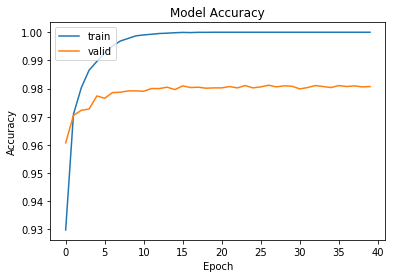

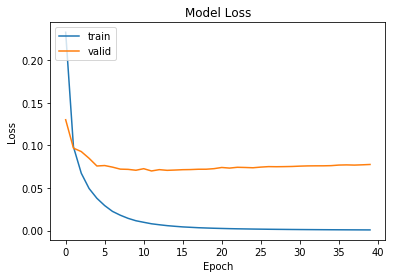

In [190]:
###Plot####
#print(history.history.keys())
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

#### <font color='blue'>Figure 6: Model Accuracy and Model Loss as a Function of the Number of Epochs</font>

Using Keras has again provided similar results to the Scikit-Learn API and the Tensorflow model, though this Keras model does seem to provide better accruacy when using the same hyperparameters.  While the increase in validation accuracy appears to result in an increased accuracy in the Kaggle competition as well, this may be due to the random nature of the DNN graph weights being initiated in each version of the model.

Keras has streamlined the use of Tensorflow, but kept most of the ability to customize the development of a DNN.  With this model, graphs showing the Model Accuracy and Model Loss with each epoch are displayed in Figure 6, helping to provide a visual of how the model is learning and then teaching itself in each epoch.

The predictions made using this model were submitted to Kaggle with the following results.    

Kaggle Submit Date: 3/26/2019

Kaggle Score: 0.97714

Kaggle Competition Rank: 1755

Kaggle User ID: GaryLawson.

## Conclusion

Deep neural networks are an amazing tool in the machine learning space that have revolutionized the ability for models to leverage data to learn how combinations of features impact the target response variable with little guidance from the data scientist.  In a lot of cases the result can be an increased level of target response predictions when compared to other machine learning methods.  

As seen with this example of handwritten digits, DNNs have a lot of promise and can be trained relatively quickly, and ulitimately provide terrific accuracy.  From a business standpoint, an experiment like this shows that DNNs can offer opportunities to help reduce costs through automation of image recognition and increase accuracy by limiting the amount of manual human interaction that is required to review such images.